In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Colab_Notebooks/perturbation_metric_test
!pip install anndata 
!pip install git+https://github.com/theislab/scgen.git
!pip install matplotlib
!pip install scanpy


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/Colab_Notebooks/perturbation_metric_test'
/content/drive/MyDrive/Colab_Notebooks/perturbation_metric_test
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/theislab/scgen.git to /tmp/pip-req-build-mfhuhv4j
  Running command git clone --filter=blob:none --quiet https://github.com/theislab/scgen.git /tmp/pip-req-build-mfhuhv4j
  Resolved https://github.com/theislab/scgen.git to commit 06084773e56cad0dec340138441dee47a39af752
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-whe

In [ ]:
import anndata
import scanpy as sc
import scgen
import pandas as pd  
import numpy as np
import torch
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')

font = {'family' : 'Arial',
        'size'   : 14}
train = sc.read("./data/PapalexiSatija2021_eccite_RNA.h5ad")# instead of top 10 highly expressed genes, we run the whole data sets 
train.layers['counts'] = train.X.copy()
sc.pp.log1p(train)
sc.pp.highly_variable_genes(train, n_top_genes=10, subset=True, min_mean=.1)
train.X = train.layers['counts']

sc.pp.normalize_total(train, target_sum=1e4)
# sc.pp.log1p(train)

from scvi import settings

def log_zinb_positive(
    x: torch.Tensor, mu: torch.Tensor, theta: torch.Tensor, pi: torch.Tensor, eps=1e-8
):
    """Log likelihood (scalar) of a minibatch according to a zinb model.
    Parameters
    ----------
    x
        Data
    mu
        mean of the negative binomial (has to be positive support) (shape: minibatch x vars)
    theta
        inverse dispersion parameter (has to be positive support) (shape: minibatch x vars)
    pi
        logit of the dropout parameter (real support) (shape: minibatch x vars)
    eps
        numerical stability constant
    Notes
    -----
    We parametrize the bernoulli using the logits, hence the softplus functions appearing.
    """
    # theta is the dispersion rate. If .ndimension() == 1, it is shared for all cells (regardless of batch or labels)
    if theta.ndimension() == 1:
        theta = theta.view(
            1, theta.size(0)
        )  # In this case, we reshape theta for broadcasting

    # Uses log(sigmoid(x)) = -softplus(-x)
    softplus_pi = F.softplus(-pi)
    log_theta_eps = torch.log(theta + eps)
    log_theta_mu_eps = torch.log(theta + mu + eps)
    pi_theta_log = -pi + theta * (log_theta_eps - log_theta_mu_eps)

    case_zero = F.softplus(pi_theta_log) - softplus_pi
    mul_case_zero = torch.mul((x < eps).type(torch.float32), case_zero)

    case_non_zero = (
        -softplus_pi
        + pi_theta_log
        + x * (torch.log(mu + eps) - log_theta_mu_eps)
        + torch.lgamma(x + theta)
        - torch.lgamma(theta)
        - torch.lgamma(x + 1)
    )
    mul_case_non_zero = torch.mul((x > eps).type(torch.float32), case_non_zero)

    res = mul_case_zero + mul_case_non_zero

    return res

from typing import Union
import jax.numpy as jnp

def log_nb_positive(
    x: Union[torch.Tensor, jnp.ndarray],
    mu: Union[torch.Tensor, jnp.ndarray],
    theta: Union[torch.Tensor, jnp.ndarray],
    eps: float = 1e-8,
    log_fn: callable = torch.log,
    lgamma_fn: callable = torch.lgamma,
):
    """Log likelihood (scalar) of a minibatch according to a nb model.
    Parameters
    ----------
    x
        data
    mu
        mean of the negative binomial (has to be positive support) (shape: minibatch x vars)
    theta
        inverse dispersion parameter (has to be positive support) (shape: minibatch x vars)
    eps
        numerical stability constant
    log_fn
        log function
    lgamma_fn
        log gamma function
    """
    log = log_fn
    lgamma = lgamma_fn
    log_theta_mu_eps = log(theta + mu + eps)
    res = (
        theta * (log(theta + eps) - log_theta_mu_eps)
        + x * (log(mu + eps) - log_theta_mu_eps)
        + lgamma(x + theta)
        - lgamma(theta)
        - lgamma(x + 1)
    )

    return res

In [ ]:
# print(train.X.shape)
# train.layers['counts'] = train.X.copy()

# sc.pp.subsample(train,n_obs=100)
# train.X = train.layers['counts']



In [ ]:
from statsmodels.discrete.count_model import (ZeroInflatedNegativeBinomialP, ZeroInflatedPoisson,
                                              ZeroInflatedGeneralizedPoisson)

import matplotlib.pyplot as plt
import statsmodels.api as sm 
from joblib import Parallel,delayed
import torch
import torch.nn.functional as F
def data_prep(adata,ctrl,conditions=None,sample_ctrl=False):
    """
    param
    -----------
    adata
    return_mean: bool variable True if we want to compute mean of sampled data per cell to
    find statistic between mean of data from sample1 and sample2
    output: the sampled data from sample1 and sample2 of type array
    """
    # control = adata[adata.obs["perturbation"] == conditions["x"]]
    stim = adata[adata.obs["perturbation"] == conditions["y"]]

    #fix the number of rows of sampled data as the minimum number of rows between sample1,sample2
    n=np.minimum(ctrl.shape[0],stim.shape[0])
    # m=np.minimum(ctrl.shape[1],stim.shape[1])
    y=stim.X.toarray() 
    y = y[:n,:]
    x = ctrl[:n]
  
  
    return x,y

def dist_based(x,y):
    """
    transpose the data so that we can compute static between genes (columns)
    """
    m=np.minimum(x.shape[0],y.shape[0])
    x=x.T[:,:m]#delete .toarray()
    y=y.T[:,:m]
    return x,y

import random

def subset(alist, idxs):
    '''
        use idxs to subset alist
        alist: list
        idxs: list
    '''
    sub_list = []
    for idx in idxs:
        sub_list.append(alist[idx])

    return sub_list

def split_list(alist, group_num=3, shuffle=True, retain_left=False):
    '''
        split data into 3 subset and let each subset contains the len(alist)//group number of elements
        shuffle: whether shuffle the splitted data, default: True
        retain_left: if list alist is splited into the number of group_num subset and there is some element remain，
        whether take the remaining elements as a subset
    '''

    # index = list(range(len(alist))) 
    df = pd.DataFrame({'x':np.arange(len(alist))})
    
    if shuffle: 
         index=df['x'].sample(frac=1, replace=False).values
    
    elem_num = len(alist) // group_num 
    sub_lists = {}
    
   
    for idx in range(group_num):
        start, end = idx*elem_num, (idx+1)*elem_num
        sub_lists[str(idx)] = subset(alist, index[start:end])
    
  
    if retain_left and group_num * elem_num != len(index): 
        sub_lists[str(idx+1)] = subset(alist, index[end:])
    
    return sub_lists



def sample_control_control(adata):
    """
    the sampling for ctrl and ctrl
    split the data into three samples
    shuffle the three samples
    return sample1, sample2, sample3
    
    """
    x = adata.X
    n_rows=x.shape[0]
    index_dict=split_list(range(n_rows))# in form {0: [1,2,3],1:[3,44,2...],3:[]}
    sample1=x[index_dict['0']].toarray()
    sample2=x[index_dict['1']].toarray()
    sample3=x[index_dict['2']].toarray() 
    
    
    return sample1, sample2, sample3 

def process_item_alpha(i,x,if_nb):
    # plt.hist(x[i],bins=30)
    # plt.yscale('log')
    # plt.show()
    
    # print(all(elem == 0 for elem in x[i]))
    print("gene",i)

    if all(elem == 0 for elem in x[i]):
        return None 

    else:
        one=np.ones_like(x[i])
        if if_nb:
          model=sm.NegativeBinomialP(x[i],one).fit()
          index=1
        else:
          model=ZeroInflatedNegativeBinomialP(x[i],one).fit()
          index=2
        if model.params[index]>0:
            # print(model.summary())
            return model.params[index]
        else:
            return None 
    
def process_item_const(i,x,if_nb):
    # plt.hist(x[i],bins=30)
    # plt.yscale('log')
    # plt.show()
    
    # print(all(elem == 0 for elem in x[i]))
    print("gene",i)

    if all(elem == 0 for elem in x[i]):
        return None 

    else:
        one=np.ones_like(x[i])
        if if_nb:
          model=sm.NegativeBinomialP(x[i],one).fit()
          index=1
        else:
          model=ZeroInflatedNegativeBinomialP(x[i],one).fit()
          index=2
        if model.params[index]>0:
        # print(model.summary())
            return model.params[index-1]
        else:
            return None 

def process_per_batch(x,num_from,num_to,if_nb):
    x=x[num_from:num_to,:]

    alpha=Parallel(n_jobs=-1,backend="multiprocessing")(
        delayed(process_item_alpha)(i,x,if_nb)for i in range(x.shape[0])
    )

    const=Parallel(n_jobs=-1,backend="multiprocessing")(
        delayed(process_item_const)(i,x,if_nb)for i in range(x.shape[0])
    ) 
    return alpha,const    


In [ ]:
from scipy import stats
import seaborn as sns
def test_get_data(zinb,train,metric_str):
    """
    fn: the function to get datasets after sampling before we fit the gene in sample1 and sample2
    
    """
    list_stim=list(train.obs['perturbation'].unique())
    list_stim.remove('control')
    conditions={"x":"control","y":"stim"}
    control = train[train.obs["perturbation"] == conditions["x"]]
    difference=[]
    
    # sample1 is always sampled from control and sample2 is sampled from 99 different stim 
    #use prep_data to sample respectively 
    sample1,sample2,sample3=sample_control_control(control) 
    pairs={}
    pairs[0]=(sample1,sample2)
    pairs[1]=(sample1,sample3)
    pairs[2]=(sample2,sample3)
    zero=['control']*3 

    for i in range(3):
        (x,y)=pairs[i]
        out=zinb(adata=train,ctrl=None,conditions=conditions,sample_ctrl=True,ctrl1=x,ctrl2=y)
        # print(" data for (contrl, control):",out)
        difference.append(out)

    if_stim=['stim']*len(list_stim)
    for stim in list_stim:
        conditions["y"]=str(stim)
        # print(conditions)
        out1=zinb(train,sample1,conditions,False)
        out2=zinb(train,sample2,conditions,False)
        out3=zinb(train,sample3,conditions,False)
        out=(out1+out2+out3)/3
        # print("data:",out)
        difference.append(out)
    
    if_stim=zero+if_stim
    metric=[metric_str]*len(if_stim)
        
    return difference,if_stim,metric  

def compute_log_zinb(x,const_x,alpha_x,if_nb):
    # print("mean:",np.mean(x))
    # print("variance:",np.var(x))
    # print("dispersion param:",alpha_x)
    mu=np.exp(const_x)
    theta=1/alpha_x
    # p=1/(1+theta)*mu
    p=mu*theta/(1+theta)
    # p=1/(1+np.exp(const_x)*alpha_x)
    nan=0
    if 1-p<=0 or p<=0:
      most_frequent=0
      nan+=1
    else:
      logit=np.log((1-p)/p)
      # n=np.exp(const_x)*p/(1-p)
     
      n=1/alpha_x*mu
      # sns.set_theme()
      
      # xplot=np.linspace(0,800,801)
      # plt.figure(figsize=(4, 2))
      # plt.hist(np.random.negative_binomial(n, p, size=1000), bins=100, density=True, label='fitted NB')
      # plt.hist(x, label='real values', density=True, alpha=.5)
      # plt.legend()
      # plt.yscale('log')

      if if_nb:
        x_val=log_nb_positive(torch.tensor(x),torch.tensor(mu),torch.tensor(theta))
      else:
        x_val=log_zinb_positive(torch.tensor(x),torch.tensor(mu),torch.tensor(theta),torch.tensor(logit))

      # most_frequent=torch.mode(x_val).values.item()
    return torch.mean(x_val).item(),nan 

def zinb_fit_ctrl(adata,ctrl,conditions,sample_ctrl=False,ctrl1=None,ctrl2=None):
    if sample_ctrl:
        x,y=ctrl1,ctrl2
    else:
        x,y=data_prep(adata,ctrl,conditions)
        
    x,y=dist_based(x,y)
    alpha_x, const_x =process_per_batch(x,0,99,False)# fit x and plug in y 

    out=0
    count=0
    for i in range(x.shape[0]):
        if all(elem == 0 for elem in x[i]):
            continue
        if all(elem == 0 for elem in y[i]):
            continue 
        else:
          NoneType = type(None)
          if isinstance(const_x[i], NoneType) or isinstance(alpha_x[i], NoneType):
              continue 
          else:
              count+=1
              output,nan=compute_log_zinb(y[i],const_x[i],alpha_x[i],False)
              # output,nan=compute_log_zinb(x[i],const_x[i],alpha_x[i],False)
              out+=output
              count-=nan
    
    if count==0:
      count=1# to avoid divison by zero     
            
    return out/count 




In [ ]:
differece0,if_stim0,metric0=test_get_data(zinb_fit_ctrl,train,'zinb')

genegene 0 1

Optimization terminated successfully.
         Current function value: 0.038990
         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.153258gene
         Iterations: 26
          Function evaluations: 292

         Gradient evaluations: 29
gene 3
Optimization terminated successfully.
         Current function value: 0.026487
         Iterations: 18
         Function evaluations: 23
         Gradient evaluations: 23
         Current function value: 0.402025gene
 4         Iterations: 35

         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.419336
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38
         Current function value: 0.515158

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Iterations: 35 
6         Function evaluations: 38

         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.172783
         Iterations: 26Optimization terminated successfully.
         Function evaluations: 29
         Current function value: 0.026069

         Iterations: 18         Gradient evaluations: 29

gene         Function evaluations: 24 8

         Gradient evaluations: 24
gene 9
Optimization terminated successfully.
         Current function value: 0.192913Optimization terminated successfully.

         Current function value: 0.013812
         Iterations: 22
         Function evaluations: 27

         Gradient evaluations: 27         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
genegene  10

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.038990         Current function value: 0.153258

         Iterations: 19         Iterations: 26

         Function evaluations: 25         Function evaluations: 29

 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.419336
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.515158
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.172783
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 8
Optimization terminated successfully.
         Current function value: 0.026069
         Iterations: 18
         Function evaluations: 24
         Gradient evaluations: 24
geneOptimization terminated successfully. 
9         Current function value: 0.192913

         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.013812
         Iterations: 22
         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.038990
         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.153258
gene         Iterations: 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.419336
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.515158
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.172783
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.gene 8
         Current function value: 0.026069

         Iterations: 18
         Function evaluations: 24
         Gradient evaluations: 24
gene 9
Optimization terminated successfully.
         Current function value: 0.192913
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.013812
         Iterations: 22
         Function evaluations: 27
         Gradient evaluations: 27
gene gene 01

Optimization terminated successfully.
         Current function value: 0.153258
Optimization terminated successfully.
         Current function value: 0.038990         Iterations: 26

         Iterations: 19         Function evaluations: 25
         Gradient evaluations: 25

 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.419336
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6         Current function value: 0.515158

         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.172783
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 8
Optimization terminated successfully.
         Current function value: 0.026069
         Iterations: 18
         Function evaluations: 24
         Gradient evaluations: 24
gene 9
Optimization terminated successfully.
         Current function value: 0.192913
         Iterations: 24
         Function evaluations: 27Optimization terminated successfully.

         Gradient evaluations: 27         Current function value: 0.013812

         Iterations: 22
         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.134899
         Iterations: 25
Optimization terminated successfully.         Function evaluations: 29

         Current function value: 0.014381         Gradient evaluations: 29

         Iterations: 21
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.468728
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Warning: Maximum number of iterations has been exceeded.6
         Current function value: 0.669163

         Iterations: 35
         Function evaluations: 44
         Gradient evaluations: 44


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.201152
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 8
Optimization terminated successfully.
         Current function value: 0.014321
         Iterations: 22
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.gene
         Current function value: 0.200732 
9         Iterations: 20

         Function evaluations: 24
         Gradient evaluations: 24
gene 0gene
 1
Optimization terminated successfully.
         Current function value: 0.134899
         Iterations: 25Optimization terminated successfully.
         Current function value: 0.014381

         Iterations: 21         Function evaluations: 29

         Gradient evaluations: 29         Function evaluations: 26

         Gradient evaluations: 26
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.013466
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.468728
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.669163
         Iterations: 35
         Function evaluations: 44
         Gradient evaluations: 44


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.201152
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 8Optimization terminated successfully.

         Current function value: 0.014321
         Iterations: 22
         Function evaluations: 27
         Gradient evaluations: 27
gene 9
Optimization terminated successfully.
         Current function value: 0.200732
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.131262
Optimization terminated successfully.         Iterations: 25

         Function evaluations: 28         Current function value: 0.038858
         Gradient evaluations: 28

         Iterations: 19
gene          Function evaluations: 252

         Gradient evaluations: 25
gene 3
Optimization terminated successfully.
         Current function value: 0.038067
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.325500
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.gene
          Current function value: 0.1041155

         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 7
Optimization terminated successfully.         Current function value: 0.426770

         Iterations: 35         Current function value: 0.036595
         Function evaluations: 38

         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 38         Gradient evaluations: 25



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8
gene 9
Optimization terminated successfully.
         Current function value: 0.220183
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.131262
         Current function value: 0.038858
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28

         Iterations: 19gene 
2
         Function evaluations: 25
         Gradient evaluations: 25
gene 3
Optimization terminated successfully.
         Current function value: 0.038067
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
gene 4
         Current function value: 0.427730
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.325500
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 5
Optimization terminated successfully.
         Current function value: 0.104115
         Iterations: 26Warning: Maximum number of iterations has been exceeded.

         Function evaluations: 30         Current function value: 0.426770
         Gradient evaluations: 30

         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 gene 7
8
Optimization terminated successfully.
         Current function value: 0.036595
         Iterations: 20
         Function evaluations: 25Optimization terminated successfully.
         Current function value: 0.220183

         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27         Gradient evaluations: 25

gene 9
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.192392
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 4
         Current function value: 0.446875
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39
         Current function value: 0.500317

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Iterations: 35
         Function evaluations: 37 6

         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.132839
         Iterations: 25
         Function evaluations: 29
         Gradient evaluations: 29
gene 7
gene 8
         Current function value: 0.659127
         Iterations: 35
Optimization terminated successfully.         Function evaluations: 47
         Gradient evaluations: 47

         Current function value: 0.159917

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 26gene
 9
         Function evaluations: 29
         Gradient evaluations: 29
gene 0gene
 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.192392
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 4
         Current function value: 0.446875
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39
         Current function value: 0.500317

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Iterations: 35 
6         Function evaluations: 37

         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.132839
         Iterations: 25
         Function evaluations: 29
         Gradient evaluations: 29
gene 7
 gene8
         Current function value: 0.659127
Optimization terminated successfully.         Iterations: 35

         Current function value: 0.159917         Function evaluations: 47
         Iterations: 26

         Gradient evaluations: 47
         Function evaluations: 29
         Gradient evaluations: 29

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.072482Optimization terminated successfully.

         Current function value: 0.038858
         Iterations: 19
         Function evaluations: 23         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 23

         Gradient evaluations: 25gene 
2
gene 3
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.038858         Current function value: 0.327023
         Iterations: 22

         Iterations: 19         Function evaluations: 25

         Function evaluations: 25         Gradient evaluations: 25

         Gradient evaluations: 25
gene 4gene 
5

         Current function value: 0.402998
         Current function value: 0.702972         Iterations: 35

         Function evaluations: 38         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
         Gradient evaluations

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
7
Optimization terminated successfully.
         Current function value: 0.192330
Optimization terminated successfully.         Iterations: 25

         Current function value: 0.037324         Function evaluations: 28

         Gradient evaluations: 28         Iterations: 18

         Function evaluations: 22gene
          Gradient evaluations: 22
8
gene 9
Optimization terminated successfully.
         Current function value: 0.072482
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 0
Optimization terminated successfully.
         Current function value: 0.072482gene 
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 231

gene 2
Optimization terminated successfully.
         Current function value: 0.038858
         Iterations: 19
         Function evaluations: 25Optimization terminated successfully.
         Gradient evaluations: 25

gene          Current function value: 0.0388583

         

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
          Current function value: 0.1923305

         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 7
         Current function value: 0.702972
         Iterations: 35Optimization terminated successfully.

         Current function value: 0.037324
         Function evaluations: 37         Iterations: 18
         Gradient evaluations: 37

         Function evaluations: 22

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Gradient evaluations: 22
genegene 8 
9
Optimization terminated successfully.
         Current function value: 0.072482
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene gene1
 0
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.071997         Current function value: 0.065239

         Iterations: 19         Iterations: 17

         Function evaluations: 23         Function evaluations: 21

         Gradient evaluations: 23         Gradient evaluations: 21

gene gene 23

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.070428         Current function value: 0.350368

         Iterations: 18
         Iterations: 23         Function evaluations: 22
         Function evaluations: 26
         Gradient evaluations: 22

gene         Gradient evaluations: 26 
4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene 5
Optimization terminated successfully.
         Current function value: 0.246069
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
6         Current function value: 0.447343

         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.071997
         Iterations: 19
         Function evaluations: 23
Optimization terminated successfully.         Gradient evaluations: 23
         Current function value: 0.067506

         Iterations: 18gene
          Function evaluations: 228

         Gradient evaluations: 22
gene 9
Optimization terminated successfully.
         Current function value: 0.298759
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.065239
         Iterations: 17
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.gene
         Current function value: 0.071997
         Iterations: 19
          Function evaluations: 23
         Gradient evaluations: 23
2
gene 3
Optimization terminated successfully.
         Current function value: 0.070428
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 5
Optimization terminated successfully.
         Current function value: 0.246069
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 6
         Current function value: 0.447343
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.
         Current function value: 0.071997
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  87

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.298759         Current function value: 0.067506

         Iterations: 22         Iterations: 18

         Function evaluations: 25         Function evaluations: 22

         Gradient evaluations: 25         Gradient evaluations: 22

gene 9
genegene 0 1

gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.191127
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
geneOptimization terminated successfully.
         Current function value: 0.346533 
4         Iterations: 19

         Function evaluations: 23
         Gradient evaluations: 23
gene 6
Optimization terminated successfully.         Current function value: 0.544005

         Iterations: 35
         Function evaluations: 37
         Current function value: 0.071997
         Iterations: 19         Gradient evaluations: 37

         Fu

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 23gene 5

gene 7
gene 8
         Current function value: 0.633295
Optimization terminated successfully.         Iterations: 35

         Current function value: 0.190383         Function evaluations: 48

         Iterations: 25         Gradient evaluations: 48

         Function evaluations: 28
         Gradient evaluations: 28

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
gene gene0 
1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.191127
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.gene 4

         Current function value: 0.346533
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 6
Optimization terminated successfully.
         Current function value: 0.544005         Current function value: 0.071997

         Iterations: 19         Iterations: 35

         Function evaluations: 23         Function evaluations: 37
         Gradient evaluations: 23

         Gradient evaluations: 37
gene 7

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



genegene  58

Optimization terminated successfully.
         Current function value: 0.190383
         Iterations: 25
         Function evaluations: 28Warning: Maximum number of iterations has been exceeded.

         Gradient evaluations: 28         Current function value: 0.633295

         Iterations: 35gene 9

         Function evaluations: 48
         Gradient evaluations: 48


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
genegene 2 
1
gene 3
Optimization terminated successfully.
         Current function value: 0.071997
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene Optimization terminated successfully.
4         Current function value: 0.350403

         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 6
         Current function value: 0.497115
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37Optimization terminated successfully.

         Current function value: 0.245946
         Iterations: 23
         Function evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



genegene  57

Optimization terminated successfully.
         Current function value: 0.068952
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 8
Optimization terminated successfully.
         Current function value: 0.071997
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 9
         Current function value: nan
         Iterations: 31
         Function evaluations: 258
         Gradient evaluations: 256


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene 01

gene 2gene
 3
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.071997

         Current function value: 0.350403         Iterations: 19

         Function evaluations: 23         Iterations: 23

         Gradient evaluations: 23
         Function evaluations: 26
         Gradient evaluations: 26gene
 4


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 6
Optimization terminated successfully.         Current function value: 0.497115

         Iterations: 35         Iterations: 23         Current function value: 0.245946

         Function evaluations: 37

         Function evaluations: 26         Gradient evaluations: 37

         Gradient evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  75

Optimization terminated successfully.
         Current function value: 0.068952
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 8
Optimization terminated successfully.
         Current function value: 0.071997
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 9
         Current function value: nan
         Iterations: 31
         Function evaluations: 258
         Gradient evaluations: 256


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene 0
1
Optimization terminated successfully.
         Current function value: 0.085220
Optimization terminated successfully.
         Iterations: 26         Current function value: 0.094371
         Function evaluations: 30
         Iterations: 23
         Gradient evaluations: 30
         Function evaluations: 28

gene         Gradient evaluations: 28
 2
genegene  34

Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.249283
         Iterations: 23

         Function evaluations: 26         Current function value: 0.249331
         Iterations: 23

         Gradient evaluations: 26         Function evaluations: 26
         Gradient evaluations: 26

genegene  56

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.318257         Current function value: 0.094371
         Iterations: 22

         Iterations: 23         Function evaluations: 25

         Gradient eva

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 9
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.085220
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
gene         Current function value: 0.094371 
2         Iterations: 23

gene         Function evaluations: 28 3

         Gradient evaluations: 28
gene 4
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.249283
         Current function value: 0.249331

         Iterations: 23
         Iterations: 23         Function evaluations: 26
         Function evaluations: 26

         Gradient evaluations: 26         Gradient evaluations: 26

gene 5gene
 6
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.094371
         Current function value: 0.318257
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25

        

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.094371
         Iterations: 23
         Function evaluations: 28
         Gradient evaluations: 28
gene Warning: Maximum number of iterations has been exceeded.4

         Current function value: 0.383668
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38
         Current function value: 0.388916
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.094371
         Iterations: 23
         Current function value: 0.814881
         Iterations: 35
         Function evaluations: 48
         Gradient evaluations: 48
         Function evaluations: 28

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 28
gene 8gene 
7
gene 9
Optimization terminated successfully.
         Current function value: 0.173567
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene gene 0
1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.094371
         Iterations: 23
         Function evaluations: 28
         Gradient evaluations: 28
         Current function value: 0.383668
gene         Iterations: 35
         Function evaluations: 38
          Gradient evaluations: 384



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.388916
         Iterations: 35Optimization terminated successfully.
         Current function value: 0.094371

         Iterations: 23         Function evaluations: 38
         Function evaluations: 28

         Gradient evaluations: 28         Gradient evaluations: 38



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  57

gene 8
         Current function value: 0.814881
Optimization terminated successfully.         Iterations: 35

         Function evaluations: 48         Current function value: 0.173567

         Gradient evaluations: 48
         Iterations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 29

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Gradient evaluations: 29 
9
gene 0
gene 2gene
 1
gene 3
Optimization terminated successfully.
         Current function value: 0.094371
         Iterations: 23
         Function evaluations: 28
         Gradient evaluations: 28
gene 4
Optimization terminated successfully.
         Current function value: 0.174576
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
          Current function value: 0.4551366

         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.249165
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 7
gene 8
         Current function value: 0.699525
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
          Current function value: 0.0943719
         Iterations: 23

         Function evaluations: 28
         Gradient evaluations: 28
gene 0
gene 2
gene 1
gene 3
Optimization terminated successfully.
         Current function value: 0.094371
         Iterations: 23
         Function evaluations: 28
         Gradient evaluations: 28
gene 4
Optimization terminated successfully.
         Current function value: 0.174576
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 6
         Current function value: 0.455136
         Iterations: 35Optimization terminated successfully.
         Current function value: 0.249165
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene
 7
         Function evaluations: 39gene
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5 8

Optimization terminated successfully.
         Current function value: 0.094371
         Iterations: 23
         Function evaluations: 28
         Gradient evaluations: 28
         Current function value: 0.699525
          Iterations: 359

         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene 01

Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.131753
         Current function value: 0.050137         Iterations: 25

         Iterations: 19         Function evaluations: 29

         Function evaluations: 23
         Gradient evaluations: 29         Gradient evaluations: 23

gene gene 23

Optimization terminated successfully.
         Current function value: 0.026278
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
4         Current function value: 0.464039

         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.448645
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.432366 
6
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.191034
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 8
Optimization terminated successfully.
         Current function value: 0.025301
         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 25
geneOptimization terminated successfully. 
9         Current function value: 0.209917

         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 0
gene 1
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.050137
         Current function value: 0.131753
         Iterations: 19         Iterations: 25

         Function evaluations: 23         Function evaluations: 29

         Gradient evaluations: 23         Gradient evaluations: 29

genegene  32

Optimization terminated successfully.
         Current function value: 0.026278
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.448645Warning: Maximum number of iterations has been exceeded.

         Iterations: 35         Current function value: 0.432366

         Function evaluations: 38         Iterations: 35

         Function evaluations: 38
         Gradient evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 6gene
 7
Optimization terminated successfully.
         Current function value: 0.191034
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 8
Optimization terminated successfully.
         Current function value: 0.025301
         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.gene
         Current function value: 0.209917 9

         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 0gene 
1
Optimization terminated successfully.
         Current function value: 0.026803
         Iterations: 18
         Function evaluations: 24
         Gradient evaluations: 24
gene 2Optimization terminated successfully.

         Current function value: 0.153438
gene         Iterations: 26
          Function evaluations: 293

         Gradient evaluations: 29
gene 4
         Current function value: 0.461814
         Iterations: 35Warning: Maximum

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene  56

Optimization terminated successfully.
         Current function value: 0.190485
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 7
         Current function value: 0.634375
         Iterations: 35
         Function evaluations: 48
gene          Gradient evaluations: 488



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.169833
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.153438
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.gene 2
         Current function value: 0.026803

gene         Iterations: 18 
3         Function evaluations: 24

         Gradient evaluations: 24
gene 4
         Current function value: 0.461814
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.449756
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.634375
         Iterations: 35
         Function evaluations: 48
         Gradient evaluations: 48
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.190485
gene         Iterations: 24
         Function evaluations: 27 
         Gradient evaluations: 27
7
genegene 8 
9
Optimization terminated successfully.
         Current function value: 0.169833
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.153256
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
geneOptimization terminated successfully. 
         Current function value: 0.026803
         Iterations: 182

         Function evaluations: 24
         Gradient evaluations: 24
gene 3
Optimization terminated successfully.
         Current function value: 0.050137
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 4
         Current function value: 0.400283
         Iterations: 35
         Function evaluations: 38
         Gradient eval

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.416847
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.707312
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Optimization terminated successfully.7

         Current function value: 0.191258
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 8
Optimization terminated successfully.
         Current function value: 0.025785
         Iterations: 20
         Function evaluations: 26

         Gradient evaluations: 26gene 9
Optimization terminated successfully.
         Current function value: 0.133006
         Iterations: 25
         Function evaluations: 29
         Gradient evaluations: 29
gene 0gene
 1
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.153256

         Iterations: 26
         Current function value: 0.026803
         Function evaluations: 29         Iterations: 18

         Gradient evaluations: 29
         Function evaluations: 24
         Gradient evaluations: 24
gene 2
gene 3
Optimization terminated successfully.

         Current function value: 0.400283

         

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 4
gene 5
         Current function value: 0.416847
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Current function value: 0.707312 6

         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7Optimization terminated successfully.

         Current function value: 0.191258
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 8
Optimization terminated successfully.
         Current function value: 0.025785
         Iterations: 20
         Function evaluations: 26
         Gradient evaluations: 26
gene 9
Optimization terminated successfully.
         Current function value: 0.133006
         Iterations: 25
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.054249
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
gene         Current function value: 0.059738 
2
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 3
Optimization terminated successfully.
Optimization terminated successfully.         Current

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Function evaluations: 25
         Gradient evaluations: 25
gene 9
gene 0gene
 1
Optimization terminated successfully.
         Current function value: 0.054249
         Iterations: 18
Optimization terminated successfully.         Function evaluations: 22
         Gradient evaluations: 22

         Current function value: 0.059738
         Iterations: 19
gene         Function evaluations: 23 2

         Gradient evaluations: 23
gene 3
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.058463

         Current function value: 0.334341
         Iterations: 19         Iterations: 22

         Function evaluations: 25         Function evaluations: 23

         Gradient evaluations: 25         Gradient evaluations: 23

gene gene 46

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.204996
         Current function value: 0.059738         Iterations: 19

         F

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Function evaluations: 25 
9         Gradient evaluations: 25

genegene  10

gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.159063
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.gene
          Current function value: 0.3722854

         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 6
Optimization terminated successfully.Warning: Maximum number of iterations has been exceeded.
         Current function value: 0.156458

         Iterations: 26         Current function value: 0.569778

         Function evaluations: 29         Iterations: 35

         Gradient evaluations: 29
         Function evaluations: 37
         Gradient evaluations: 37
gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8gene
 5
Optimization terminated successfully.
         Current function value: 0.204389
         Iterations: 24
         Function evaluations: 28Warning: Maximum number of iterations has been exceeded.

         Gradient evaluations: 28         Current function value: 0.605408

         Iterations: 35
gene          Function evaluations: 439
         Gradient evaluations: 43



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.159063
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.gene 
         Current function value: 0.3722854
         Iterations: 23

         Function evaluations: 26
         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 6
Optimization terminated successfully.
         Current function value: 0.156458
         Iterations: 26
         Function evaluations: 29Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.569778         Gradient evaluations: 29

         Iterations: 35gene
 7         Function evaluations: 37
gene
          Gradient evaluations: 37
8


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.204389
         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28
gene 9
         Current function value: 0.605408
         Iterations: 35
         Function evaluations: 43
         Gradient evaluations: 43


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  1
0
gene 2
Optimization terminated successfully.
         Current function value: 0.059738
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 3
Optimization terminated successfully.
         Current function value: 0.059738
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 4Optimization terminated successfully.

         Current function value: 0.292388
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
 6         Current function value: 0.569728

         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Optimization terminated successfully.5

         Current function value: 0.249231
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 7
Optimization terminated successfully.
         Current function value: 0.057265
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 8
         Current function value: nan
Optimization terminated successfully.
         Current function value: 0.059738         Iterations: 32

         Function evaluations: 152         Iterations: 19

         Gradient evaluations: 152         Function evaluations: 23



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 9
gene gene0 1

gene 2
Optimization terminated successfully.
         Current function value: 0.059738Optimization terminated successfully.
         Iterations: 19

         Function evaluations: 23         Current function value: 0.059738

         Gradient evaluations: 23         Iterations: 19

gene         Function evaluations: 23 
         Gradient evaluations: 233

gene 4
Optimization terminated successfully.
         Current function value: 0.292388
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25Warning: Maximum number of iterations has been exceeded.

gene         Current function value: 0.569728 6

         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


geneOptimization terminated successfully. 
         Current function value: 0.2492315

         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 7
Optimization terminated successfully.
         Current function value: 0.057265
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 8
Optimization terminated successfully.
         Current function value: 0.059738
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 9
         Current function value: nan
         Iterations: 32
         Function evaluations: 152
         Gradient evaluations: 152


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.124266
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20Optimization terminated successfully.

         Current function value: 0.068568
         Iterations: 19
         Function evaluations: 24gene
          Gradient evaluations: 24
2
gene 3
Optimization terminated successfully.
         Current function value: 0.036000
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 4
         Current function value: 0.472287
Optimization terminated successfully.         Iterations: 35

         Function evaluations: 37         Current function value: 0.356480

         Iterations: 18         Gradient evaluations: 37

         Function evaluations: 22
         Gradient evaluations: 22


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  65

Optimization terminated successfully.

         Iterations: 26
         Current function value: 0.450537         Function evaluations: 30

         Gradient evaluations: 30         Iterations: 35

         Function evaluations: 38
         Gradient evaluations: 38
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene7
 8
Optimization terminated successfully.
         Current function value: 0.208520Optimization terminated successfully.

         Iterations: 22
         Current function value: 0.034616         Function evaluations: 25
         Iterations: 19
         Function evaluations: 23

         Gradient evaluations: 23         Gradient evaluations: 25

gene 9
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.124266
         Iterations: 16
         Function evaluations: 20Optimization terminated successfully.
         Gradient evaluations: 20

         Current function value: 0.068568gene
         Iterations: 19
 2
         Function evaluations: 24
         Gradient evaluations: 24
gene 3
Optimization terminated successfully.
         Current function value: 0.036000
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene          Current function value: 0.4722874

         Iterations: 35
         Function evalu

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.356480
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 6
         Current function value: 0.450537
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Optimization terminated successfully.
7         Current function value: 0.098523

         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 8
Optimization terminated successfully.
         Current function value: 0.034616
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.gene
         Current function value: 0.208520 
9
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.036743
         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.gene
         Current function value: 0.182172
          Iterations: 262

gene         Function evaluations: 29
 3         Gradient evaluations: 29

gene 4
         Current function value: 0.468868

         Function evaluations: 37
       

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37gene
 5

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.668081
         Iterations: 35
         Function evaluations: 40Optimization terminated successfully.

         Gradient evaluations: 40         Current function value: 0.153570

         Iterations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Function evaluations: 29 
7
gene          Gradient evaluations: 298

gene 9
Optimization terminated successfully.
         Current function value: 0.151421
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.182172
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29Optimization terminated successfully.

gene         Current function value: 0.036743
 2         Iterations: 19

         Function evaluations: 25gene
          Gradient evaluations: 25
3
gene 4
         Current function value: 0.468868
         Iterations: 35Warning: Maximum number of iterations has been exceeded.
         Function evaluations: 37
         Current function value: 0.496597
         Gradient evaluations: 37

         Iterations: 35
         Function evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 
5         Gradient evaluations: 37



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.668081
         Iterations: 35
Optimization terminated successfully.         Function evaluations: 40

         Gradient evaluations: 40
         Current function value: 0.153570
         Iterations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Function evaluations: 29
          Gradient evaluations: 29
7
genegene  98

Optimization terminated successfully.
         Current function value: 0.151421
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0gene
 1
Optimization terminated successfully.
         Current function value: 0.068568
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.036743
         Iterations: 19gene
         Function evaluations: 25 2

         Gradient evaluations: 25
gene 3
Optimization terminated successfully.
         Current function value: 0.036743
         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.gene 4

         Current function value: 0.334223
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 5
         

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
         Function evaluations: 37
         Gradient evaluations: 37
 6


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.208240
         Iterations: 23
         Function evaluations: 26Optimization terminated successfully.
         Gradient evaluations: 26

gene         Current function value: 0.035301
          Iterations: 198

         Function evaluations: 24
         Gradient evaluations: 24
gene 9
Optimization terminated successfully.
         Current function value: 0.068568
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.036743
         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.gene
         Current function value: 0.068568
         Iterations: 19
         Function evaluations: 24 2


         Gradient evaluations: 24gene 3
Optimization terminated successfully.
         Current function value: 0.036743
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.035301
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
          Current function value: 0.6878278

         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.068568
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.108754
         Iterations: 27Optimization terminated successfully.
         Current function value: 0.120833
         Function evaluations: 30

         Iterations: 26         Gradient evaluations: 30

         Function evaluations: 30
         Gradient evaluations: 30
gene gene 23
gene
 4
Optimization terminated successfully.
         Current function value: 0.222898Optimization terminated successfully.

         Current function value: 0.120833         Iterations: 24

         Iterations: 26         Function evaluations: 27

         Gradient evaluations: 27         Function evaluations: 30

         Gradient evaluations: 30
genegene  65

gene 7
gene 8
         Current function value: 0.404723
         Iterations: 35
    

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Warning: Maximum number of iterations has been exceeded.
         Current function value: 0.493465
         Iterations: 35
9         Function evaluations: 37
         Gradient evaluations: 37



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.108754
         Iterations: 27
         Function evaluations: 30
         Gradient evaluations: 30
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.120833
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
geneOptimization terminated successfully.
 4         Current function value: 0.120833

         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
gene         Current function value: 0.222898
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
 gene6
 5
gene 7
gene 8
         Current function value: 0.404723
         Iterations: 35
         Function evaluations: 38

         Current function value: 0.493465

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Iterations: 35 
9         Function evaluations: 37

         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
gene 3Optimization terminated successfully.

         Current function value: 0.120833
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 4
         Current function value: 0.407664
         Iterations: 35
         Current function value: 0.487031         Function evaluations: 38

         Iterations: 35         Gradient evaluations: 38

         Function evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 37gene
 5

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 6

         Current function value: 0.120833         Current function value: 0.883207

         Iterations: 26         Iterations: 35

         Function evaluations: 30         Function evaluations: 40

         Gradient evaluations: 30         Gradient evaluations: 40

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7gene
 gene8 
9
Optimization terminated successfully.
         Current function value: 0.221566
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.120833
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
4
         Current function value: 0.487031
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.407664
         Iterations: 35
         Function evaluations: 38Optimization terminated successfully.

         Gradient evaluations: 38
         Current function value: 0.120833

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
         Iterations: 26 5

         Function evaluations: 30
         Gradient evaluations: 30
gene 7
         Current function value: 0.883207
          Iterations: 358

         Function evaluations: 40
         Gradient evaluations: 40


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.221566
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene gene 01

gene 2gene 
gene3
 4
Optimization terminated successfully.
         Current function value: 0.222898
         Iterations: 24
Optimization terminated successfully.
         Function evaluations: 27
         Current function value: 0.317696         Gradient evaluations: 27
         Iterations: 22

         Function evaluations: 25gene
 6         Gradient evaluations: 25

gene 5
Optimization terminated successfully.
         Current function value: 0.222679
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
7         Current function value: 0.653361

         Iterations: 35gene
          Function evaluations: 378

         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.120833
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 0
genegene 2 
1gene
gene  34

Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.317696

         Current function value: 0.222898         Iterations: 22

         Iterations: 24         Function evaluations: 25

         Function evaluations: 27         Gradient evaluations: 25

         Gradient evaluations: 27
gene gene5 
6
Optimization terminated successfully.
         Current function value: 0.222679
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.653361gene
          Iterations: 357

         Function evaluations: 37

         Gradient evaluations: 37gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
8
Optimization terminated successfully.
         Current function value: 0.120833
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 0
gene 1
Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.054835
         Current function value: 0.099649
         Iterations: 19         Iterations: 17

         Function evaluations: 23
         Function evaluations: 21         Gradient evaluations: 23

         Gradient evaluations: 21
gene gene 32

Optimization terminated successfully.
         Current function value: 0.028754
         Iterations: 19
         Current function value: 0.470832         Function evaluations: 24

         Iterations: 35
         Function evaluations: 37         Gradient evaluations: 24

         Gradient evaluations: 37
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 4
gene 5
         Current function value: 0.399608

         Current function value: 0.435742         Iterations: 35
         Iterations: 35
         Function evaluations: 38

         Gradient evaluations: 38         Function evaluations: 38
         Gradient evaluations: 38



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  67

Optimization terminated successfully.
         Current function value: 0.027675
Optimization terminated successfully.         Iterations: 19

         Function evaluations: 25         Current function value: 0.145633

         Iterations: 25
         Gradient evaluations: 25         Function evaluations: 28

         Gradient evaluations: 28
gene gene8
 9
Optimization terminated successfully.
         Current function value: 0.208823
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 0
gene 1
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.099649

         Current function value: 0.054835
         Iterations: 19         Iterations: 17

         Function evaluations: 21         Function evaluations: 23

         Gradient evaluations: 21         Gradient evaluations: 23

genegene  32

Optimization terminated successfully.
         Current function value: 0.028754
    

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.399608
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.435742gene
          Iterations: 356

         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.145633
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28Optimization terminated successfully.

         Current function value: 0.027675gene
         Iterations: 19
 8         Function evaluations: 25

         Gradient evaluations: 25
gene 9
Optimization terminated successfully.
         Current function value: 0.208823
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.167552
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.029333
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25 gene
2gene
gene  3
4
         Current function value: 0.472316
         Iterations: 35
         Function 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 5

         Current function value: 0.485461
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.641244
         Iterations: 35
         Function evaluations: 47
         Gradient evaluations: 47
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Current function value: 0.207911 
7
         Iterations: 19
gene 8         Function evaluations: 23

         Gradient evaluations: 23
gene 9
Optimization terminated successfully.
         Current function value: 0.164431
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.167552
         Iterations: 26
Optimization terminated successfully.         Function evaluations: 29
         Current function value: 0.029333

         Iterations: 20         Gradient evaluations: 29
         Function evaluations: 25

         Gradient evaluations: 25
genegene  32
gene
 4
         Current function value: 0.485461

         Iterations: 35         Current function value: 0.472316

         Iterations: 35
         Function evaluations: 37         Function evaluations: 37

         Gradient evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  56

Optimization terminated successfully.
         Current function value: 0.207911
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
7         Current function value: 0.641244

         Iterations: 35
gene         Function evaluations: 47 8

         Gradient evaluations: 47


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.164431
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
genegene 0 
1
Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.029333         Current function value: 0.124375
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25

         Iterations: 26gene
 2         Function evaluations: 30

         Gradient evaluations: 30
gene 3
Optimization terminated successfully.
         Current function value: 0.054835
         Iterations: 19
         Function evaluations: 23Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.381678
         Iterations: 35         Gradient evaluations: 23

         Function evaluations: 38
         Gradient evaluations: 38
gene 4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 5
         Current function value: 0.400404
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.208764
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 7
         Current function value: nan
         Iterations: 34
         Function evaluations: 154
         Gradient evaluations: 154


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
gene          Current function value: 0.0282098
         Iterations: 18

         Function evaluations: 24
         Gradient evaluations: 24
gene 9
Optimization terminated successfully.
         Current function value: 0.123807
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
genegene  0
1
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.029333

         Iterations: 20
         Function evaluations: 25

         Gradient evaluations: 25         Current function value: 0.124375
         Iterations: 26
gene 2         Function evaluations: 30

         Gradient evaluations: 30
gene 3
Optimization terminated successfully.
         Current function value: 0.054835
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 4
         Current function value: 0.381678
         Iterations: 35
         Function evaluat

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.400404
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.208764
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 7
Optimization terminated successfully.
         Current function value: 0.028209
         Iterations: 18
         Function evaluations: 24
         Gradient evaluations: 24
gene 8
         Current function value: nan
         Iterations: 34
         Function evaluations: 154
         Gradient evaluations: 154


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.123807
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.123494
         Iterations: 16
         Function evaluations: 20Optimization terminated successfully.

         Current function value: 0.068136
         Gradient evaluations: 20
         Iterations: 19
         Function evaluations: 24
gene         Gradient evaluations: 24
 2
gene 3
Optimization terminated successfully.
         Current function value: 0.035772
         Iterations: 19
         Function evaluations: 24

         Current function value: 0.469441
gene         Iterations: 35 
4         Function evaluations: 37

         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.377777
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Current function value: 0.4478166

         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.125743
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
gene Optimization terminated successfully.
8
         Current function value: 0.034398
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
gene 9
Optimization terminated successfully.
         Current function value: 0.207233
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 0gene
 1
Optimization terminated successfully.
         Current function value: 0.123494
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
gene 2
Optimization terminated successfully.
         Current function value: 0.068136
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 3
Optimization terminated successfully.
         Current function value: 0.035772
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.377777Optimization terminated successfully.

         Current function value: 0.125743
         Iterations: 35
         Iterations: 16         Function evaluations: 38

         Function evaluations: 20         Gradient evaluations: 38

         Gradient evaluations: 20


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  57

Optimization terminated successfully.
         Current function value: 0.034398
         Iterations: 20

         Current function value: 0.447816         Gradient evaluations: 24

         Iterations: 35
gene         Function evaluations: 38 
8         Gradient evaluations: 38



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.207233
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene gene
 10
Optimization terminated successfully.
         Current function value: 0.036510Optimization terminated successfully.

         Current function value: 0.181044         Iterations: 19
         Iterations: 26
         Function evaluations: 25
         Function evaluations: 29

         Gradient evaluations: 25         Gradient evaluations: 29

genegene 2
 gene3 4

         Current function value: 0.493608
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5

         Current function value: 0.466046
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.684914
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene 8Optimization terminated successfully.
         Current function value: 0.152618

         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
geneOptimization terminated successfully. 9

         Current function value: 0.150484
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene  gene01

Optimization terminated successfully.
         Current function value: 0.036510
         Iterations: 19
         Function evaluations: 25Optimization terminated successfully.

         Gradient evaluations: 25
         Current function value: 0.181044
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
genegene 2 
3gene
 4
         Current function value: 0.493608
         Iterations: 35Warning: Maximum number of iterations has been exceeded.
         Current function value: 0.466046

         Iterations: 35         Function evaluations: 37

         Gradient evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 gene5 
6
Optimization terminated successfully.
         Current function value: 0.684914

         Iterations: 26         Iterations: 35

         Function evaluations: 29         Function evaluations: 37

         Gradient evaluations: 29         Gradient evaluations: 37



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 gene7 
8gene
 9
Optimization terminated successfully.
         Current function value: 0.150484
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.068136
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 2
Optimization terminated successfully.
         Current function value: 0.036510
         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.036510
         Iterations: 19
gene         Function evaluations: 25 
3         Gradient evaluations: 25

gene 4
Optimization terminated successfully.
         Current function value: 0.332184
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 6
         Current function value: 0.379664
         Iterations: 35
         Functi

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.206956gene
          Iterations: 235

         Function evaluations: 26
         Gradient evaluations: 26
gene 7
         Current function value: 0.683776
Optimization terminated successfully.         Iterations: 35

         Current function value: 0.035078

         Function evaluations: 37

         Iterations: 19         Gradient evaluations: 37         Function evaluations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 24gene
 gene8
 9
Optimization terminated successfully.
         Current function value: 0.068136
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.068136
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.036510
gene         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 25 
2
gene 3
Optimization terminated successfully.
         Current function value: 0.332184
         Iterations: 22Optimization terminated successfully.

         Current function value: 0.036510         Function evaluations: 25

         Gradient evaluations: 25         Iterations: 19

         Function evaluations: 25
gene         Gradient evaluations: 25 
4
gene 6
         Current function value: 0.379664
        

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.206956
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene Warning: Maximum number of iterations has been exceeded.7

         Current function value: 0.683776
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8
Optimization terminated successfully.
         Current function value: 0.035078
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24Optimization terminated successfully.

         Current function value: 0.068136
         Iterations: 19gene
         Function evaluations: 24 9

         Gradient evaluations: 24
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.144278Optimization terminated successfully.

         Iterations: 25         Current function value: 0.042798

         Iterations: 20         Function evaluations: 28

         Gradient evaluations: 28
         Function evaluations: 24
         Gradient evaluations: 24gene
 2
gene 3
Optimization terminated successfully.
         Current function value: 0.041918
Optimization terminated successfully.         Iterations: 20

         Current function value: 0.358844         Function evaluations: 25

         Gradient evaluations: 25         Iterations

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 5
Optimization terminated successfully.
         Current function value: 0.328676
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene          Current function value: 0.413559
6
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.114521
         Iterations: 26
         Function evaluations: 30
Optimization terminated successfully.         Gradient evaluations: 30

         Current function value: 0.040280gene
          Iterations: 188

         Function evaluations: 23
         Gradient evaluations: 23
gene 9
Optimization terminated successfully.
         Current function value: 0.241852
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.144278
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
geneOptimization terminated successfully.
 2         Current function value: 0.042798

         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
gene 3
Optimization terminated successfully.
         Current function value: 0.041918
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene 5
Optimization terminated successfully.
         Current function value: 0.328676
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene Warning: Maximum number of iterations has been exceeded.6

         Current function value: 0.413559
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Optimization terminated successfully.
         Current function value: 0.1145217
         Iterations: 26


         Function evaluations: 30         Gradient evaluations: 30
gene 8
Optimization terminated successfully.
         Current function value: 0.040280
         Iterations: 18
         Function evaluations: 23
         Gradient evaluations: 23
gene 9
Optimization terminated successfully.
         Current function value: 0.241852
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.147824
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 4
         Current function value: 0.436758
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.548090
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.146032
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 7
gene 8Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.648243
         Iterations: 35
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
 9
         Current function value: 0.175709
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 0
gene 1
gene 2
geneOptimization terminated successfully. 
         Current function value: 0.147824
3         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28

gene 4
         Current function value: 0.436758
         Iterations: 35
         Current function value: 0.548090
         Iterations: 35         Function evaluations: 42



         Gradient evaluations: 42         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene5
 6
Optimization terminated successfully.
         Current function value: 0.146032Warning: Maximum number of iterations has been exceeded.

         Iterations: 25         Current function value: 0.648243

         Iterations: 35
         Function evaluations: 28         Function evaluations: 43
         Gradient evaluations: 43

         Gradient evaluations: 28
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7 
8gene
 9
Optimization terminated successfully.
         Current function value: 0.175709
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.079769Optimization terminated successfully.

         Iterations: 18         Current function value: 0.042798

         Function evaluations: 22         Iterations: 20
         Function evaluations: 24

         Gradient evaluations: 24
         Gradient evaluations: 22
genegene  32

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.042798
         Current function value: 0.301431         Iterations: 20

         Function evaluations: 24         Iterations: 22

         Gradient evaluations: 24         Function evaluations: 25

         Gradient evaluations: 25gene
 4
gene 5
         Current function value: 0.414615
         Iterations: 35
         Functi

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.211320
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 7
         Current function value: nan
         Iterations: 35
Optimization terminated successfully.         Function evaluations: 159
         Gradient evaluations: 159

         Current function value: 0.041091


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 20


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 25gene
 8         Gradient evaluations: 25

gene 9
Optimization terminated successfully.
         Current function value: 0.079769
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene gene0 1

Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.079769

         Current function value: 0.042798         Iterations: 18
         Iterations: 20

         Function evaluations: 22         Function evaluations: 24

         Gradient evaluations: 22         Gradient evaluations: 24

gene gene2
 3
Optimization terminated successfully.
         Current function value: 0.042798Optimization terminated successfully.


         Iterations: 20
         Current function value: 0.301431         Function evaluations: 24
         Iterations: 22         Gradient evaluations: 24

         Function evaluations: 25
gene         Gradient evaluations: 25
 4gene 
5
         Current

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: nan
         Iterations: 35
         Function evaluations: 159
         Gradient evaluations: 159
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Current function value: 0.211320


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28gene
 7
gene 8
Optimization terminated successfully.
         Current function value: 0.041091
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
gene 9
Optimization terminated successfully.
         Current function value: 0.079769
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.139646Optimization terminated successfully.

         Iterations: 25
         Function evaluations: 28         Current function value: 0.041395
         Gradient evaluations: 28

         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
genegene  3
2

         Current function value: 0.040547
         Iterations: 19
         Current function value: 0.401605         Function evaluations: 23
         Iterations: 35

    

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.318289
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 6Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.427095
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene 7

         Current function value: 0.110816
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 8
Optimization terminated successfully.
         Current function value: 0.038968
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
gene 9Optimization terminated successfully.
         Current function value: 0.234142

         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene gene0
 1
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.041395         Current function value: 0.139646

         Iterations: 25
         Iterations: 20         Function evaluations: 28

         Function evaluations: 25         Gradient evaluations: 28

         Gradient evaluations: 25
gene
 2gene 3
Optimization terminated successfully.
         Current function value: 0.040547
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Iterations: 22         Current function value: 0.318289

         Function evaluations: 25
         Gradient evaluations: 25
gene 5
Optimization terminated successfully.
         Current function value: 0.427095
         Current function value: 0.110816         Iterations: 35

         Iterations: 26         Function evaluations: 38

         Function evaluations: 30         Gradient evaluations: 38

         Gradient evaluations: 30


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  78

Optimization terminated successfully.
         Current function value: 0.038968
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
gene         Current function value: 0.234142
          Iterations: 249

         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.174265
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 4
         Current function value: 0.448641
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene          Current function value: 0.5312406

         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.141336
         Iterations: 25

         Gradient evaluations: 28         Current function value: 0.652513

         Iterations: 35gene
         Function evaluations: 41 
7         Gradient evaluations: 41
gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8
gene 9
Optimization terminated successfully.
         Current function value: 0.170090
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.174265
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 4
         Current function value: 0.448641
         Iterations: 35
         Function evaluations: 39

         Gradient evaluations: 39

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6

         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.141336
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.652513
         Current function value: 0.170090         Iterations: 35
         Iterations: 26

         Function evaluations: 41         Function evaluations: 29

         Gradient evaluations: 41         Gradient evaluations: 29



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
gene gene0 1

Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.041395
         Current function value: 0.077174

         Iterations: 20         Iterations: 18

         Function evaluations: 25
         Gradient evaluations: 25         Function evaluations: 22

         Gradient evaluations: 22
gene gene2 
3
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.291874         Current function value: 0.041395

         Iterations: 20         Iterations: 22

         Function evaluations: 25         Function evaluations: 25

         Gradient evaluations: 25         Gradient evaluations: 25

genegene  45

         Current function value: 0.401592
         Current function value: 0.675026
         Iterations: 35
         Iterations: 35
         Function evaluations: 38
         Function evaluations: 37
         Gradient evaluations: 38
         Gradient evaluations

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene6 
7
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.204566

         Current function value: 0.039750         Iterations: 19

         Iterations: 19         Function evaluations: 23

         Function evaluations: 23         Gradient evaluations: 23

         Gradient evaluations: 23gene
 8
gene 9
Optimization terminated successfully.
         Current function value: 0.077174
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.077174
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
geneOptimization terminated successfully. 
2
         Current function value: 0.041395
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
gene 3
Optimization terminated successfully.Optimization terminated successfully.

         Curr

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
         Current function value: 0.039750 
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
5gene 8

Optimization terminated successfully.
         Current function value: 0.077174
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 9
         Current function value: 0.675026
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 1
gene 0
Optimization terminated successfully.
         Current function value: 0.062464
         Iterations: 19
         Function evaluations: 23Optimization terminated successfully.

         Gradient evaluations: 23
         Current function value: 0.056695gene
          Iterations: 172

         Function evaluations: 21
         Gradient evaluations: 21
gene 3
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.349082
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23

gene         Current function value: 0.061124 
4         Iterations: 19

         Function evaluations: 24
         Gradient evaluations: 24
gene 5
Optimization terminated successfully.
         Current function value: 0.214147
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
         Current function value: 0.4321866
         Iterations: 35
         Function evaluations: 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.062464
Optimization terminated successfully.
         Iterations: 19         Current function value: 0.058630
         Function evaluations: 23

         Gradient evaluations: 23
         Iterations: 19gene
         Function evaluations: 24
 8
         Gradient evaluations: 24
gene 9
Optimization terminated successfully.
         Current function value: 0.260178
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
gene 0
gene 1
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.056695

         Current function value: 0.062464
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23         Iterations: 17
         Gradient evaluations: 21         Function evaluations: 21


genegene  23

Optimization terminated successfully.
         Current function value: 0.061124
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.062464gene 
7         Iterations: 19

         Function evaluations: 23
         Gradient evaluations: 23
gene 8
Optimization terminated successfully.
         Current function value: 0.058630
         Iterations: 19
         Function evaluations: 24Optimization terminated successfully.

         Current function value: 0.260178         Gradient evaluations: 24

gene          Iterations: 20

         Function evaluations: 24         Gradient evaluations: 24
9
gene 0
gene 1
gene 2
gene Optimization terminated successfully.3
         Current function value: 0.166205
         Iterations: 26

         Function evaluations: 29
         Gradient evaluations: 29
gene 4
         Current function value: 0.388618
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.594029
         Iterations: 35
         Function evaluations: 41
         Gradient evaluations: 41


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.116033
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 7Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.592921gene
          Iterations: 358

         Function evaluations: 41
         Gradient evaluations: 41


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.213512
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 0gene 
1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.166205
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 4
         Current function value: 0.388618
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.594029Optimization terminated successfully.

         Current function value: 0.116033         Iterations: 35

         Function evaluations: 41         Iterations: 26

         Gradient evaluations: 41         Function evaluations: 30



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 30gene
gene  57

gene 8
         Current function value: 0.592921
         Iterations: 35
Optimization terminated successfully.         Function evaluations: 41

         Gradient evaluations: 41         Current function value: 0.213512

         Iterations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 9
         Function evaluations: 26
         Gradient evaluations: 26
gene 0
gene 1
gene 2
Optimization terminated successfully.
         Current function value: 0.062464
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
gene         Current function value: 0.062464 3

         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 4
Optimization terminated successfully.
         Current function value: 0.305330
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
         Current function value: 0.593976
         Iterations: 35
         Function evaluations: 41gene
 6
         Gradient evaluations: 41


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.214042
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 7
Optimization terminated successfully.
         Current function value: 0.059865
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 8
Optimization terminated successfully.
         Current function value: 0.062464
         Iterations: 19

         Gradient evaluations: 23         Current function value: nan

         Iterations: 32gene
         Function evaluations: 151 
9         Gradient evaluations: 151



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2Optimization terminated successfully.

         Current function value: 0.062464
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 3
Optimization terminated successfully.
         Current function value: 0.062464
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23Optimization terminated successfully.

         Current function value: 0.305330
gene         Iterations: 22
          Function evaluations: 25
         Gradient evaluations: 25
4
gene 6
Optimization terminated successfully.
         Current function value: 0.593976

         Iterations: 23         Iterations: 35

         Function evaluations: 41         Function evaluations: 26

         Gradient evaluations: 41         Gradient evaluations: 26

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 gene7 
5
Optimization terminated successfully.
         Current function value: 0.059865
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 8
Optimization terminated successfully.
         Current function value: 0.062464
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 9
         Current function value: nan
         Iterations: 32
         Function evaluations: 151
         Gradient evaluations: 151


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene 0
1
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.113529         Current function value: 0.043791

         Iterations: 26         Iterations: 20
         Function evaluations: 30

         Gradient evaluations: 30
         Function evaluations: 24
         Gradient evaluations: 24
gene gene2 3

Optimization terminated successfully.
         Current function value: 0.042889
         Iterations: 19Optimization terminated successfully.

         Current function value: 0.366838         Function evaluations: 23

         Iterations: 21         Gradient evaluations: 23

         Function evaluations: 24gene 
4         Gradient evaluations: 24



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 5
Optimization terminated successfully.
         Current function value: 0.278103
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 6
         Current function value: 0.422724
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.117139
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
gene         Current function value: 0.041207 
8
         Iterations: 18
         Function evaluations: 23
         Gradient evaluations: 23
gene 9
Optimization terminated successfully.
         Current function value: 0.247298
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene gene0 1

Optimization terminated successfully.
         Current function value: 0.043791         Iterations: 20

         Gradient evaluations: 24         Function evaluations: 24

Optimization terminated successfully.
         Current function value: 0.113529
         Iterations: 26
gene 2         Function evaluations: 30         Gradient evaluations: 30


gene 3
Optimization terminated successfully.
         Current function value: 0.042889
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 46

Optimization terminated successfully.
         Current function value: 0.278103
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 5
Optimization terminated successfully.
         Current function value: 0.117139
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene         Current function value: 0.422724
          Iterations: 35
         Function evaluations: 387

         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8
Optimization terminated successfully.
         Current function value: 0.041207
         Iterations: 18
         Function evaluations: 23Optimization terminated successfully.
         Current function value: 0.247298

         Iterations: 23         Gradient evaluations: 23

         Function evaluations: 26gene
 9
         Gradient evaluations: 26
gene 0
gene 1
gene 2
gene Optimization terminated successfully.
         Current function value: 0.1511883
         Iterations: 25
         Function evaluations: 28

         Gradient evaluations: 28
gene 4
         Current function value: 0.418463
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Current function value: 0.560305 
         Iterations: 356
         Function evaluations: 37

         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Optimization terminated successfully.
5
         Current function value: 0.149350
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 7
gene 8
         Current function value: 0.611005Optimization terminated successfully.
         Iterations: 35

         Current function value: 0.179679         Function evaluations: 43
         Iterations: 25
         Function evaluations: 28

         Gradient evaluations: 43
         Gradient evaluations: 28


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
gene 0
gene 1
gene Optimization terminated successfully.
2         Current function value: 0.151188

gene         Iterations: 25 
3         Function evaluations: 28

         Gradient evaluations: 28
gene 4
         Current function value: 0.418463Warning: Maximum number of iterations has been exceeded.

         Iterations: 35         Current function value: 0.560305

         Function evaluations: 38         Iterations: 35
         Gradient evaluations: 38



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Function evaluations: 37
          Gradient evaluations: 376



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.149350Warning: Maximum number of iterations has been exceeded.
         Current function value: 0.611005

         Iterations: 26         Iterations: 35

         Function evaluations: 43         Function evaluations: 29

         Gradient evaluations: 43         Gradient evaluations: 29



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  78

gene 9
Optimization terminated successfully.
         Current function value: 0.179679
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.081603
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.043791
         Iterations: 20
         Function evaluations: 24
gene         Gradient evaluations: 24
 2
gene 3
Optimization terminated successfully.
         Current function value: 0.043791
Optimization terminated successfully.         Iterations: 20
         Function evaluations: 24


         Gradient evaluations: 24gene         Current function value: 0.308181 4

         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 5
         Current function value: 0.423807
         Iterations: 35
         Fu

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.686229
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.216093
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.gene 8

         Current function value: 0.042040
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
gene 9Optimization terminated successfully.

         Current function value: 0.081603
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.081603
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.gene
 2         Current function value: 0.043791

         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
gene 3
Optimization terminated successfully.
         Current function value: 0.043791
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.216093         Current function value: 0.686229

         Iterations: 23         Iterations: 35

         Function evaluations: 26         Function evaluations: 37

         Gradient evaluations: 37         Gradient evaluations: 26



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 7gene 
8
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.042040
         Current function value: 0.081603
         Iterations: 20         Iterations: 18

         Function evaluations: 22         Gradient evaluations: 22

         Function evaluations: 25gene 9

         Gradient evaluations: 25
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.052015
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.gene 
2
         Current function value: 0.057251
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.gene
         Current function value: 0.056035
         Iterations: 19 3

         Function evaluations: 23
         Gradient evaluations: 23
gene 4
Optimization terminated successfully.
         Current function value: 0.320861
        

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



genegene  87

Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.280344
         Iterations: 22

         Current function value: 0.053771         Function evaluations: 25
         Iterations: 19

         Function evaluations: 24         Gradient evaluations: 25

         Gradient evaluations: 24
gene 9
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.052015
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.057251
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
genegene  23

Optimization terminated successfully.
         Current function value: 0.056035
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.gene
 4         Current function value: 0.320861

   

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7Optimization terminated successfully.
         Current function value: 0.057251         Iterations: 18

         Function evaluations: 22
         Gradient evaluations: 22

gene 8
Optimization terminated successfully.
         Current function value: 0.053771
         Iterations: 19
Optimization terminated successfully.         Function evaluations: 24

         Current function value: 0.280344
         Gradient evaluations: 24
         Iterations: 22
gene         Function evaluations: 25 
9         Gradient evaluations: 25

gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.152541
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene Warning: Maximum number of iterations has been exceeded.4

         Current function value: 0.396012
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.547207
         Iterations: 35Optimization terminated successfully.

         Function evaluations: 38
         Gradient evaluations: 38         Current function value: 0.150055

         Iterations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Function evaluations: 29
          Gradient evaluations: 295

gene 7
gene 8
         Current function value: 0.616883
         Iterations: 35Optimization terminated successfully.
         Function evaluations: 40

         Current function value: 0.196053
         Gradient evaluations: 40         Iterations: 25

         Function evaluations: 28

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Gradient evaluations: 28 9

gene 0
gene 1
Optimization terminated successfully.gene 2
gene
          Current function value: 0.152541

3         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 4
         Current function value: 0.396012
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Warning: Maximum number of iterations has been exceeded.6

         Current function value: 0.547207
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.150055
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
          Current function value: 0.616883
7
         Iterations: 35gene
         Function evaluations: 40 8

         Gradient evaluations: 40


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.196053
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 0
gene 1
gene 2
Optimization terminated successfully.
         Current function value: 0.057251
         Iterations: 18
         Function evaluations: 22
Optimization terminated successfully.         Gradient evaluations: 22

         Current function value: 0.057251
gene         Iterations: 18 
3         Function evaluations: 22

         Gradient evaluations: 22
gene 4
Optimization terminated successfully.
         Current function value: 0.280557
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene Warning: Maximum number of iterations has been exceeded.6

         Current function value: 0.547158
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.239107
gene          Iterations: 245

         Function evaluations: 27
         Gradient evaluations: 27
gene 7
Optimization terminated successfully.
         Current function value: 0.054892
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 8
         Current function value: nan
         Iterations: 32
         Function evaluations: 150
Optimization terminated successfully.         Gradient evaluations: 150

         Current function value: 0.057251

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 18gene
          Function evaluations: 229
         Gradient evaluations: 22

gene gene0
 1
gene 2
Optimization terminated successfully.
         Current function value: 0.057251
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
gene         Current function value: 0.057251 
3         Iterations: 18

         Function evaluations: 22
         Gradient evaluations: 22
gene 4
Optimization terminated successfully.
         Current function value: 0.280557
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 6
         Current function value: 0.547158
         Iterations: 35
         Function evaluations: 38
Optimization terminated successfully.         Gradient evaluations: 38

         Current function value: 0.239107


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 27gene
          Gradient evaluations: 275

gene 7
Optimization terminated successfully.
         Current function value: 0.054892
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 8Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: nan
         Iterations: 32
         Function evaluations: 150
         Gradient evaluations: 150
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.057251gene
         Iterations: 18
         Function evaluations: 22 
         Gradient evaluations: 22
9
gene gene 0
1
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.143747         Current function value: 0.042637

         Iterations: 25
         Function evaluations: 28
         Iterations: 20         Gradient evaluations: 28

         Function evaluations: 24
         Gradient evaluations: 24
gene gene 3
2
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.357548
         Current function value: 0.041761

         Iterations: 19         Iterations: 20

         Function evaluations: 22
         Function evaluations: 25         Gradient evaluations: 22

         Gradient evaluations: 25
gene gene4 
5
Optimization terminated successfully.
         Current function value: 0.327486
         Iterations: 22Warning: Maximum number of

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
gene 7
Optimization terminated successfully.
         Current function value: 0.040129Optimization terminated successfully.

         Current function value: 0.114096         Iterations: 18

         Iterations: 26         Function evaluations: 23

         Function evaluations: 30         Gradient evaluations: 23

         Gradient evaluations: 30
gene gene 8
9
Optimization terminated successfully.
         Current function value: 0.240969
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.143747
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 2
Optimization terminated successfully.
         Current function value: 0.042637
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.gene
          Current function value: 0.0417613

    

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene
          Current function value: 0.1140967
         Iterations: 26

         Function evaluations: 30
         Gradient evaluations: 30
gene 8
Optimization terminated successfully.
         Current function value: 0.040129
         Iterations: 18
         Function evaluations: 23
         Gradient evaluations: 23
gene 9
Optimization terminated successfully.
         Current function value: 0.240969
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 0gene
 1
gene 2
gene 3Optimization terminated successfully.

         Current function value: 0.147278
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 4
         Current function value: 0.461444
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.546296

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Iterations: 35 
         Function evaluations: 386

         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.145494
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 7
gene 8
         Current function value: 0.667290
         Iterations: 35
         Function evaluations: 148
         Gradient evaluations: 148


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.175065gene
         Iterations: 25 
9         Function evaluations: 28

         Gradient evaluations: 28
gene gene0
 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.147278
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 4
         Current function value: 0.461444
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.546296
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene          Current function value: 0.1454945

         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.175065

         Function evaluations: 28
         Current function value: 0.667290         Gradient evaluations: 28

         Iterations: 35gene
 9         Function evaluations: 148

         Gradient evaluations: 148


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0gene 
1
Optimization terminated successfully.
         Current function value: 0.079471
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.gene 
         Current function value: 0.0426372
         Iterations: 20
         Function evaluations: 24

         Gradient evaluations: 24
gene 3
Optimization terminated successfully.
         Current function value: 0.300337
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 4Optimization terminated successfully.

         Current function value: 0.042637
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
gene 6
         Current function value: 0.413123
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene 
         Current function value: 0.2105465

         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 7
Optimization terminated successfully.
         Current function value: 0.040938Warning: Maximum number of iterations has been exceeded.
         Iterations: 20

         Function evaluations: 25
         Current function value: 0.668738         Gradient evaluations: 25

         Iterations: 35gene 
8         Function evaluations: 46

         Gradient evaluations: 46


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.079471
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.079471
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 2
Optimization terminated successfully.
         Current function value: 0.042637
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
gene 3
Optimization terminated successfully.
         Current function value: 0.042637
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.300337
         Iterations: 22gene
          Function evaluations: 25
4         Gradient evaluations: 25

gene 6
         Current function value: 0.413123
Optimization terminated successfully.
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7gene 5

Optimization terminated successfully.
         Current function value: 0.040938
         Iterations: 20
         Function evaluations: 25Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.668738
         Iterations: 35         Gradient evaluations: 25

         Function evaluations: 46gene
 8         Gradient evaluations: 46



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.079471
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.107009
         Iterations: 26
         Function evaluations: 30

         Gradient evaluations: 30gene Optimization terminated successfully.2

         Current function value: 0.058937
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 3
Optimization terminated successfully.
         Current function value: 0.030917
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 4
         Current function value: 0.428071
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Current function value: 0.388894 
         Iterations: 355

         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.447844
         Iterations: 35
         Function evaluations: 38
Optimization terminated successfully.         Gradient evaluations: 38

         Current function value: 0.156347
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene7
 8
Optimization terminated successfully.
         Current function value: 0.029748
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24Optimization terminated successfully.

gene          Current function value: 0.2240769

         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.107009
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 2
Optimization terminated successfully.
         Current function value: 0.058937
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 3Optimization terminated successfully.

         Current function value: 0.030917
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 4
         Current function value: 0.428071
         Iterations: 35
         Function 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 5
         Current function value: 0.388894
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.447844
         Iterations: 35

         Function evaluations: 38         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.156347
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29Optimization terminated successfully.

gene         Current function value: 0.029748
          Iterations: 198

         Function evaluations: 24
         Gradient evaluations: 24
gene 9
Optimization terminated successfully.
         Current function value: 0.224076
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.179852         Current function value: 0.031544
         Iterations: 19
         Iterations: 26

         Function evaluations: 24         Function evaluations: 29

         Gradient evaluations: 29
         Gradient evaluations: 24
genegene 2
 gene3 
4
         Current function value: 0.482213
         Iterations: 35Warning: Maximum nu

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
         Function evaluations: 39 
         Gradient evaluations: 395



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.651104
         Iterations: 35
         Function evaluations: 43
         Gradient evaluations: 43


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Current function value: 0.178579 
7         Iterations: 26

         Function evaluations: 29gene 8

         Gradient evaluations: 29
gene 9
Optimization terminated successfully.
         Current function value: 0.153880
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene gene0 
1
Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.031544
         Current function value: 0.179852
         Iterations: 19         Iterations: 26

         Function evaluations: 29
         Gradient evaluations: 29
         Function evaluations: 24
gene         Gradient evaluations: 24 
2
genegene 4 3

         Current function value: 0.482213
         Iterations: 35         Current function value: 0.468237

         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39
         Function evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
 5

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.         Current function value: 0.651104

         Current function value: 0.178579         Iterations: 35
         Function evaluations: 43

         Iterations: 26
         Gradient evaluations: 43
         Function evaluations: 29
         Gradient evaluations: 29

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  78

gene 9
Optimization terminated successfully.
         Current function value: 0.153880
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.084753
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22Optimization terminated successfully.

         Current function value: 0.031544gene
          Iterations: 192

         Function evaluations: 24
         Gradient evaluations: 24
gene 3
Optimization terminated successfully.
         Current function value: 0.031544
Optimization terminated successfully.         Iterations: 19
         Function evaluations: 24

         Gradient evaluations: 24         Current function value: 0.369971

         Iterations: 21gene
         Function evaluations: 24
          Gradient evaluations: 244



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 5
Optimization terminated successfully.
         Current function value: 0.370413
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 6Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.667904
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Optimization terminated successfully.
7         Current function value: 0.224012

         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 8
Optimization terminated successfully.
         Current function value: 0.030327
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24Optimization terminated successfully.

         Current function value: 0.109540gene 9

         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 0gene
 1
Optimization terminated successfully.
         Current function value: 0.084753
Optimization terminated successfully.         Iterations: 18

         Current function value: 0.031544         Function evaluations: 22

         Iterations: 19         Gradient evaluations: 22

         Function evaluations: 24
         Gradient evaluations: 24
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.031544
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 5
         Current function value: 0.667904
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
 6         Current function value: 0.370413

         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 7
Optimization terminated successfully.
         Current function value: 0.224012
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.030327gene
         Iterations: 19
          Function evaluations: 248

         Gradient evaluations: 24
gene 9
Optimization terminated successfully.
         Current function value: 0.109540
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 0gene
 1
Optimization terminated successfully.
         Current function value: 0.112673
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 2
Optimization terminated successfully.
         Current function value: 0.043455
Optimization terminated successfully.         Iterations: 18

         Function evaluations: 22
         Gradient evaluations: 22         Current function value: 0.042560

gene         Itera

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene
          Current function value: 0.0408938

         Iterations: 18
         Function evaluations: 23
         Gradient evaluations: 23
gene 9
Optimization terminated successfully.
         Current function value: 0.245454
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.112673
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.gene 2

         Current function value: 0.043455
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 3Optimization terminated successfully.

         Current function value: 0.042560
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
gene 4
Optimization terminated successfully.
         Current function value: 0.364132
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Gradient evaluations: 30 
7
gene 8
Optimization terminated successfully.
         Current function value: 0.040893
Optimization terminated successfully.         Iterations: 18

         Current function value: 0.245454         Function evaluations: 23

         Iterations: 23         Gradient evaluations: 23

         Function evaluations: 26
gene         Gradient evaluations: 26 
9
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.150049
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 4
         Current function value: 0.415396
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.556236
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.148226
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
         Current function value: 0.6065217

gene         Iterations: 35 8
         Function evaluations: 43

         Gradient evaluations: 43


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.178335
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 0
gene 1
gene 2
gene Optimization terminated successfully.3

         Current function value: 0.150049
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 4
         Current function value: 0.415396
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.556236
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.148226
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.606521         Current function value: 0.178335
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28

         Iterations: 35gene
         Function evaluations: 43
         Gradient evaluations: 43
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.080982
Optimization terminated successfully.         Iterations: 18
         Function evaluations: 22
         Current function value: 0.043455
         Gradient evaluations: 22

         Iterations: 18
gene          Function evaluations: 22
         Gradient evaluations: 22
2
gene 3
Optimization terminated successfully.
         Current function value: 0.043455Optimization terminated successfully.

         Iterations: 18         Current function value: 0.305896

         Function evaluations: 22         Iterations: 22

         Gradient evaluations: 22         Function evaluations: 25

         Gradient evaluations: 25gene
 4gene
 5
         Current function value: 0.681319

         Iterations: 35         Iterations: 35

         Function evaluations: 38         Function evaluations: 37

         Gradient evaluations: 37         Gradient evaluations: 38



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6 
7
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.041719         Current function value: 0.214477

         Iterations: 20         Iterations: 23

         Function evaluations: 25         Function evaluations: 26

         Gradient evaluations: 25         Gradient evaluations: 26

genegene  89

Optimization terminated successfully.
         Current function value: 0.080982
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.080982
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22Optimization terminated successfully.

         Current function value: 0.043455gene 
2
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 3
Optimization terminated successfully.
         Current function value: 0.043455
        

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.681319 
6         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.214477
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26Optimization terminated successfully.

         Current function value: 0.041719
gene         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25 
8
gene 9
Optimization terminated successfully.
         Current function value: 0.080982
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
genegene 0 1

Optimization terminated successfully.
         Current function value: 0.069005
         Iterations: 19
Optimization terminated successfully.         Function evaluations: 24

         Current function value: 0.125048         Gradient evaluations: 24

         Iterations: 16
gene         Function evaluations: 20 
         Gradient evaluations: 20
2
gene 3
Optimization terminated successfully.
         Current function value: 0.036231
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.334847
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
gene 6
         Current function value: 0.453290
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.099148
gene         Iterations: 26 
7
         Function evaluations: 30
         Gradient evaluations: 30
gene 8
Optimization terminated successfully.
         Current function value: 0.034837
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
geneOptimization terminated successfully. 9

         Current function value: 0.209824
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.125048
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
gene 2
Optimization terminated successfully.
         Current function value: 0.069005
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 3
Optimization terminated successfully.
         Current function value: 0.036231
         Iterations: 19
         Function evaluat

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 24gene
 5
gene 6

         Current function value: 0.453290         Current function value: 0.099148

         Iterations: 35         Iterations: 26
         Function evaluations: 39

         Gradient evaluations: 39         Function evaluations: 30

         Gradient evaluations: 30


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene 8 
7
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.209824

         Current function value: 0.034837         Iterations: 20

         Iterations: 20         Function evaluations: 24

         Gradient evaluations: 24         Function evaluations: 24

         Gradient evaluations: 24gene
 9
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.183314Optimization terminated successfully.

         Iterations: 26         Current function value: 0.036979

         Function evaluations: 29         Iterations: 19

         Gradient evaluations: 29         Function evaluations: 25

         Gradient evaluations: 25
gene 2gene
 gene3 4

         Current function value: 0.471726
         Iterations: 35Warning: Maximum number of iterations has been exceeded.

         Function evaluations: 37         Current function value: 0.499624

         Gradient evaluations: 37
         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Function evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Gradient evaluations: 37gene
 5

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.154536Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.670259
         Iterations: 35         Gradient evaluations: 45

         Function evaluations: 45         Iterations: 26



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 29

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Gradient evaluations: 29
gene gene 87

gene 9
Optimization terminated successfully.
         Current function value: 0.152371
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0gene 
1
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.036979

         Current function value: 0.183314         Iterations: 19

         Function evaluations: 25         Iterations: 26

         Gradient evaluations: 25         Function evaluations: 29

         Gradient evaluations: 29gene 
2
gene 4gene
 3

         Current function value: 0.499624         Current function value: 0.471726

         Iterations: 35
         Iterations: 35         Function evaluations: 37

         Function evaluations: 37
         Gradient evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


5

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 6
Optimization terminated successfully.
         Current function value: 0.154536

         Function evaluations: 29         Current function value: 0.670259

         Iterations: 35         Gradient evaluations: 29

         Function evaluations: 45
gene         Gradient evaluations: 45 
7


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 8gene
 9
Optimization terminated successfully.
         Current function value: 0.152371
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
genegene1
  0
Optimization terminated successfully.
         Current function value: 0.036979
         Iterations: 19Optimization terminated successfully.
         Current function value: 0.069005
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24

         Function evaluations: 25
gene         Gradient evaluations: 25 
2
gene 3
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.036979
         Current function value: 0.336288
         Iterations: 19

         Function evaluations: 25
         Gradient evaluations: 25         Iterations: 22

gene         Function evaluations: 25
          Gradient evaluations: 254

gene 5
         Current function value: 0.384335
         Iterations: 35Warning: Maximum number

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 37gene
 6

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.209542

         Current function value: 0.035527         Iterations: 22

         Function evaluations: 25
         Iterations: 19         Gradient evaluations: 25

         Function evaluations: 24
         Gradient evaluations: 24
gene 8
gene 9
Optimization terminated successfully.
         Current function value: 0.069005
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.069005
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24Optimization terminated successfully.

         Current function value: 0.036979
         Iterations: 19gene
         Function evaluations: 25
         Gradient evaluations: 25
 2
gene 3
Optimization terminated successfully.
Optimization terminated successfully.
         Curren

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Function evaluations: 37 
6         Gradient evaluations: 37



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.209542
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25Optimization terminated successfully.

gene         Current function value: 0.035527
         Iterations: 19
         Function evaluations: 24
          Gradient evaluations: 24
8
gene 9
Optimization terminated successfully.
         Current function value: 0.069005
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 0
gene Optimization terminated successfully.1
         Current function value: 0.062758

         Iterations: 17
         Function evaluations: 21
         Gradient evaluations: 21
gene 2
Optimization terminated successfully.
         Current function value: 0.069226
         Iterations: 19
         Function evaluations: 24
Optimization terminated successfully.         Gradient evaluations: 24

         Current function value: 0.067724
gene         Itera

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  78

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.064927         Current function value: 0.287566

         Iterations: 17         Iterations: 22

         Function evaluations: 21         Function evaluations: 25

         Gradient evaluations: 21         Gradient evaluations: 25

gene 9
gene 0
Optimization terminated successfully.
gene         Current function value: 0.062758
          Iterations: 17
1         Function evaluations: 21

         Gradient evaluations: 21
gene 2
Optimization terminated successfully.
         Current function value: 0.069226
Optimization terminated successfully.         Iterations: 19

         Current function value: 0.067724         Function evaluations: 24

         Iterations: 20         Gradient evaluations: 24

         Function evaluations: 24
         Gradient evaluations: 24gene
 3gene
 4
Optimization terminated successfully.Optimization terminated successfully.

        

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Function evaluations: 24 
         Gradient evaluations: 248

gene 7
Optimization terminated successfully.
         Current function value: 0.287566Optimization terminated successfully.

         Iterations: 22         Current function value: 0.064927
         Iterations: 17
         Function evaluations: 25

         Gradient evaluations: 25
         Function evaluations: 21
gene          Gradient evaluations: 21
9
gene gene 0 
1
gene2
gene 3
Optimization terminated successfully.
         Current function value: 0.333627
         Iterations: 19Optimization terminated successfully.

         Function evaluations: 23         Current function value: 0.183891

         Iterations: 26         Gradient evaluations: 23

         Function evaluations: 29
gene          Gradient evaluations: 29
4
gene 6
Optimization terminated successfully.
         Current function value: 0.069226
         Iterations: 19Warning: Maximum number of iterations has been exceeded.

         Function e

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8
gene 5
Optimization terminated successfully.
         Current function value: 0.236093
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.610558gene
 9         Iterations: 35

         Function evaluations: 43
         Gradient evaluations: 43


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
gene Optimization terminated successfully.
3         Current function value: 0.183891

         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 4
Optimization terminated successfully.
         Current function value: 0.333627
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 6
         Current function value: 0.524015
Optimization terminated successfully.
         Iterations: 35         Current function value: 0.069226

         Iterations: 19

         Function evaluations: 24         Gradient evaluations: 24         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
genegene  8
5
Optimization terminated successfully.
         Current function value: 0.236093
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene          Current function value: 0.6105589

         Iterations: 35
         Function evaluations: 43
         Gradient evaluations: 43


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0 gene
gene1 2

gene 3
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.337331
         Current function value: 0.069226
         Iterations: 22         Iterations: 19

         Function evaluations: 25
         Function evaluations: 24         Gradient evaluations: 25
         Gradient evaluations: 24

genegene  6
4
Optimization terminated successfully.
         Current function value: 0.236687

         Current function value: 0.524015         Function evaluations: 27

         Iterations: 35         Gradient evaluations: 27

         Function evaluations: 38
gene         Gradient evaluations: 38 
7

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.066312
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 8
Optimization terminated successfully.
         Current function value: 0.069226
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 9
         Current function value: nan
         Iterations: 33
         Function evaluations: 151
         Gradient evaluations: 151


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene gene3
 2
Optimization terminated successfully.
         Current function value: 0.337331
         Iterations: 22
Optimization terminated successfully.
         Function evaluations: 25         Current function value: 0.069226
         Iterations: 19

         Function evaluations: 24
         Gradient evaluations: 25         Gradient evaluations: 24

 gene4
gene 6
         Current function value: 0.524015Optimization terminated successfully.
         Current function value: 0.236687
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 7

         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.066312
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8 gene 5
Optimization terminated successfully.
         Current function value: 0.069226
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 9
         Current function value: nan
         Iterations: 33
         Function evaluations: 151

         Gradient evaluations: 151

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.115288         Current function value: 0.063555

         Iterations: 26         Iterations: 19

         Function evaluations: 24         Function evaluations: 30

         Gradient evaluations: 30         Gradient evaluations: 24

gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.033354
         Iterations: 18
         Function evaluations: 23
         Gradient evaluations: 23
gene 4
         Current function value: 0.439152
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.418144
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.440067
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene
          Current function value: 0.1173707

         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 8
Optimization terminated successfully.
         Current function value: 0.032082
         Iterations: 17
         Function evaluations: 22
         Gradient evaluations: 22
gene 9
Optimization terminated successfully.
         Current function value: 0.217687
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.115288
         Iterations: 26Optimization terminated successfully.

         Function evaluations: 30         Current function value: 0.063555

         Iterations: 19         Gradient evaluations: 30
         Function evaluations: 24
         Gradient evaluations: 24

genegene  3
2
Optimization terminated successfully.
         Current function value: 0.033354
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4gene
 5

         Current function value: 0.418144         Current function value: 0.440067
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38

         Iterations: 35
         Function evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 38
gene 6

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 7
Optimization terminated successfully.
         Current function value: 0.032082Optimization terminated successfully.

         Current function value: 0.117370         Iterations: 17

         Iterations: 26         Function evaluations: 22

         Function evaluations: 30         Gradient evaluations: 22

         Gradient evaluations: 30gene 
8
gene 9
Optimization terminated successfully.
         Current function value: 0.217687
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1
Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.034036         Current function value: 0.169061
         Iterations: 26

         Iterations: 19         Function evaluations: 29

         Function evaluations: 24         Gradient evaluations: 29
         Gradient evaluations: 24

genegene  32

gene 4

         Current function value: 0.482609         Iterations: 35

         Iterati

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene5 
6
Optimization terminated successfully.
         Current function value: 0.142498Warning: Maximum number of iterations has been exceeded.

         Iterations: 25         Current function value: 0.679993

         Function evaluations: 28         Iterations: 35

         Gradient evaluations: 28
         Function evaluations: 37
         Gradient evaluations: 37gene
 7

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  89

Optimization terminated successfully.
         Current function value: 0.140523
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.169061
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
geneOptimization terminated successfully. 
2         Current function value: 0.034036

gene         Iterations: 19 
3         Function evaluations: 24

         Gradient evaluations: 24
gene 4
         Current function value: 0.477036
         Iterations: 35Warning: Maximum number of iterations has been exceeded.

         Function evaluations: 37         Current function value: 0.482609

         Iterations: 35         Gradient evaluations: 37

         Function evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  65

Optimization terminated successfully.
         Current function value: 0.142498
         Iterations: 25
         Function evaluations: 28Warning: Maximum number of iterations has been exceeded.

         Gradient evaluations: 28         Current function value: 0.679993

         Iterations: 35gene 7
gene
         Function evaluations: 37 
8         Gradient evaluations: 37



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.140523
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene gene 01

Optimization terminated successfully.
         Current function value: 0.034036
         Iterations: 19
         Function evaluations: 24Optimization terminated successfully.

         Gradient evaluations: 24         Current function value: 0.063555

         Iterations: 19
         Function evaluations: 24gene 
2
         Gradient evaluations: 24
gene 3
Optimization terminated successfully.
         Current function value: 0.034036Optimization terminated successfully.
         Iterations: 19
         Current function value: 0.332887

         Function evaluations: 24
         Iterations: 22         Gradient evaluations: 24

gene         Function evaluations: 25
         Gradient evaluations: 25 
4gene 
5
Optimization terminated successfully.
         Current function value: 0.354978
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 6Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.659637
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.217430
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 8
Optimization terminated successfully.
         Current function value: 0.032712
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
geneOptimization terminated successfully. 
9         Current function value: 0.118040

         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
genegene  10

Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.063555
         Current function value: 0.034036

         Iterations: 19
         Function evaluations: 24
         Iterations: 19         Gradient evaluations: 24

         Function evaluations: 24gene
         Gradient evaluations: 24 2

gene 3
Optimization terminated successfully.
         Current function value: 0.332887
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 
6
         Current function value: 0.659637
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene
 7         Current function value: 0.217430

         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 8
Optimization terminated successfully.
         Current function value: 0.032712
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene Optimization terminated successfully.9

         Current function value: 0.118040
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.068351Optimization terminated successfully.

         Iterations: 19         Current function value: 0.061971
         Function evaluations: 24
         Gradient evaluations: 24

         Iterations: 26gene 2

         Function evaluations: 30
         Gradient evaluations: 30
gene 3
Optimization terminated successfully.
         Current function value: 0.066870
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.068351
         Iterations: 19
         Function evaluations: 24Optimization terminated successfully.

         Current function value: 0.064113         Gradient evaluations: 24

         Iterations: 16
         Function evaluations: 20
gene         Gradient evaluations: 20 
8gene
 9
Optimization terminated successfully.
         Current function value: 0.284029
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 0
gene 1
Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.061971         Current function value: 0.068351

         Iterations: 26         Iterations: 19

         Function evaluations: 30         Function evaluations: 24

         Gradient evaluations: 30         Gradient evaluations: 24

gene gene2 3

Optimization terminated successfully.
Optimization terminated successfully.         Current

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.068351
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene Optimization terminated successfully.8

         Current function value: 0.064113
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
geneOptimization terminated successfully.
 9
         Current function value: 0.284029
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.181606
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 4
Optimization terminated successfully.
         Current function value: 0.329548
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 6

         Current function value: 0.517694         Current function value: 0.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 5
gene 8
Optimization terminated successfully.
         Current function value: 0.233176Warning: Maximum number of iterations has been exceeded.

         Iterations: 24         Current function value: 0.603311

         Function evaluations: 27

         Gradient evaluations: 27gene         Iterations: 35
          Function evaluations: 429

         Gradient evaluations: 42


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.181606
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.gene 
         Current function value: 0.3295484

         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 6
         Current function value: 0.517694
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38Optimization terminated successfully.



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.068351


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 19gene 
5
         Function evaluations: 24
         Gradient evaluations: 24
gene 7
gene 8
         Current function value: 0.603311
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.233176
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1
gene 2
Optimization terminated successfully.
         Current function value: 0.068351
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24Optimization terminated successfully.

         Current function value: 0.068351gene
         Iterations: 19
         Function evaluations: 24 3

         Gradient evaluations: 24
gene 4
Optimization terminated successfully.
         Current function value: 0.333200
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
 6         Current function value: 0.517694

         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 5
         Current function value: 0.233762
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 7
Optimization terminated successfully.
         Current function value: 0.065478
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 8
Optimization terminated successfully.
         Current function value: 0.068351
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 9
         Current function value: nan
         Iterations: 31
         Function evaluations: 256
         Gradient evaluations: 256


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
Optimization terminated successfully.
         Current function value: 0.068351
         Iterations: 19Optimization terminated successfully.

         Function evaluations: 24         Current function value: 0.068351
         Iterations: 19

         Function evaluations: 24         Gradient evaluations: 24

         Gradient evaluations: 24
gene 3
gene 4
Optimization terminated successfully.Warning: Maximum number of iterations has been exceeded.


         Current function value: 0.517694         Current function value: 0.333200         Iterations: 35

         Function evaluations: 38         Iterations: 22

         Function evaluations: 25
         Gradient evaluations: 25
         Gradient evaluations: 38
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
6
Optimization terminated successfully.
         Current function value: 0.233762
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 7
Optimization terminated successfully.
         Current function value: 0.065478
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 8
Optimization terminated successfully.
         Current function value: 0.068351
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 9
         Current function value: nan
         Iterations: 31
         Function evaluations: 256
         Gradient evaluations: 256


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0gene 
1
Optimization terminated successfully.
         Current function value: 0.066110
         Iterations: 26Optimization terminated successfully.

         Current function value: 0.072973         Function evaluations: 30

         Iterations: 18         Gradient evaluations: 30

         Function evaluations: 22
         Gradient evaluations: 22
gene gene 2
3
Optimization terminated successfully.
         Current function value: 0.071380
Optimization terminated successfully.         Iterations: 18

         Current function value: 0.354968
         Function evaluations: 22         Gradient evaluations: 22

         Iterations: 20
         Function evaluations: 24gene
         Gradient evaluations: 244 



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 5
Optimization terminated successfully.
         Current function value: 0.249331
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26

         Current function value: 0.403687
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene          Current function value: 0.0729737
         Iterations: 18
         Function evaluations: 22

         Gradient evaluations: 22
gene 8
Optimization terminated successfully.
         Current function value: 0.068414
         Iterations: 18
Optimization terminated successfully.
         Current function value: 0.302698
         Function evaluations: 22         Iterations: 22

         Function evaluations: 25
         Gradient evaluations: 25
         Gradient evaluations: 22
gene 9
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.066110
         Iterations: 26
Optimization terminated successfully.         Function evaluations: 30
         Gradient evaluations: 30

         Current function value: 0.072973
gene         Iterations: 18 2

         Function evaluations: 22
         Gradient evaluations: 22
gene 3
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.071380         Cu

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


4gene
 5
Optimization terminated successfully.
         Current function value: 0.249331
         Iterations: 23

         Gradient evaluations: 26         Current function value: 0.403687

gene         Iterations: 35 
6         Function evaluations: 38

         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.072973
         Iterations: 18
         Function evaluations: 22
Optimization terminated successfully.         Gradient evaluations: 22

         Current function value: 0.068414
gene         Iterations: 18 
8         Function evaluations: 22

         Gradient evaluations: 22
gene 9
Optimization terminated successfully.
         Current function value: 0.302698
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 0
gene 1
geneOptimization terminated successfully.
         Current function value: 0.193675
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
 2
genegene  4
3
Optimization terminated successfully.
         Current function value: 0.351075
         Iterations: 18Warning: Maximum number of iterations has been exceeded.

         Function evaluations: 22         Current function value: 0.503563

         Gradient e

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.072973
         Iterations: 18
         Function evaluations: 22Warning: Maximum number of iterations has been exceeded.
         Current function value: 0.641707
         Iterations: 35

         Gradient evaluations: 22         Function evaluations: 46

         Gradient evaluations: 46gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7gene
gene  89

Optimization terminated successfully.
         Current function value: 0.192920
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.193675
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 4
Optimization terminated successfully.         Current function value: 0.503563

         Iterations: 35
         Current function value: 0.351075         Function evaluations: 37

         Iterations: 18         Gradient evaluations: 37

         Function evaluations: 22
         Gradient evaluations: 22


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  65

Optimization terminated successfully.
         Current function value: 0.072973
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22         Current function value: 0.641707

         Iterations: 35gene
 7         Function evaluations: 46

gene         Gradient evaluations: 46 
8


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.192920
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene gene1 
2
gene 3
Optimization terminated successfully.
         Current function value: 0.072973Optimization terminated successfully.
         Current function value: 0.355004

         Iterations: 18         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24

         Function evaluations: 22


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene
          Gradient evaluations: 224
gene 6
Optimization terminated successfully.
         Current function value: 0.249206

         Current function value: 0.455135         Function evaluations: 26
         Iterations: 35

         Gradient evaluations: 26
         Function evaluations: 39
         Gradient evaluations: 39
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


7

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 5
Optimization terminated successfully.
         Current function value: 0.069883
         Iterations: 17
         Function evaluations: 21
         Gradient evaluations: 21
gene 8
Optimization terminated successfully.
         Current function value: 0.072973
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 9
         Current function value: 0.894002
         Iterations: 35
         Function evaluations: 141
         Gradient evaluations: 140


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  10

genegene 3 
2
Optimization terminated successfully.
         Current function value: 0.355004
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24Optimization terminated successfully.



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.072973
gene 4         Iterations: 18

         Function evaluations: 22
         Gradient evaluations: 22
gene 6
Optimization terminated successfully.Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.455135         Current function value: 0.249206
         Iterations: 35
         Iterations: 23

         Function evaluations: 39         Function evaluations: 26
         Gradient evaluations: 39

         Gradient evaluations: 26
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


7


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.069883
         Iterations: 17
         Function evaluations: 21
         Gradient evaluations: 21
gene 8
Optimization terminated successfully.
         Current function value: 0.072973
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 9
         Current function value: 0.894002
         Iterations: 35
         Function evaluations: 141
         Gradient evaluations: 140


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.060834
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 2Optimization terminated successfully.

         Current function value: 0.067082
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.gene
 3         Current function value: 0.065632

         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 4
Optimization terminated successfully.
         Current function value: 0.327169
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25Optimization terminated successfully.

         Current function value: 0.229629gene
         Iterations: 24 
6         Function evaluations: 27

         Gradient evaluations: 27
gene 5
Optimization terminated successfully.
         Current function value: 0.067082
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8
Optimization terminated successfully.
         Current function value: 0.062931
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
geneOptimization terminated successfully. 
         Current function value: 0.278894
         Iterations: 229
         Function evaluations: 25
         Gradient evaluations: 25

gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.067082
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.gene
         Current function value: 0.060834
          Iterations: 262
         Function evaluations: 30

         Gradient evaluations: 30
gene 3
Optimization terminated successfully.
         Current function value: 0.065632
         Iterations: 19
         Function evaluations: 24
Optimization terminated successfully.
         Gradient evaluations: 24
         Current function value: 0.327169
         Iteration

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6gene
 7
Optimization terminated successfully.
         Current function value: 0.067082
         Iterations: 19Optimization terminated successfully.

         Function evaluations: 24         Current function value: 0.062931

         Gradient evaluations: 24
         Iterations: 18gene
         Function evaluations: 22 
8         Gradient evaluations: 22

gene 9
Optimization terminated successfully.
         Current function value: 0.278894
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 0gene
 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.178288
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29Optimization terminated successfully.

         Current function value: 0.323624gene
         Iterations: 22 
4         Function evaluations: 25

         Gradient evaluations: 25
gene 6
         Current function value: 0.551687Optimization terminated successful

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene  57

gene 8
         Current function value: 0.592554
         Iterations: 35
         Function evaluations: 41
         Gradient evaluations: 41Optimization terminated successfully.



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.228942gene 9

         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.178288
         Iterations: 26
         Function evaluations: 29
Optimization terminated successfully.         Gradient evaluations: 29
         Current function value: 0.323624
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25

genegene 4
 6
Optimization terminated successfully.

         Iterations: 26         Current function value: 0.551687

         Iterations: 35         Function evaluations: 30

         Gradient evaluations: 30         Function evaluations: 37

         Gradient evaluations: 37gene
 7

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  85

Optimization terminated successfully.
         Current function value: 0.228942Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.592554         Iterations: 24

         Iterations: 35         Function evaluations: 27
         Function evaluations: 41

         Gradient evaluations: 27         Gradient evaluations: 41

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 9
genegene  01

gene 2
Optimization terminated successfully.
         Current function value: 0.067082
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.gene 
3         Current function value: 0.067082

         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 4
Optimization terminated successfully.
         Current function value: 0.327201
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 6Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.508517
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
          Current function value: 0.229515
         Iterations: 245

         Function evaluations: 27
         Gradient evaluations: 27
gene 7
Optimization terminated successfully.
         Current function value: 0.064269
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
gene 8
Optimization terminated successfully.         Current function value: nan

         Iterations: 30         Current function value: 0.067082

         Function evaluations: 149         Iterations: 19
         Gradient evaluations: 149

         Function evaluations: 24
         Gradient evaluations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 9
gene 0
gene 1
gene 2
Optimization terminated successfully.
         Current function value: 0.067082
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24Optimization terminated successfully.

         Current function value: 0.067082
gene         Iterations: 19 3

         Function evaluations: 24

         Gradient evaluations: 24gene 4
Optimization terminated successfully.
         Current function value: 0.327201
         Iterations: 22
         Function evaluations: 25Warning: Maximum number of iterations has been exceeded.

         Gradient evaluations: 25         Current function value: 0.508517

gene         Iterations: 35
         Function evaluations: 37
          Gradient evaluations: 376



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.229515
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 7
Optimization terminated successfully.
         Current function value: 0.064269
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
gene 8
         Current function value: nan
         Iterations: 30
         Function evaluations: 149
         Gradient evaluations: 149


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.067082
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.119419
         Iterations: 26Optimization terminated successfully.
         Current function value: 0.065862

         Iterations: 19
         Function evaluations: 24

         Gradient evaluations: 24         Function evaluations: 30
gene         Gradient evaluations: 30 
2
gene 3
Optimization terminated successfully.
         Current function value: 0.034571
         Iterations: 19
         Function evaluations: 24

         Current function value: 0.454416gene 
4
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.432706
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.         Current function value: 0.433456

         Iterations: 35
         Current function value: 0.121585         Function evaluations: 38
         Gradient evaluations: 38

         Iterations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Function evaluations: 30 
7         Gradient evaluations: 30

gene 8
Optimization terminated successfully.
         Current function value: 0.033248
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24Optimization terminated successfully.

         Current function value: 0.225415gene 
         Iterations: 249

         Function evaluations: 27
         Gradient evaluations: 27
genegene 1
 0
Optimization terminated successfully.
         Current function value: 0.065862
         Iterations: 19
         Function evaluations: 24Optimization terminated successfully.
         Gradient evaluations: 24

         Current function value: 0.119419
gene         Iterations: 26
 2
         Function evaluations: 30
         Gradient evaluations: 30
gene 3
Optimization terminated successfully.
         Current function value: 0.034571
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene Warning: Maximum 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.432706
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.433456
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.121585
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene Optimization terminated successfully.
8
         Current function value: 0.033248
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 9
Optimization terminated successfully.
         Current function value: 0.225415
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.035282
         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 25
gene 2
gene Optimization terminated successfully.3
         Current function value: 0.175096
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29

gene 4
         Current function value: 0.493539
         Iterations: 35
         Current f

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 37
gene 5

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.701583
         Iterations: 35Optimization terminated successfully.
         Current function value: 0.147595

         Function evaluations: 45
         Gradient evaluations: 45         Iterations: 25



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 28

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Gradient evaluations: 28 
7
gene gene8 9

Optimization terminated successfully.
         Current function value: 0.145540
         Iterations: 26

         Function evaluations: 29         Gradient evaluations: 29
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.035282
         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 25Optimization terminated successfully.

         Current function value: 0.175096
gene          Iterations: 262

         Function evaluations: 29gene
         Gradient evaluations: 29 3

gene 4
         Current function value: 0.493539Warning: Maximum number of iterations has been exceeded.

         Iterations: 35         Current function value: 0.477831

         Function evaluations: 37         Iterations: 35

         Gradient evaluations: 37         Function evaluations: 37

         Gradient evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5gene
 6
Optimization terminated successfully.
         Current function value: 0.147595
         Iterations: 25
         Function evaluations: 28Warning: Maximum number of iterations has been exceeded.

         Gradient evaluations: 28         Current function value: 0.701583

         Iterations: 35
gene          Function evaluations: 45
         Gradient evaluations: 45
7

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene 8
9
Optimization terminated successfully.
         Current function value: 0.145540
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.065862
Optimization terminated successfully.         Iterations: 19

         Current function value: 0.035282         Function evaluations: 24

         Iterations: 19         Gradient evaluations: 24

         Function evaluations: 25
         Gradient evaluations: 25gene
 2
gene 3
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.344575         Current function value: 0.035282

         Iterations: 19         Iterations: 19

         Function evaluations: 23         Function evaluations: 25

         Gradient evaluations: 23         Gradient evaluations: 25

genegene  54

Optimization terminated successfully.
         Current function value: 0.367417
    

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 6
Optimization terminated successfully.
         Current function value: 0.200178
         Iterations: 22
         Function evaluations: 26
         Gradient evaluations: 26
gene 7
         Current function value: nan
         Iterations: 35Optimization terminated successfully.

         Current function value: 0.033903
         Iterations: 18
         Function evaluations: 23
         Gradient evaluations: 23
         Function evaluations: 158gene 
8         Gradient evaluations: 158



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.065862
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 0gene 1

Optimization terminated successfully.
         Current function value: 0.035282
         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.065862
         Iterations: 19gene 
2         Function evaluations: 24

         Gradient evaluations: 24
gene 3
Optimization terminated successfully.
         Current function value: 0.035282
         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.344575gene 
4         Iterations: 19

         Function evaluations: 23
         Gradient evaluations: 23
gene 5
Optimization terminated successfully.
         Current function value: 0.367417
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 6
Optimization terminated successfully.
         Current function value: 0.200178
         Iterations: 22
         Function evaluations: 26
         Gradient evaluations: 26
gene 7
Optimization terminated successfully.
         Current function value: 0.033903
         Iterations: 18
         Function evaluations: 23
         Gradient evaluations: 23
gene Warning: Desired error not necessarily achieved due to precision loss.8

         Current function value: nan
         Iterations: 35
         Function evaluations: 158
         Gradient evaluations: 158


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Optimization terminated successfully.9
         Current function value: 0.065862
         Iterations: 19

         Function evaluations: 24

         Gradient evaluations: 24gene 0gene
 1
Optimization terminated successfully.
         Current function value: 0.138659
         Iterations: 25
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.041096
         Iterations: 20         Gradient evaluations: 28

         Function evaluations: 25
         Gradient evaluations: 25
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.040255
         Iterations: 18
         Function evaluations: 22
         Current function value: 0.398828

         Iterations: 35gene 4

         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.316074
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
 6
         Current function value: 0.424149
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene
 7         Current function value: 0.110027

         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene Optimization terminated successfully.8

         Current function value: 0.038688
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
gene Optimization terminated successfully.9

         Current function value: 0.232499
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.138659
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 2
Optimization terminated successfully.
         Current function value: 0.041096
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
gene 3
Optimization terminated successfully.
         Current function value: 0.040255
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.316074
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
6         Current function value: 0.424149

         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.110027
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 8Optimization terminated successfully.

         Current function value: 0.038688
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.gene

         Current function value: 0.232499
         Iterations: 24         Function evaluations: 27
         Gradient evaluations: 27
 9
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.173034
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 4
         Current function value: 0.445558
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.         Current function value: 0.527596

         Current function value: 0.140336         Iterations: 35

         Iterations: 22         Function evaluations: 38

         Function evaluations: 25         Gradient evaluations: 38

         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 7

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



genegene  85

Optimization terminated successfully.
         Current function value: 0.168892
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 9
         Current function value: nan
         Iterations: 35
         Function evaluations: 161
         Gradient evaluations: 161


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.173034
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 4
         Current function value: 0.445558
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.527596
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.140336
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.168892
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 9
         Current function value: nan
         Iterations: 35
         Function evaluations: 161
         Gradient evaluations: 161


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.076621
Optimization terminated successfully.         Iterations: 18

         Function evaluations: 22         Current function value: 0.041096

         Gradient evaluations: 22         Iterations: 20

         Function evaluations: 25
         Gradient evaluations: 25gene
 2gene
 3
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.289837         Current function value: 0.041096

         Iterations: 22         Iterations: 20

         Function evaluations: 25         Function evaluations: 25

         Gradient evaluations: 25         Gradient evaluations: 25

genegene  54

         Current function value: 0.398815
         Function evaluations: 38
         Gradient evaluations: 38

         Current function value: 0.669403

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Iterations: 35 6
         Function evaluations: 42

         Gradient evaluations: 42


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.203123
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
gene Optimization terminated successfully.8

         Current function value: 0.039464
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
gene 9
Optimization terminated successfully.
         Current function value: 0.076621
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 0
Optimization terminated successfully.
gene         Current function value: 0.076621 
         Iterations: 181

         Function evaluations: 22
         Gradient evaluations: 22
gene 2
Optimization terminated successfully.
         Current function value: 0.041096
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
gene         Current function value: 0.041096 
3         Ite

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.669403
         Iterations: 35Optimization terminated successfully.

         Function evaluations: 42         Current function value: 0.203123

         Gradient evaluations: 42         Iterations: 20

         Function evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 25gene
 7gene
 8
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.076621

         Current function value: 0.039464         Iterations: 18
         Iterations: 20
         Function evaluations: 22

         Function evaluations: 25         Gradient evaluations: 22
         Gradient evaluations: 25

gene 9
gene 0
gene 1
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.051290

         Current function value: 0.114268         Iterations: 19

         Iterations: 26         Function evaluations: 23

         Function evaluations: 30         Gradient evaluations: 23

         Gradient evaluations: 30
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.026885
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
gene         Current function value: 0.474211 
4
        

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.441948
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
          Current function value: 0.4418666

         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.176018
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.gene
         Current function value: 0.025883 
8         Iterations: 20

         Function evaluations: 26
         Gradient evaluations: 26
gene 9
Optimization terminated successfully.
         Current function value: 0.214627
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
genegene  01

Optimization terminated successfully.
         Current function value: 0.051290Optimization terminated successfully.

         Iterations: 19         Current function value: 0.114268

         Function evaluations: 23         Iterations: 26

         Gradient evaluations: 23         Function evaluations: 30

         Gradient evaluations: 30
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.026885
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.441948
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.441866gene
          Iterations: 356

         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.176018
         Iterations: 26
         Function evaluations: 29
Optimization terminated successfully.         Gradient evaluations: 29

         Current function value: 0.025883
gene         Iterations: 20 
8         Function evaluations: 26

         Gradient evaluations: 26
gene 9
Optimization terminated successfully.
         Current function value: 0.214627
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 0gene 
1
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.156903         Current function value: 0.027423
         Iterations: 26
         Function evaluations: 29

         Gradient evaluations: 29
         Iterations: 21
         Function evaluations: 26gene
 2         Gradient evaluations: 26

gene 3
gene 4
         Current function value: 0.459627
         Iterations: 35
         Function 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.455499
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.617901
         Iterations: 35
         Function evaluations: 40
         Gradient evaluations: 40


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


geneOptimization terminated successfully.
         Current function value: 0.194765 7

         Iterations: 25
gene          Function evaluations: 288

         Gradient evaluations: 28
gene 9
Optimization terminated successfully.
         Current function value: 0.154005
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.156903
         Iterations: 26Optimization terminated successfully.

         Function evaluations: 29         Current function value: 0.027423

         Gradient evaluations: 29         Iterations: 21

         Function evaluations: 26
gene         Gradient evaluations: 26 
2
gene gene3
 4
         Current function value: 0.459627
         Iterations: 35
         Gradient evaluations: 39

         Current function value: 0.455499


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Function evaluations: 39 5
         Gradient evaluations: 39



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.194765         Current function value: 0.617901

         Iterations: 25         Iterations: 35

         Function evaluations: 28         Function evaluations: 40

         Gradient evaluations: 28         Gradient evaluations: 40

gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7gene 
gene8 
9
Optimization terminated successfully.
         Current function value: 0.154005
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.156717
         Iterations: 26
Optimization terminated successfully.         Function evaluations: 29

         Current function value: 0.027423         Gradient evaluations: 29

         Iterations: 21
         Function evaluations: 26
gene         Gradient evaluations: 26 
2
gene 3
Optimization terminated successfully.
         Current function value: 0.051290
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene         Current function value: 0.392178 
4         Iterations: 35

         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.392302
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.722452

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Iterations: 35 
6         Function evaluations: 37

         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.195557
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
geneOptimization terminated successfully. 8
         Current function value: 0.026379

         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 9
Optimization terminated successfully.
         Current function value: 0.136016
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.156717Optimization terminated successfully.

         Current function value: 0.027423         Iterations: 26

         Function evaluations: 29         Iterations: 21
         Gradient evaluations: 29
         Function evaluations: 26

         Gradient evaluations: 26gene 
2gene
 3
Optimization terminated successfully.
         Current function value: 0.051290
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4gene
 5
         Current function value: 0.392302
         Iterations: 35

         Current function value: 0.722452         Gradient evaluations: 38

         Iterations: 35
         Function evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
          Gradient evaluations: 376



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.195557
         Iterations: 25
         Function evaluations: 28
Optimization terminated successfully.         Gradient evaluations: 28

         Current function value: 0.026379gene
          Iterations: 198

         Function evaluations: 24
         Gradient evaluations: 24
gene 9
Optimization terminated successfully.
         Current function value: 0.136016
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.096107         Current function value: 0.086765

         Iterations: 26         Iterations: 16

         Function evaluations: 30         Function evaluations: 20
         Gradient evaluations: 30

         Gradient evaluations: 20gene
 gene 2
gene3 
4
Optimization terminated successfully.Optimization terminated successfully.
         

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 0
Optimization terminated successfully.gene
         Current function value: 0.086765 1

         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.096107gene
         Iterations: 16
          Function evaluations: 20
         Gradient evaluations: 20
2
gene 3
gene4 
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.253825         Current function value: 0.253776

         Iterations: 23         Iterations: 23

         Function evaluations: 26         Function evaluations: 26

         Gradient evaluations: 26         Gradient evaluations: 26

gene gene
5 6
Optimization terminated successfully.
         Current function value: 0.323949Optimization terminated successfully.

         Iterations: 22
         Current function value: 0.096107
         Iterations: 16         Function evaluations: 25

         Gradient ev

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9
gene gene0
 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.096107
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
gene 4
         Current function value: 0.390482
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.395839
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


geneOptimization terminated successfully. 5

         Current function value: 0.096107
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.176718
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 9
         Current function value: nan
         Iterations: 30
         Function evaluations: 149
         Gradient evaluations: 149


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2Optimization terminated successfully.

gene         Current function value: 0.096107 
3
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
gene 4
         Current function value: 0.390482
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Current function value: 0.3958396

         Iterations: 35
         Function evaluations: 38

         Gradient evaluations: 38

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.096107
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
gene 7
gene 8
         Current function value: nan
         Iterations: 30
Optimization terminated successfully.         Function evaluations: 149
         Current function value: 0.176718

         Gradient evaluations: 149         Iterations: 26



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 29


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Gradient evaluations: 29
 9
gene 0
gene 1gene 
gene2
 3
Optimization terminated successfully.
         Current function value: 0.096107
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
geneOptimization terminated successfully. 
4
         Current function value: 0.177748
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 6
Optimization terminated successfully.Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.463192         Current function value: 0.253655
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26

gene          Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39
7


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  85

Optimization terminated successfully.
         Current function value: 0.096107
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
gene 9
         Current function value: 0.650949
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  01
gene 
2
gene 3
Optimization terminated successfully.
         Current function value: 0.096107
         Iterations: 16
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.177748         Gradient evaluations: 20
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene
 gene4
 6
         Current function value: 0.463192
         Iterations: 35
         Function evaluations: 39
Optimization terminated successfully.         Gradient evaluations: 39

         Current function value: 0.253655

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 23gene
          Function evaluations: 265

         Gradient evaluations: 26
gene 7
gene 8
         Current function value: 0.650949
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42Optimization terminated successfully.

         Current function value: 0.096107
         Iterations: 16

         Function evaluations: 20         Gradient evaluations: 20


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.060100
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 2
Optimization terminated successfully.
         Current function value: 0.066263
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.         Current function value: 0.064833

         Iterations: 19gene
         Function evaluations: 24
          Gradient evaluations: 243

gene 4
Optimization terminated successfully.
         Current function value: 0.226886
         Iterations: 24
         Function evaluations: 27Optimization terminated successfully.


         Gradient evaluations: 27         Current function value: 0.323295
         Iterations: 22gene
          Function evaluations: 255

         Gradient evaluations: 25
gene 6
         Current function value: 0.413061
         Iterations: 35
         Function 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 19gene
          Function evaluations: 247

         Gradient evaluations: 24
gene 8Optimization terminated successfully.

         Current function value: 0.062169
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 9Optimization terminated successfully.

         Current function value: 0.275579
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
genegene  1
0
Optimization terminated successfully.
         Current function value: 0.066263
         Iterations: 19
Optimization terminated successfully.
         Function evaluations: 24
         Current function value: 0.060100
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
         Gradient evaluations: 24
gene gene2 
3
Optimization terminated successfully.
         Current function value: 0.064833
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.066263
         Iterations: 19
         Function evaluations: 24Optimization terminated successfully.

         Gradient evaluations: 24         Current function value: 0.062169
         Iterations: 18

         Function evaluations: 22gene
          Gradient evaluations: 228

gene 9
Optimization terminated successfully.
         Current function value: 0.275579
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.176147
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 4Optimization terminated successfully.

         Current function value: 0.319799
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 6
         Current function value: 0.545085
         Iterations: 35
         Fu

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.123022
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.226208

         Function evaluations: 27         Current function value: 0.586057

         Gradient evaluations: 27         Iterations: 35

         Function evaluations: 37
gene         Gradient evaluations: 37 
9


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
geneOptimization terminated successfully.
         Current function value: 0.176147
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29 
3
gene 4
Optimization terminated successfully.
         Current function value: 0.319799
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 6
         Current function value: 0.545085
         Iterations: 35
         Function evaluations: 45
         Gradient evaluations: 45


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.123022
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
         Current function value: 0.586057 
7         Iterations: 35
gene
          Function evaluations: 37
         Gradient evaluations: 37
8

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.226208
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 0
geneOptimization terminated successfully. 
         Current function value: 0.0662631

         Iterations: 19gene
          Function evaluations: 242

         Gradient evaluations: 24
gene 3
Optimization terminated successfully.
         Current function value: 0.066263Optimization terminated successfully.

         Iterations: 19         Current function value: 0.323328

         Iterations: 21
         Function evaluations: 24
         Function evaluations: 24         Gradient evaluations: 24
gene 4
         Gradient evaluations: 24

gene 6
Optimization terminated successfully.
         Current function value: 0.226774
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 7
         Current function value: 0.502585
Optimization terminated successfully.     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Gradient evaluations: 24
 gene5
 8
         Current function value: 0.818693
         Iterations: 35Optimization terminated successfully.

         Function evaluations: 46         Current function value: 0.066263
         Gradient evaluations: 46

         Iterations: 19

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene          Function evaluations: 249

         Gradient evaluations: 24
gene 0
gene 1
gene 2
Optimization terminated successfully.
         Current function value: 0.066263
         Iterations: 19
         Function evaluations: 24Optimization terminated successfully.
         Current function value: 0.066263

         Gradient evaluations: 24
         Iterations: 19
         Function evaluations: 24         Gradient evaluations: 24

gene gene3 
4
Optimization terminated successfully.
         Current function value: 0.323328

         Current function value: 0.502585         Function evaluations: 24

         Iterations: 35
         Function evaluations: 37         Gradient evaluations: 24

         Gradient evaluations: 37
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


6

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 5
Optimization terminated successfully.
         Current function value: 0.226774
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.818693
         Iterations: 35
         Function evaluations: 46
gene          Gradient evaluations: 46
7


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8
Optimization terminated successfully.
         Current function value: 0.063488
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 9Optimization terminated successfully.

         Current function value: 0.066263
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 0gene 
1
Optimization terminated successfully.
         Current function value: 0.100635Optimization terminated successfully.

         Iterations: 17         Current function value: 0.055384

         Function evaluations: 21
         Iterations: 19         Gradient evaluations: 21

         Function evaluations: 23
         Gradient evaluations: 23
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.029043
         Iterations: 19Warning: Maximum number of iterations has been exceeded.
         Function evaluations: 24

         Gradient evaluations: 24
         Current function value: 0.457438

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.384961
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.439917
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
gene         Current function value: 0.147068
          Iterations: 257

         Function evaluations: 28
         Gradient evaluations: 28
gene 8
Optimization terminated successfully.
         Current function value: 0.027952
         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 25Optimization terminated successfully.

gene         Current function value: 0.210867
         Iterations: 21
 9
         Function evaluations: 24
         Gradient evaluations: 24
gene 0
gene 1
Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.100635         Current function value: 0.055384

         Iterations: 17         Iterations: 19

         Function evaluations: 23
         Function evaluations: 21         Gradient evaluations: 23
         Gradient evaluations: 21

genegene  23

Optimization terminated successfully.
         Current function value: 0.029043
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.384961
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.439917
         Iterations: 35Optimization terminated successfully.

         Current function value: 0.147068         Function evaluations: 38
         Iterations: 25
         Function evaluations: 28

         Gradient evaluations: 28         Gradient evaluations: 38



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  87

Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.027952

         Iterations: 19         Current function value: 0.210867
         Function evaluations: 25

         Iterations: 21
         Gradient evaluations: 25
         Function evaluations: 24
gene         Gradient evaluations: 24
 9
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.169199
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
gene         Current function value: 0.029629 2

gene          Iterations: 183

         Function evaluations: 24
         Gradient evaluations: 24
gene 4
         Current function value: 0.476830

         Iterations: 35
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
         Function evaluations: 37
         Gradient evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
 5


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.209944Warning: Maximum number of iterations has been exceeded.

         Iterations: 23         Current function value: 0.630359

         Function evaluations: 26         Iterations: 35

         Function evaluations: 48         Gradient evaluations: 26

         Gradient evaluations: 48
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 gene7 
8
gene 9
Optimization terminated successfully.
         Current function value: 0.166043
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.169199
Optimization terminated successfully.         Iterations: 26

         Current function value: 0.029629         Function evaluations: 29

         Iterations: 18         Gradient evaluations: 29

         Function evaluations: 24
         Gradient evaluations: 24gene
 2
genegene  34


         Current function value: 0.476830
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
         Current function value: 0.472333
         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 37gene 
         Gradient evaluations: 375



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.630359
         Iterations: 35
         Function evaluations: 48
         Gradient evaluations: 48

         Current function value: 0.209944

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 23gene
          Function evaluations: 267

         Gradient evaluations: 26gene 8

gene 9
Optimization terminated successfully.
         Current function value: 0.166043
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.102995
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.029629gene
          Iterations: 182

         Function evaluations: 24
         Gradient evaluations: 24
gene 3
Optimization terminated successfully.
         Current function value: 0.055384
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 4
Optimization terminated successfully.
         Current function value: 0.348438
         Iterations: 23
         Function evaluations: 26
         Gradient evaluati

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene Optimization terminated successfully.5

         Current function value: 0.367683
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 6
         Current function value: 0.661950
         Iterations: 35
         Function evaluations: 45
         Gradient evaluations: 45


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


geneOptimization terminated successfully.
          Current function value: 0.2108077

         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
gene 8
Optimization terminated successfully.
         Current function value: 0.028492
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.102995gene
          Iterations: 269

         Function evaluations: 30
         Gradient evaluations: 30
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.102995
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.029629gene
          Iterations: 18
         Function evaluations: 242

         Gradient evaluations: 24
gene 3
Optimization terminated successfully.
         Current function value: 0.055384
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 5Optimization terminated successfully.

         Current function value: 0.367683
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 6
         Current function value: 0.661950
         Iterations: 35
         Function evaluations: 45
         Gradient evaluations: 45


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.210807gene
          Iterations: 217

         Function evaluations: 24
         Gradient evaluations: 24
gene 8
Optimization terminated successfully.
         Current function value: 0.028492
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
gene Optimization terminated successfully.9

         Current function value: 0.102995
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.077048
         Iterations: 15Optimization terminated successfully.

         Function evaluations: 19         Current function value: 0.085208

         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 19         Gradient evaluations: 22

gene 2
genegene  4
3
Optimization terminated successfully.
         Current function value: 0.225540Optimization terminated successfully.
    

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


5
gene 6
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.288102

         Current function value: 0.085208
         Iterations: 22         Iterations: 18
         Function evaluations: 25

         Function evaluations: 22         Gradient evaluations: 25

         Gradient evaluations: 22
genegene  78

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.351896
         Current function value: 0.079785         Iterations: 20

         Iterations: 18         Function evaluations: 23
         Function evaluations: 24
         Gradient evaluations: 23

         Gradient evaluations: 24gene 
9
gene 0gene
 1
Optimization terminated successfully.
         Current function value: 0.077048Optimization terminated successfully.

         Iterations: 15
         Current function value: 0.085208         Function evaluations: 19
         Iterations: 18

         Function evaluati

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 27gene
 5gene 6

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.085208         Current function value: 0.288102



         Iterations: 18         Iterations: 22
         Function evaluations: 22         Function evaluations: 25

         Gradient evaluations: 22         Gradient evaluations: 25
genegene 8
 7
Optimization terminated successfully.
         Current function value: 0.351896
         Iterations: 20
         Function evaluations: 23
Optimization terminated successfully.         Gradient evaluations: 23         Current function value: 0.079785


gene         Iterations: 18 
9
         Function evaluations: 24
         Gradient evaluations: 24
genegene  0
1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.085208
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 4
         Current function value: 0.4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Warning: Maximum number of iterations has been exceeded.6

         Current function value: 0.470950
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5Optimization terminated successfully.

         Current function value: 0.085208
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 7
gene Warning: Maximum number of iterations has been exceeded.8

         Current function value: 0.742810
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


geneOptimization terminated successfully. 
9         Current function value: 0.224641

         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.085208
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 4
         Current function value: 0.407744
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.470950
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Current function value: 0.085208

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations: 18gene 
5         Function evaluations: 22

         Gradient evaluations: 22
gene 7
gene 8
         Current function value: 0.742810Optimization terminated successfully.
         Current function value: 0.224641
         Iterations: 24
         Iterations: 35
         Function evaluations: 27
         Function evaluations: 37

         Gradient evaluations: 37
         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
gene 0
gene 1 
genegene3
 2
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.225540
         Current function value: 0.085208
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene
         Iterations: 24         Function evaluations: 27

         Gradient evaluations: 27
 4
gene 6
         Current function value: 0.412415
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.225391
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 7
         Current function value: 0.792754
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8Optimization terminated successfully.

         Current function value: 0.081531
         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28
gene 9Optimization terminated successfully.

         Current function value: 0.085208
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 0
genegene 1
 2gene
 3
Optimization terminated successfully.
         Current function value: 0.225540
         Iterations: 24Optimization terminated successfully.
         Current function value: 0.085208
         Iterations: 18
         Function evaluations: 22

         Gradient evaluations: 22         Function evaluations: 27

         Gradient evaluations: 27
gene 4
gene 6
Optimization terminated successfully.
         Current function value: 0.225391
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27Warning: Maximum number of iterations has been exceeded.

         Current function v

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.081531
         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28
          Current function value: 0.7927548

         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.085208gene 9

         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.144812Optimization terminated successfully.
         Iterations: 25

         Function evaluations: 28         Current function value: 0.042960

         Gradient evaluations: 28
         Iterations: 20
gene         Function evaluations: 24
         Gradient evaluations: 24 
2
gene 3
Optimization terminated successfully.
         Current function value: 0.042077
Optimization terminated successfully.         Iterations: 20

         Current function value: 0.360151         Function evaluations: 25

         Iterations: 18         Gradient evaluations: 25
         Function evaluations: 22

         Gradient evaluations: 22
genegene  45

Optimization terminated successfully.
         Current function value: 0.329875
         Iterations: 22         Current function

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene6 
7
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.114948         Current function value: 0.040431
         Iterations: 18
         Function evaluations: 23
         Gradient evaluations: 23

         Iterations: 26gene
          Function evaluations: 308

         Gradient evaluations: 30
gene 9
Optimization terminated successfully.
         Current function value: 0.242742
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.144812
         Iterations: 25

         Function evaluations: 28
         Current function value: 0.042960
         Gradient evaluations: 28         Iterations: 20

         Function evaluations: 24
gene         Gradient evaluations: 24 2

gene 3
Optimization terminated successfully.
Optimization terminated successfully.         

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.114948
         Iterations: 26
         Function evaluations: 30
Optimization terminated successfully.         Gradient evaluations: 30
         Current function value: 0.040431

         Iterations: 18gene
          Function evaluations: 238

         Gradient evaluations: 23
gene 9
Optimization terminated successfully.
         Current function value: 0.242742
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
genegene  0
1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.148374
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
          Current function value: 0.4383344

         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.550132
         Iterations: 35
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene          Current function value: 0.146574
5         Iterations: 25

         Function evaluations: 28
         Gradient evaluations: 28
gene 7
gene 8
         Current function value: 0.624947
         Iterations: 35
         Function evaluations: 48
         Gradient evaluations: 48


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.176358
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene gene0 1

gene 2
gene 
3Optimization terminated successfully.
         Current function value: 0.148374
         Iterations: 25Warning: Maximum number of iterations has been exceeded.
         Current function value: 0.438334
         Iterations: 35

         Function evaluations: 28
         Gradient evaluations: 28
         Function evaluations: 38
         Gradient evaluations: 38
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


 4


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.146574
         Iterations: 25
         Function evaluations: 28

         Current function value: 0.550132
         Iterations: 35gene
          Function evaluations: 417

gene         Gradient evaluations: 41
 8


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.176358
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 9
         Current function value: 0.624947
         Iterations: 35
         Function evaluations: 48
         Gradient evaluations: 48


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.080068
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.042960
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
gene 3gene
 2
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.042960

         Current function value: 0.302534         Iterations: 20

         Iterations: 22         Function evaluations: 24

         Function evaluations: 25         Gradient evaluations: 24

         Gradient evaluations: 25gene
 4gene
 5
         Current function value: 0.673374
         Iterations: 35Warning: Maximum number of iterations has been exceeded.

         Function evaluations: 46         Current function value: 0.416117

         Iterations: 35         Gradient evaluations: 46

         Func

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 38

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene6
 7
Optimization terminated successfully.
         Current function value: 0.212100
Optimization terminated successfully.         Iterations: 20

         Current function value: 0.041246         Function evaluations: 24

         Iterations: 20         Gradient evaluations: 24

         Function evaluations: 25
gene         Gradient evaluations: 25 
8gene
 9
Optimization terminated successfully.
         Current function value: 0.080068
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
genegene  1
0
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.042960         Current function value: 0.080068

         Iterations: 20         Iterations: 16
         Function evaluations: 24

         Function evaluations: 20         Gradient evaluations: 24

         Gradient evaluations: 20
genegene 2
 3
Optimization terminated successfully.
Optimization terminated successfully.         Curre

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 46gene
 6

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.212100
         Iterations: 20Optimization terminated successfully.

         Function evaluations: 24         Current function value: 0.041246

         Iterations: 20         Gradient evaluations: 24

         Function evaluations: 25
gene         Gradient evaluations: 25 8

gene 9
Optimization terminated successfully.
         Current function value: 0.080068
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
gene 0gene
 1
Optimization terminated successfully.
         Current function value: 0.127540
Optimization terminated successfully.         Iterations: 16

         Current function value: 0.048507         Function evaluations: 20

         Iterations: 19         Gradient evaluations: 20

         Function evaluations: 23
gene         Gradient evaluations: 23
 2gene
 3
Optimization terminated successfully.
         Current function value: 0.025418
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.465786
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Current function value: 0.450214 
6         Iterations: 35

         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.184954
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 8
Optimization terminated successfully.
         Current function value: 0.024477
         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 25
gene 9
Optimization terminated successfully.
         Current function value: 0.203250
         Iterations: 18
         Function evaluations: 23
         Gradient evaluations: 23
gene gene 01

Optimization terminated successfully.
         Current function value: 0.127540
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
gene 2
Optimization terminated successfully.
         Current function value: 0.048507
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
geneOptimization terminated successfully.
          Current function value: 0.025418
3
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  5
6
Optimization terminated successfully.
         Current function value: 0.184954
         Iterations: 25
         Function evaluations: 28

         Current function value: 0.450214gene
          Iterations: 357

         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8
Optimization terminated successfully.
         Current function value: 0.024477
         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 25Optimization terminated successfully.

         Current function value: 0.203250gene
          Iterations: 189

         Function evaluations: 23
         Gradient evaluations: 23
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.148531
Optimization terminated successfully.         Iterations: 25


         Function evaluations: 28         Current function value: 0.025925

         Iterations: 18         Gradient evaluations: 28

         Function evaluations: 24gene          Gradient evaluations: 242

genegene  34

         Current function value: 0.451364
         Iterations: 35
         Current function value: 0.462980
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39         Function evaluations: 38

         Gradient evaluations

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6

         Current function value: 0.629440         Current function value: 0.184425
         Iterations: 35

         Iterations: 25
         Function evaluations: 48         Function evaluations: 28

         Gradient evaluations: 28
         Gradient evaluations: 48


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  87

gene 9
Optimization terminated successfully.
         Current function value: 0.164426
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.025925
         Iterations: 18
         Function evaluations: 24
         Gradient evaluations: 24Optimization terminated successfully.

         Current function value: 0.148531
         Iterations: 25gene
         Function evaluations: 28 2

         Gradient evaluations: 28
gene gene3
 4
         Current function value: 0.451364
         Iterations: 35

         Current function value: 0.462980         Gradient evaluations: 38

         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Function evaluations: 39 
         Gradient evaluations: 395



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.629440
         Iterations: 35
         Function evaluations: 48
         Gradient evaluations: 48
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.184425gene
          Iterations: 257

         Function evaluations: 28gene
          Gradient evaluations: 288

gene 9
Optimization terminated successfully.
         Current function value: 0.164426
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.148357

         Current function value: 0.025925         Iterations: 25


         Iterations: 18         Function evaluations: 28
         Function evaluations: 24
         Gradient evaluations: 28
         Gradient evaluations: 24
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.048507
         Iterations: 19
         Function evaluations: 23Warning: Maximum number of iterations has been exceeded.

         Gradient evaluations: 23         Current function value: 0.387782

         Iterations: 35gene
  

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.419673
         Iterations: 35
         Function evaluations: 38

         Current function value: 0.685888
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
gene 7
Optimization terminated successfully.
         Current function value: 0.203197
         Iterations: 21
Optimization terminated successfully.         Function evaluations: 25

         Gradient evaluations: 25         Current function value: 0.024943

         Iterations: 20gene
         Function evaluations: 25
         Gradient evaluations: 25
 8gene
 9
Optimization terminated successfully.
         Current function value: 0.128749
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
gene 0gene 
1
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.025925
         Current function value: 0.148357

         Iterations: 18         Iterations: 25

         Function evaluations: 24         Function evaluations: 28

         Gradient evaluations: 24         Gradient evaluations: 28

gene 2gene
 3
Optimization terminated successfully.
         Current function value: 0.048507
    

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.419673
         Iterations: 35Warning: Maximum number of iterations has been exceeded.

         Function evaluations: 38         Current function value: 0.685888

         Gradient evaluations: 38         Iterations: 35

         Function evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Gradient evaluations: 37
 6

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.203197
Optimization terminated successfully.         Iterations: 21
         Current function value: 0.024943

         Iterations: 20         Function evaluations: 25

         Gradient evaluations: 25
         Function evaluations: 25
gene         Gradient evaluations: 25 
8gene 
9
Optimization terminated successfully.
         Current function value: 0.128749
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
gene 0gene
 1
Optimization terminated successfully.
         Current function value: 0.128699
         Iterations: 25
         Function evaluations: 29
         Gradient evaluations: 29
gene 2
Optimization terminated successfully.
         Current function value: 0.038083
         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 25
gene 3
Optimization terminated successfully.
         Current function value: 0.037310
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
         Function evaluations: 25 
         Gradient evaluations: 25
5gene
 6
Optimization terminated successfully.         Current function value: 0.418643
         Current function value: 0.102066

         Iterations: 26
         Function evaluations: 30
         Iterations: 35         Gradient evaluations: 30

         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene 87

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.035870         Current function value: 0.215912
         Iterations: 20
         Function evaluations: 25

         Gradient evaluations: 25
         Iterations: 23
gene 9
         Function evaluations: 26
         Gradient evaluations: 26
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.128699Optimization terminated successfully.

         Iterations: 25         Current function value: 0.038083

         Function evaluations: 29         Iterations: 19

         Gradient evaluations: 29         Function evaluations: 25

gene 2         Gradient evaluations: 25

gene 3
Optimization terminated successfully.
         Current function value: 0.037310
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene         Current function value: 0.419583
 4         Iterations: 35

         Function 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.319252
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene         Current function value: 0.418643
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38 6



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.102066
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
geneOptimization terminated successfully.
          Current function value: 0.0358708

         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
gene 9Optimization terminated successfully.
         Current function value: 0.215912
         Iterations: 23

         Function evaluations: 26
         Gradient evaluations: 26
gene gene0 
1
Optimization terminated successfully.
         Current function value: 0.188649
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28Optimization terminated successfully.
         Current function value: 0.038083

         Iterations: 19
gene         Function evaluations: 25 
2         Gradient evaluations: 25

gene 3
gene 4
         Current function value: 0.513745
         Iterations: 35

         Function

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
 5


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.130240         Current function value: 0.647350

         Iterations: 25         Iterations: 35
         Function evaluations: 29

         Gradient evaluations: 29         Function evaluations: 43
gene
          Gradient evaluations: 437



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  8
9
Optimization terminated successfully.
         Current function value: 0.156805
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0gene
 1
Optimization terminated successfully.
         Current function value: 0.188649
         Iterations: 25
Optimization terminated successfully.
         Function evaluations: 28         Current function value: 0.038083

         Gradient evaluations: 28         Iterations: 19

         Function evaluations: 25
         Gradient evaluations: 25gene
 gene 3
2
gene 4

         Current function value: 0.513745         Iterations: 35

         Iterations: 35         Function evaluations: 37

         Function evaluations: 38         Gradient evaluations: 37

         Gradient evaluations: 38

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


5

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 6
         Current function value: 0.647350
         Iterations: 35
         Function evaluations: 43
         Gradient evaluations: 43Optimization terminated successfully.



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.130240
         Iterations: 25gene 
7         Function evaluations: 29

gene         Gradient evaluations: 29 
8gene 
9
Optimization terminated successfully.
         Current function value: 0.156805
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
genegene 1
 0
Optimization terminated successfully.
         Current function value: 0.038083Optimization terminated successfully.




         Iterations: 19         Current function value: 0.071048
         Function evaluations: 25
         Iterations: 19         Gradient evaluations: 25         Function evaluations: 24
         Gradient evaluations: 24
gene 2gene
 3
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.038083
         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 25

gene          Current function value: 0.345928
4
         Iterations: 20
         Function 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 5
         Current function value: 0.395306
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.711054
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


geneOptimization terminated successfully. 
7         Current function value: 0.215621

         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 8
Optimization terminated successfully.
         Current function value: 0.036583
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
geneOptimization terminated successfully. 
9         Current function value: 0.071048

         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.071048
         Iterations: 19Optimization terminated successfully.

         Function evaluations: 24         Current function value: 0.038083

         Gradient evaluations: 24         Iterations: 19

         Function evaluations: 25
gene          Gradient evaluations: 252

gene 3
Optimization terminated successfully.Optimization terminated successfully.

         Curren

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


 gene4 
5
         Current function value: 0.711054
         Current function value: 0.395306
         Iterations: 35
         Iterations: 35

         Function evaluations: 37         Function evaluations: 38

         Gradient evaluations: 38

         Gradient evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 6gene 7

Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.036583

         Iterations: 20         Current function value: 0.215621

         Iterations: 24         Function evaluations: 24

         Function evaluations: 27         Gradient evaluations: 24

         Gradient evaluations: 27
gene gene8 
9
Optimization terminated successfully.
         Current function value: 0.071048
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.118709
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 2
Optimization terminated successfully.
         Current function value: 0.065465
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 3Optimization terminated successfully.

         Current function value: 0.034362
        

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.430204
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.430950
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Current function value: 0.120861 
         Iterations: 267

         Function evaluations: 30
         Gradient evaluations: 30
gene 8
Optimization terminated successfully.
         Current function value: 0.033047
         Iterations: 18
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
gene         Current function value: 0.224087 
         Iterations: 249
         Function evaluations: 27

         Gradient evaluations: 27
gene 0
gene 1
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.065465         Current function value: 0.118709
         Iterations: 19

         Iterations: 26         Function evaluations: 24
         Function evaluations: 30

         Gradient evaluations: 30
         Gradient evaluations: 24
gene gene2 
3
         Current function value: 0.451794

         Iterations: 35
         Function evaluations: 39
         Current function v

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 19gene
          Function evaluations: 244

         Gradient evaluations: 24
gene 5
         Current function value: 0.430204
         Iterations: 35

         Current function value: 0.430950         Gradient evaluations: 38

         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 38
         Gradient evaluations: 38gene
 6


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.033047
         Iterations: 18

         Current function value: 0.120861
         Function evaluations: 23
         Gradient evaluations: 23
         Iterations: 26
gene         Function evaluations: 30 
8         Gradient evaluations: 30

gene 9
Optimization terminated successfully.
         Current function value: 0.224087
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 0gene 
1
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.174059

         Current function value: 0.035067         Iterations: 26

         Iterations: 19         Function evaluations: 29

         Function evaluations: 25         Gradient evaluations: 29
         Gradient evaluations: 25

gene 2
gene 3gene
 4

         Current function value: 0.490705         Current function value: 0.475076


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5gene
 6
Optimization terminated successfully.
         Current function value: 0.146719Warning: Maximum number of iterations has been exceeded.

         Iterations: 25
         Current function value: 0.699085
         Iterations: 35         Function evaluations: 28
         Function evaluations: 37

         Gradient evaluations: 28
         Gradient evaluations: 37
gene 7
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8gene
 9
Optimization terminated successfully.
         Current function value: 0.144677
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.174059Optimization terminated successfully.

         Current function value: 0.035067         Iterations: 26
         Iterations: 19
         Function evaluations: 25

         Function evaluations: 29         Gradient evaluations: 25
         Gradient evaluations: 29

gene 2
gene gene4 
3
         Current function value: 0.490705
         Current function value: 0.475076

         Iterations: 35         Iterations: 35

         Function evaluations: 37         Function evaluations: 37

         Gradient evaluations: 37         Gradient evaluations: 37



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.699085
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
gene          Current function value: 0.1467197
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28

gene gene 9
8
Optimization terminated successfully.
         Current function value: 0.144677
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.065465
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
gene         Current function value: 0.035067 
         Iterations: 19
2
         Function evaluations: 25
         Gradient evaluations: 25
gene 3
Optimization terminated successfully.
         Current function value: 0.035067
         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 25
gene 4Optimization terminated successfully.

         Current function value: 0.342567
    

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 6
         Current function value: 0.658303
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38Optimization terminated successfully.



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.198995

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations: 22gene 
         Function evaluations: 267
         Gradient evaluations: 26

gene 8
Optimization terminated successfully.
         Current function value: 0.033698
Optimization terminated successfully.         Iterations: 18

         Function evaluations: 23
         Current function value: 0.094088         Gradient evaluations: 23

         Iterations: 26gene
         Function evaluations: 30 
9         Gradient evaluations: 30

gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.065465
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24Optimization terminated successfully.

         Current function value: 0.035067
         Iterations: 19gene
          Function evaluations: 252

         Gradient evaluations: 25
gene 3
Optimization terminated successfully.
         Current function value: 0.035067
         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 2

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 6
         Current function value: 0.658303
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Optimization terminated successfully.7
         Current function value: 0.198995
         Iterations: 22

         Function evaluations: 26
         Gradient evaluations: 26
gene 8
Optimization terminated successfully.
         Current function value: 0.033698
         Iterations: 18
         Function evaluations: 23
         Gradient evaluations: 23
gene 9
Optimization terminated successfully.
         Current function value: 0.094088
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
genegene  1
0
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.119931
         Iterations: 16         Function evaluations: 20
         Gradient evaluations: 20

         Current function value: 0.046307gene
         Iterations: 20 2

         Function evaluations: 24
         Gradient evaluations: 24
gene 3
Optimization terminated successfully.
         Current function value: 0.045346
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


geneOptimization terminated successfully.
 5         Current function value: 0.261245

         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 25
gene 6
         Current function value: 0.416096
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.123770

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Iterations: 26 7

         Function evaluations: 30
         Gradient evaluations: 30
gene 8
Optimization terminated successfully.
         Current function value: 0.043560
         Iterations: 18
         Function evaluations: 24Optimization terminated successfully.
         Gradient evaluations: 24

gene         Current function value: 0.228080
         Iterations: 24 9

         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.119931
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
gene 2Optimization terminated successfully.
         Current function value: 0.046307
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24

gene 3
Optimization terminated successfully.
         Current function value: 0.045346
         Iterations: 19Warning: Maximum number of iterations has been exceeded.
         F

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.261245
         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 25
gene 6
         Current function value: 0.416096
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.123770
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
genegene  78

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.228080         Current function value: 0.043560

         Iterations: 24         Iterations: 18

         Function evaluations: 24         Function evaluations: 27

         Gradient evaluations: 24         Gradient evaluations: 27

gene 9
gene 0
gene 1
gene 2
gene 3Optimization terminated successfully.

         Current function value: 0.159705
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 4
Optimization terminated successfully.
         Current function value: 0.354050
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 6
         Current function value: 0.562606
         Iterations: 35
         Function evaluations: 37
         Gradi

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.121806
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 7
gene 8
         Current function value: 0.504686
         Iterations: 35
         Function evaluations: 37
Optimization terminated successfully.
         Gradient evaluations: 37         Current function value: 0.159250

         Iterations: 26
         Function evaluations: 29

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 29
gene 9
gene 0
Optimization terminated successfully.
gene         Current function value: 0.159705 
1         Iterations: 26

         Function evaluations: 29
         Gradient evaluations: 29
gene 2gene
 gene3 
4
Optimization terminated successfully.
         Current function value: 0.354050
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22

         Current function value: 0.5626066
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.121806
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene
          Current function value: 0.5046868

         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.159250
         Iterations: 26
         Function evaluations: 29

         Gradient evaluations: 29gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.086250
         Iterations: 18Optimization terminated successfully.

         Current function value: 0.046307         Function evaluations: 22

         Iterations: 20         Gradient evaluations: 22

         Function evaluations: 24
         Gradient evaluations: 24gene 
2
gene 3
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.046307

         Current function value: 0.325252         Iterations: 20

         Iterations: 22         Function evaluations: 24

         Function evaluations: 25         Gradient evaluations: 24

         Gradient evaluations: 25
gene gene4 
5

         Current function value: 0.722811         Current function value: 0.447044

      

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  67

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.044443         Current function value: 0.194378

         Iterations: 20         Iterations: 24

         Function evaluations: 25         Function evaluations: 27

         Gradient evaluations: 25         Gradient evaluations: 27

genegene  98

Optimization terminated successfully.
         Current function value: 0.086250
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 0
gene 1Optimization terminated successfully.

         Current function value: 0.086250
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 2
Optimization terminated successfully.
         Current function value: 0.046307
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
gene Optimization terminated successfully.
3         Current function value: 0.046307
     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
gene         Current function value: 0.194378 5

         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 7
         Current function value: 0.722811
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Current function value: 0.044443
         Iterations: 20

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Function evaluations: 25 
8         Gradient evaluations: 25

gene 9
Optimization terminated successfully.
         Current function value: 0.086250
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.108739
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30Optimization terminated successfully.

         Current function value: 0.059901
gene         Iterations: 19 
2         Function evaluations: 23

         Gradient evaluations: 23
gene 3
Optimization terminated successfully.
         Current function value: 0.031426
         Iterations: 17
         Function evaluations: 22
         Gradient evaluations: 22
gene          Current function value: 0.434784
4         Iterations: 35

         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.395013
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Current function value: 0.4548546

         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.158864
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene Optimization terminated successfully.8

         Current function value: 0.030235
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 9
Optimization terminated successfully.
         Current function value: 0.227657
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.108739

         Current function value: 0.059901         Iterations: 26

         Iterations: 19         Function evaluations: 30

         Function evaluations: 23         Gradient evaluations: 30

         Gradient evaluations: 23
gene 2gene
 3
Optimization terminated successfully.
         Current function value: 0.031426
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.395013
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38Warning: Maximum number of iterations has been exceeded.



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.454854gene
          Iterations: 356

         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.158864
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29Optimization terminated successfully.

         Current function value: 0.030235
gene         Iterations: 19
         Function evaluations: 24 
         Gradient evaluations: 248

gene 9
Optimization terminated successfully.
         Current function value: 0.227657
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.032065
         Iterations: 19
         Function evaluations: 24Optimization terminated successfully.
         Current function value: 0.182741

         Iterations: 26
         Function evaluations: 29         Gradient evaluations: 24

         Gradient evaluations: 29
gene 2
genegene  34

         Current function value: 0.489731
         Iterations: 35
         Function 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene5 
6
Optimization terminated successfully.

         Iterations: 25         Current function value: 0.661061

         Function evaluations: 28         Iterations: 35

         Gradient evaluations: 28         Function evaluations: 38

         Gradient evaluations: 38
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


7


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  89

Optimization terminated successfully.
         Current function value: 0.156352
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.182741
         Iterations: 26
         Function evaluations: 29
Optimization terminated successfully.         Gradient evaluations: 29

         Current function value: 0.032065
         Iterations: 19
gene         Function evaluations: 24
         Gradient evaluations: 24
 2
genegene  3
4
         Current function value: 0.489731
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Iterations: 35         Current function value: 0.475565

5         Function evaluations: 37

         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.661061
         Iterations: 35
         Function evaluations: 38Optimization terminated successfully.

         Current function value: 0.181445
         Gradient evaluations: 38         Iterations: 25

         Function evaluations: 28

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 28gene
 7gene
 gene 8
9
Optimization terminated successfully.
         Current function value: 0.156352
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.086133
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 2
Optimization terminated successfully.
         Current function value: 0.032065
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 3
Optimization terminated successfully.
         Current function value: 0.032065
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 4
Optimization terminated successfully.
         Current function value: 0.375804
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.gene
          Current function value: 0.3762545

         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 6
         Current function value: 0.660429
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37Optimization terminated successfully.



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.227592gene
          Iterations: 247
         Function evaluations: 27

         Gradient evaluations: 27
gene 8
Optimization terminated successfully.
         Current function value: 0.030825
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 9Optimization terminated successfully.

         Current function value: 0.111316
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene gene0 1

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.032065         Current function value: 0.086133

         Iterations: 18         Iterations: 19

         Function evaluations: 24         Function evaluations: 22

         Gradient evaluations: 24
         Gradient evaluations: 22
gene 2gene
 3
Optimization terminated successfully.
         Current function value: 0.032065
Optimization terminated successfully.         Ite

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 5
Optimization terminated successfully.
         Current function value: 0.376254
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 6
         Current function value: 0.660429
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.227592
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 8Optimization terminated successfully.
         Current function value: 0.030825

         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 9
Optimization terminated successfully.
         Current function value: 0.111316
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.086210
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 2
Optimization terminated successfully.
         Current function value: 0.048507
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 3
Optimization terminated successfully.
         Current function value: 0.047495
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene         Current function value: 0.238799 5

         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 6
         Current function value: 0.403449
         Iterations: 35Optimization terminated successfully.
         Function evaluations: 38

         Gradient evaluations: 38         Current function value: 0.129566

         Iterations: 16


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 20gene 
7         Gradient evaluations: 20

gene 8
Optimization terminated successfully.
         Current function value: 0.045616
         Iterations: 15
         Function evaluations: 20
         Gradient evaluations: 20
gene 9
Optimization terminated successfully.
         Current function value: 0.238622
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.086210
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 2
Optimization terminated successfully.
         Current function value: 0.048507
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 3
Optimization terminated successfully.
         Current function value: 0.047495
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 5Optimization terminated successfully.

         Current function value: 0.238799
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 6
         Current function value: 0.403449
         Iterations: 35
         Function evaluations: 38Optimization terminated successfully.

         Current function value: 0.129566         Gradient evaluations: 38



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Iterations: 16
          Function evaluations: 207

         Gradient evaluations: 20
gene 8
Optimization terminated successfully.
         Current function value: 0.045616
         Iterations: 15
         Function evaluations: 20
         Gradient evaluations: 20
Optimization terminated successfully.
gene         Current function value: 0.238622 
         Iterations: 249

         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.167145
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 4
Optimization terminated successfully.
         Current function value: 0.337661
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 6
         Current function value: 0.558263
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Optimization terminated successfully.5

         Current function value: 0.127499
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
gene 7
gene 8
         Current function value: 0.527366
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


geneOptimization terminated successfully. 
9         Current function value: 0.166666

         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.167145
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 4
Optimization terminated successfully.
         Current function value: 0.337661
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 6
         Current function value: 0.558263
         Iterations: 35
         Function evaluations: 37Optimization terminated successfully.
         Gradient evaluations: 37

         Current function value: 0.127499
         Iterations: 16


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 20
         Gradient evaluations: 20


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  57

gene 8
         Current function value: 0.527366
Optimization terminated successfully.         Iterations: 35

         Current function value: 0.166666         Function evaluations: 42

         Gradient evaluations: 42         Iterations: 26

         Function evaluations: 29

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
          Gradient evaluations: 299

gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.090311
         Iterations: 27
Optimization terminated successfully.         Function evaluations: 31

         Gradient evaluations: 31         Current function value: 0.048507

         Iterations: 19gene
 2         Function evaluations: 23

         Gradient evaluations: 23
gene 3
Optimization terminated successfully.
         Current function value: 0.048507
         Iterations: 19
         Function evaluations: 23
Optimization terminated successfully.
         Current function value: 0.307033
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25         Gradient evaluations: 23

genegene  45


         Current function value: 0.726954         Current function value: 0.467297

         Iterations: 35         Iterations: 35

         Function evaluations: 37         Function evaluations: 39

         Gradient evaluatio

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  67

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.046545         Current function value: 0.203396

         Iterations: 20         Iterations: 18
         Function evaluations: 25

         Gradient evaluations: 25
         Function evaluations: 23
         Gradient evaluations: 23
gene gene 89

Optimization terminated successfully.
         Current function value: 0.090311
         Iterations: 27
         Function evaluations: 31
         Gradient evaluations: 31
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.090311
         Iterations: 27
         Function evaluations: 31
         Gradient evaluations: 31
gene 2
Optimization terminated successfully.
         Current function value: 0.048507
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 3
Optimization terminated successfully.
         Current function value: 0.048507
    

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.726954
         Current function value: 0.203396         Iterations: 35

         Function evaluations: 37
         Gradient evaluations: 37
         Iterations: 20


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 25
genegene  87

Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.046545

         Current function value: 0.090311         Iterations: 18

         Function evaluations: 23         Iterations: 27
         Gradient evaluations: 23

         Function evaluations: 31gene 
9
         Gradient evaluations: 31
gene 0
gene 1
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.132927         Current function value: 0.050592

         Iterations: 26         Iterations: 19

         Function evaluations: 29         Function evaluations: 23

         Gradient evaluations: 29         Gradient evaluations: 23

genegene  32

         Current function value: 0.468054
         Iterations: 35
         Function evaluations: 37Optimization terminated successfully.

         Gradient evaluations: 37         Current function value: 0.026517
         Iterati

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 4
gene 5
         Current function value: 0.436194
         Iterations: 35Warning: Maximum number of iterations has been exceeded.

         Function evaluations: 38         Current function value: 0.436113

         Gradient evaluations: 38         Iterations: 35



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Function evaluations: 38 
6
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.192727
         Iterations: 24
         Function evaluations: 27Optimization terminated successfully.

         Gradient evaluations: 27         Current function value: 0.025531

         Iterations: 19
         Function evaluations: 25gene 
         Gradient evaluations: 258

gene 9
Optimization terminated successfully.
         Current function value: 0.211775
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.132927
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29Optimization terminated successfully.

gene         Current function value: 0.050592 2

         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 3
Optimization terminated successfully.
         Current function value: 0.026517
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.436113
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene
          Current function value: 0.192727
         Iterations: 247

         Function evaluations: 27
         Gradient evaluations: 27
gene 8
Optimization terminated successfully.
         Current function value: 0.025531
         Iterations: 19
         Function evaluations: 25Optimization terminated successfully.

         Current function value: 0.211775         Gradient evaluations: 25

         Iterations: 20
         Function evaluations: 24gene
          Gradient evaluations: 249

gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.154804
Optimization terminated successfully.
         Iterations: 26         Current function value: 0.027047
         Iterations: 19

         Function evaluations: 29         Function evaluations: 25
         Gradient evaluations: 25

         Gradient evaluations: 29
genegene  2
3gene
 4
         Current function value: 0.465807
         Iterations: 35
         Function 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
          Current function value: 0.453648
         Iterations: 355

         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.624512
         Iterations: 35
         Function evaluations: 48         Current function value: 0.192173

         Gradient evaluations: 48
         Iterations: 24
         Function evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 27
gene 7
gene gene8
 9
Optimization terminated successfully.
         Current function value: 0.171339
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.154804
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.027047gene
 
         Iterations: 192         Function evaluations: 25

gene         Gradient evaluations: 25
 3gene
 4
         Current function value: 0.465807
         Iterations: 35
         Function evaluations: 37Warning: Maximum number of iterations has been exceeded.
         Gradient evaluations: 37
         Current function value: 0.453648



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 39gene
          Gradient evaluations: 395



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.192173

         Current function value: 0.624512         Function evaluations: 27
         Gradient evaluations: 27
         Iterations: 35
         Function evaluations: 48

         Gradient evaluations: 48
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7gene
 gene8 
9
Optimization terminated successfully.
         Current function value: 0.171339
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.154621
         Iterations: 26Optimization terminated successfully.

         Function evaluations: 29         Current function value: 0.027047

         Gradient evaluations: 29         Iterations: 19

         Function evaluations: 25gene
          Gradient evaluations: 252

gene 3
Optimization terminated successfully.
         Current function value: 0.050592
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23         Current function value: 0.387050

         Iterations: 35gene
          Function evaluations: 384

         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.420466
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Current function value: 0.713286
          Iterations: 356

         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.192953
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene Optimization terminated successfully.8

         Current function value: 0.026019
         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 25
gene 9
Optimization terminated successfully.
         Current function value: 0.134193
         Iterations: 25
         Function evaluations: 29
         Gradient evaluations: 29
gene 0gene
 1
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.154621         Current function value: 0.027047

         Iterations: 19         Iterations: 26

         Function evaluations: 25         Function evaluations: 29

         Gradient evaluations: 25         Gradient evaluations: 29

genegene  23

Optimization terminated successfully.
         Current function value: 0.050592
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.420466
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.713286
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37Optimization terminated successfully.

         Current function value: 0.192953


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Function evaluations: 27 7

         Gradient evaluations: 27
gene 8
Optimization terminated successfully.
         Current function value: 0.026019
         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 25
gene Optimization terminated successfully.
9         Current function value: 0.134193

         Iterations: 25
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.132585
Optimization terminated successfully.         Iterations: 26

         Current function value: 0.039258         Function evaluations: 29

         Iterations: 19         Gradient evaluations: 29

         Function evaluations: 25
         Gradient evaluations: 25gene
 2
gene 3
Optimization terminated successfully.
         Current function value: 0.038458
         Iterations: 20
         Function evaluations: 25Warning: Maximum number of iterations has been exceeded.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.328722
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 6
         Current function value: 0.430961
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Optimization terminated successfully.
         Current function value: 0.105174
         Iterations: 17
         Function evaluations: 21
         Gradient evaluations: 21
7
gene 8
Optimization terminated successfully.
         Current function value: 0.036969
Optimization terminated successfully.         Iterations: 20



         Current function value: 0.222386         Function evaluations: 25
         Iterations: 24         Gradient evaluations: 25
         Function evaluations: 27
gene          Gradient evaluations: 279

gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.132585
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 2
Optimization terminated successfully.
         Current function value: 0.039258
         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 25
gene 3
Optimization terminated successfully.
         Current function value: 0.038458
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 25gene
          Gradient evaluations: 255

gene 6
Optimization terminated successfully.
         Iterations: 17

         Current function value: 0.430961         Function evaluations: 21
         Iterations: 35

         Gradient evaluations: 21         Function evaluations: 38

gene         Gradient evaluations: 38 
7

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 8
Optimization terminated successfully.
         Current function value: 0.036969
         Iterations: 20
         Function evaluations: 25
Optimization terminated successfully.         Gradient evaluations: 25

         Current function value: 0.222386gene
          Iterations: 249

         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1
gene 2
geneOptimization terminated successfully. 
3
         Current function value: 0.194323
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 4
         Current function value: 0.451247
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39
         Current function value: 0.505203


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Function evaluations: 37 
6         Gradient evaluations: 37



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.134179
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.161522
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 9
         Current function value: nan
         Iterations: 35
         Function evaluations: 260
         Gradient evaluations: 259


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene 01

gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.194323
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene          Current function value: 0.4512474

         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.         Current function value: 0.505203

         Current function value: 0.134179         Iterations: 35

         Iterations: 26         Function evaluations: 37

         Function evaluations: 29         Gradient evaluations: 37

         Gradient evaluations: 29


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  75

gene 8
Optimization terminated successfully.
         Current function value: 0.161522
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 9
         Current function value: nan
         Iterations: 35
         Function evaluations: 260
         Gradient evaluations: 259


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.039258
Optimization terminated successfully.         Iterations: 19

         Function evaluations: 25         Current function value: 0.073222
         Gradient evaluations: 25

         Iterations: 18
gene         Function evaluations: 22 2

         Gradient evaluations: 22
gene 3
Optimization terminated successfully.
         Current function value: 0.039258
Optimization terminated successfully.
         Iterations: 19
         Function evaluations: 25         Current function value: 0.330263

         Gradient evaluations: 25         Iterations: 22

gene 4
         Function evaluations: 25
         Gradient evaluations: 25
gene 5
         Current function value: 0.406965
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.6649776

         Iterations: 35
         Function evaluations: 40
         Gradient evaluations: 40


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.194261
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.gene 8

         Current function value: 0.037706
         Iterations: 20
         Function evaluations: 24
Optimization terminated successfully.         Gradient evaluations: 24

gene         Current function value: 0.073222 9

         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 0gene 
1
Optimization terminated successfully.
         Current function value: 0.073222
         Iterations: 18
         Function evaluations: 22Optimization terminated successfully.

         Gradient evaluations: 22
         Current function value: 0.039258
         Iterations: 19gene
          Function evaluations: 252

         Gradient evaluations: 25
gene 3
Optimization terminated successfully.
         Current function value: 0.330263
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 40
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6gene
 7
Optimization terminated successfully.
         Current function value: 0.194261Optimization terminated successfully.         Current function value: 0.037706

         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24

gene 8
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.gene
 9
         Current function value: 0.073222
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 0
gene 1
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.110528
         Current function value: 0.060899
         Iterations: 19

         Iterations: 26         Function evaluations: 23
         Gradient evaluations: 23

         Function evaluations: 30
gene         Gradient evaluations: 30 
2
gene 3
Optimization terminated successfully.
         Current function value: 0.031952
         

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.401341
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.442098
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.137311
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29Optimization terminated successfully.


         Current function value: 0.030740         Iterations: 19gene 
8
         Function evaluations: 24
         Gradient evaluations: 24
gene 9
Optimization terminated successfully.
         Current function value: 0.231362
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.110528Optimization terminated successfully.

         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
         Current function value: 0.060899
         Iterations: 19gene 
         Function evaluations: 232

         Gradient evaluations: 23
gene 3
Optimization terminated successfully.
         Current function value: 0.031952
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.401341
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.442098
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Current function value: 0.137311 
7         Iterations: 26

         Function evaluations: 29
         Gradient evaluations: 29
gene 8
Optimization terminated successfully.
         Current function value: 0.030740
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 9
Optimization terminated successfully.
         Current function value: 0.231362
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.185730
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.032603gene
         Iterations: 17 
2         Function evaluations: 22
         Gradient evaluations: 22

gene 3
gene 4
         Current function value: 0.483137Warning: Maximum number of iterations has been exceeded.

         Current funct

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
         Gradient evaluations: 37 
5


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.160785         Current function value: 0.669790

         Iterations: 26         Iterations: 35

         Function evaluations: 29         Function evaluations: 48

         Gradient evaluations: 29         Gradient evaluations: 48



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 gene7 
gene8 9

Optimization terminated successfully.
         Current function value: 0.158909
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.185730
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.032603
         Iterations: 17         Function evaluations: 22

         Gradient evaluations: 22
genegene  23
gene 4


         Current function value: 0.497502
         Iterations: 35         Current function value: 0.483137

         Function evaluations: 37
         Gradient evaluations: 37         Iterations: 35

         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5
gene 6
Optimization terminated successfully.
         Current function value: 0.160785Warning: Maximum number of iterations has been exceeded.

         Iterations: 26         Current function value: 0.669790

         Iterations: 35         Function evaluations: 29

         Gradient evaluations: 29
         Function evaluations: 48gene
          Gradient evaluations: 487

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8gene
 9
Optimization terminated successfully.
         Current function value: 0.158909
         Iterations: 26
         Function evaluations: 29         Gradient evaluations: 29

gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.087561
         Iterations: 18Optimization terminated successfully.
         Function evaluations: 22
         Current function value: 0.032603
         Gradient evaluations: 22

         Iterations: 17
         Function evaluations: 22gene
          Gradient evaluations: 222

gene 3
Optimization terminated successfully.
         Current function value: 0.032603
         Iterations: 17
         Function evaluations: 22
         Gradient evaluations: 22Warning: Maximum number of iterations has been exceeded.

gene         Current function value: 0.381836 4

         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.382294
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.633148
         Iterations: 35
         Function evaluations: 48
         Gradient evaluations: 48
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.231295

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
         Iterations: 24 
7         Function evaluations: 27

         Gradient evaluations: 27
gene 8
Optimization terminated successfully.
         Current function value: 0.031340
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.gene
          Current function value: 0.1131539

         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.087561
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
gene         Current function value: 0.032603
         Iterations: 17
          Function evaluations: 222

         Gradient evaluations: 22
gene 3
Optimization terminated successfully.
         Current function value: 0.032603
         Iterations: 17
         Current function value: 0.381836

         Gradient evalu

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.382294
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38

         Current function value: 0.633148


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Iterations: 35 
6         Function evaluations: 48

         Gradient evaluations: 48


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


geneOptimization terminated successfully.
         Current function value: 0.231295
         Iterations: 24 7

         Function evaluations: 27
         Gradient evaluations: 27
gene 8
Optimization terminated successfully.
         Current function value: 0.031340
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.gene
 9
         Current function value: 0.113153
         Gradient evaluations: 30         Iterations: 26
         Function evaluations: 30

gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.139150
         Iterations: 25
         Function evaluations: 28
Optimization terminated successfully.         Gradient evaluations: 28

         Current function value: 0.041244
gene         Iterations: 20 
2
         Function evaluations: 25
         Gradient evaluations: 25
gene 3
Optimization terminated successfully.
         Current function value: 0.040400
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.317178
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
         Current function value: 0.425617
         Iterations: 35gene 
         Function evaluations: 38
         Gradient evaluations: 38
6

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 7
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.110420
         Current function value: 0.038827
         Iterations: 26         Iterations: 20
         Function evaluations: 25
         Function evaluations: 30

         Gradient evaluations: 25
         Gradient evaluations: 30
gene 8
gene 9
Optimization terminated successfully.
         Current function value: 0.233318
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 0gene 
1
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.139150
         Iterations: 25

         Function evaluations: 28
         Current function value: 0.041244
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 28         Gradient evaluations: 25

genegene 2 
3
Optimization terminated successfully.
         Current function value: 0.040400
         I

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.317178
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene Warning: Maximum number of iterations has been exceeded.6

         Current function value: 0.425617
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.110420
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
geneOptimization terminated successfully. 
8         Current function value: 0.038827

         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
gene 9
Optimization terminated successfully.
         Current function value: 0.233318
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.173648
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 4
         Current function value: 0.447094
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.529351
         Iterations: 35
         Function evaluations: 43
         Gradient evaluations: 43


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene 
5
         Current function value: 0.140834
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 7
gene 8
         Current function value: 0.672909
         Iterations: 35
         Function evaluations: 48
         Gradient evaluations: 48
Optimization terminated successfully.
         Current function value: 0.169489
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.173648
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 4
         Current function value: 0.447094
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.Warning: Maximum number of iterations has been exceeded.
         Current function value: 0.140834

         Iterations: 24         Current function value: 0.529351
         Function evaluations: 27
         Iterations: 35

         Function evaluations: 43
         Gradient evaluations: 43
         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene  75

gene 8
Optimization terminated successfully.
         Current function value: 0.169489Warning: Maximum number of iterations has been exceeded.

         Iterations: 26
         Current function value: 0.672909         Function evaluations: 29

         Iterations: 35         Gradient evaluations: 29

gene         Function evaluations: 48
         Gradient evaluations: 48
 9

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.076896
Optimization terminated successfully.         Iterations: 18

         Function evaluations: 22         Current function value: 0.041244

         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
         Gradient evaluations: 22
gene 2
gene 3
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.290852         Current function value: 0.041244
         Iterations: 22
         Function evaluations: 25

         Gradient evaluations: 25
         Iterations: 20
         Function evaluations: 25
gene         Gradient evaluations: 25
 4gene
 5
         Current function value: 0.400198
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.203840
         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 25
gene 7Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: nan
         Iterations: 35
         Function evaluations: 157
         Gradient evaluations: 157
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.039606
gene          Iterations: 208

         Function evaluations: 24
         Gradient evaluations: 24
gene 9
Optimization terminated successfully.
         Current function value: 0.076896
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene gene0 
1
Optimization terminated successfully.
         Current function value: 0.076896Optimization terminated successfully.
         Current function value: 0.041244
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
         Iterations: 18

         Function evaluations: 22
gene         Gradient evaluations: 22
 2
gene 3
Optimization terminated successfully.
Optimization terminated successfully.

         Current function value: 0.290852         Current function value: 0.041244
         Iterations: 22         Iterations: 20

         Function evaluations: 25         Function evaluations: 25

         Gradient evaluations: 2

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.203840
         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 25
 7         Current function value: nan

         Iterations: 35
         Function evaluations: 157
         Gradient evaluations: 157


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Optimization terminated successfully.8

         Current function value: 0.039606
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
gene 9Optimization terminated successfully.

         Current function value: 0.076896
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene gene0
 1
Optimization terminated successfully.
         Current function value: 0.064389Optimization terminated successfully.

         Iterations: 17
         Current function value: 0.071048
         Function evaluations: 21         Iterations: 19

         Gradient evaluations: 21         Function evaluations: 24

         Gradient evaluations: 24gene
 2
gene 3
Optimization terminated successfully.
         Current function value: 0.069501
         Iterations: 19Optimization terminated successfully.
         Function evaluations: 23

         Current function value: 0.345893         Gradient evaluations: 23
         Iterations

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene 5
Optimization terminated successfully.
         Current function value: 0.242897
         Iterations: 24
         Function evaluations: 27

gene         Current function value: 0.441680
          Iterations: 356

         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


geneOptimization terminated successfully. 7         Current function value: 0.071048


         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.066622gene 
         Iterations: 188

         Function evaluations: 22
         Gradient evaluations: 22
gene 9
Optimization terminated successfully.
         Current function value: 0.294926
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 0
gene 1Optimization terminated successfully.

         Current function value: 0.064389
         Iterations: 17
         Function evaluations: 21
         Gradient evaluations: 21
gene 2
Optimization terminated successfully.
         Current function value: 0.071048
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 3
Optimization terminated successfully.
         Current function value: 0.069501
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
geneOptimization terminated successfully. 
4         Current function value: 0.345893

         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 5
Optimization terminated successfully.
         Current function value: 0.242897
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.441680gene 6

         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.071048
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.gene
          Current function value: 0.066622
8         Iterations: 18

         Function evaluations: 22
         Gradient evaluations: 22
gene 9
Optimization terminated successfully.
         Current function value: 0.294926
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 0
gene 1
gene 2
gene Optimization terminated successfully.
3         Current function value: 0.188649

         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 4
Optimization terminated successfully.
         Current function value: 0.342115
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


 6         Current function value: 0.537169

         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.625259         Current function value: 0.071048

         Iterations: 19         Iterations: 35

         Function evaluations: 24         Function evaluations: 48

         Gradient evaluations: 48         Gradient evaluations: 24



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene  78

gene 9
Optimization terminated successfully.
         Current function value: 0.187916
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 0
gene 1
gene 2Optimization terminated successfully.
gene
          Current function value: 0.1886493

         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 4
Optimization terminated successfully.
         Current function value: 0.342115
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 6
Optimization terminated successfully.
         Current function value: 0.071048
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 7
gene Warning: Maximum number of iterations has been exceeded.8

         Current function value: 0.537169
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.187916
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
         Current function value: 0.625259
         Iterations: 35
         Function evaluations: 48
         Gradient evaluations: 48


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


 9


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene gene2 
3
Optimization terminated successfully.
         Current function value: 0.071048
Optimization terminated successfully.         Iterations: 19
         Current function value: 0.345928

         Function evaluations: 24         Iterations: 20

         Gradient evaluations: 24         Function evaluations: 24

gene         Gradient evaluations: 24
 4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene 6
Optimization terminated successfully.
         Current function value: 0.242776Warning: Maximum number of iterations has been exceeded.

         Iterations: 24         Current function value: 0.537169

         Function evaluations: 27         Iterations: 35

         Gradient evaluations: 27         Function evaluations: 37

         Gradient evaluations: 37gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


7

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 5
Optimization terminated successfully.
         Current function value: 0.068048
         Iterations: 18
         Function evaluations: 22Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.877977
         Gradient evaluations: 22         Iterations: 35

gene          Function evaluations: 388

         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.071048
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 0
genegene  12

gene 3
Optimization terminated successfully.
         Current function value: 0.071048
         Iterations: 19Optimization terminated successfully.

         Current function value: 0.345928
         Function evaluations: 24         Iterations: 20

         Gradient evaluations: 24         Function evaluations: 24

         Gradient evaluations: 24gene
 4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene 6
Optimization terminated successfully.
         Current function value: 0.242776
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 7
         Current function value: 0.537169
         Iterations: 35
         Function evaluations: 37
Optimization terminated successfully.         Gradient evaluations: 37

         Current function value: 0.068048

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '





5

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 18gene
          Function evaluations: 22         Gradient evaluations: 22
gene 8
Optimization terminated successfully.         Current function value: 0.877977

         Current function value: 0.071048         Iterations: 35

         Iterations: 19         Function evaluations: 38

         Function evaluations: 24         Gradient evaluations: 38

         Gradient evaluations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.125838Optimization terminated successfully.
         Current function value: 0.069448
         Iterations: 19
         Function evaluations: 24

         Gradient evaluations: 24
         Iterations: 25
         Function evaluations: 29gene
         Gradient evaluations: 29
 2
gene 3
Optimization terminated successfully.
         Current function value: 0.036465
         Iterations: 19Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.433242
         Iterations: 35
         Function evaluations: 24
         Gradient evaluations: 24
         Function evaluations: 38
gene 4
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.312277
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.432916
gene         Iterations: 35
          Function evaluations: 38
6         Gradient evaluations: 38



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.099781
         Iterations: 26
Optimization terminated successfully.         Function evaluations: 30
         Current function value: 0.035061

         Iterations: 20         Gradient evaluations: 30

         Function evaluations: 24
         Gradient evaluations: 24
gene gene 89

Optimization terminated successfully.
         Current function value: 0.211145
         Iterations: 25
         Function evaluations: 28         Gradient evaluations: 28

gene 0
gene 1
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.069448
         Iterations: 19         Current function value: 0.125838

         Function evaluations: 24         Iterations: 25

         Gradient evaluations: 24
         Function evaluations: 29
         Gradient evaluations: 29
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.036465
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene4
 5
Optimization terminated successfully.
         Current function value: 0.312277
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 6
         Current function value: 0.432916
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.099781
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.gene
          Current function value: 0.035061
8         Iterations: 20

         Function evaluations: 24
         Gradient evaluations: 24
gene 9
Optimization terminated successfully.
         Current function value: 0.211145
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 0
gene 1
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.037219
         Current function value: 0.184472         Iterations: 19

         Iterations: 26
         Function evaluations: 25         Function evaluations: 29

         Gradient evaluations: 25         Gradient evaluations: 29

genegene  32

gene 4
         Current function value: 0.474621         Current function value: 0.502691



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene5 
6
Optimization terminated successfully.
         Current function value: 0.127344
         Iterations: 16

         Current function value: 0.654806         Gradient evaluations: 20

         Iterations: 35gene 7

gene          Function evaluations: 418

         Gradient evaluations: 41


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.153333
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.184472
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.gene
          Current function value: 0.0372192
         Iterations: 19

         Function evaluations: 25
gene         Gradient evaluations: 25 
3
gene 4
         Current function value: 0.474621
         Iterations: 35
         Function evaluations: 37
         Current function value: 0.502691
         Iterations: 35

         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  6
5
Optimization terminated successfully.
         Current function value: 0.127344
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
gene 7
8
         Current function value: 0.654806
         Iterations: 35
         Function evaluations: 41
         Gradient evaluations: 41


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.153333
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.069448
         Iterations: 19
Optimization terminated successfully.
         Function evaluations: 24         Current function value: 0.037219
         Iterations: 19

         Gradient evaluations: 24
         Function evaluations: 25
gene          Gradient evaluations: 25
2
gene 3
Optimization terminated successfully.
         Current function value: 0.037219
         Iterations: 19
         Function evaluations: 25Optimization terminated successfully.
         Gradient evaluations: 25
         Current function value: 0.338381

gene         Iterations: 20
          Function evaluations: 24
         Gradient evaluations: 24
4
gene 5
         Current function value: 0.386717
         Iterations: 35Warning: Maximum number of

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Function evaluations: 37 
6
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.210862
         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 25
gene 8
Optimization terminated successfully.
         Current function value: 0.035756
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.gene 
9
         Current function value: 0.069448
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.069448
         Iterations: 19
Optimization terminated successfully.         Function evaluations: 24

         Gradient evaluations: 24         Current function value: 0.037219

         Iterations: 19gene
         Function evaluations: 25
         Gradient evaluations: 25 
2
gene 3
Optimization terminated successfully.
         Current function value: 0.037219
Optimizatio

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Gradient evaluations: 37 6



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.210862
         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 25Optimization terminated successfully.

         Current function value: 0.035756gene 
8
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
gene 9
Optimization terminated successfully.
         Current function value: 0.069448
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 0
gene 1
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.063370
         Current function value: 0.114957         Iterations: 19

         Iterations: 26         Function evaluations: 24

         Function evaluations: 30         Gradient evaluations: 24

         Gradient evaluations: 30
genegene 2
 3
Optimization terminated successfully.
         Current function value: 0.033256
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.416977
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.438841
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.117032
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 8
Optimization terminated successfully.
         Current function value: 0.031988
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24Optimization terminated successfully.

         Current function value: 0.217068
         Iterations: 24gene
          Function evaluations: 27
9
         Gradient evaluations: 27
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.114957
         Iterations: 26
Optimization terminated successfully.         Function evaluations: 30

         Current function value: 0.063370
         Iterations: 19         Gradient evaluations: 30

         Function evaluations: 24
         Gradient evaluations: 24
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.033256
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.416977
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38
         Current function value: 0.438841

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations: 35gene
         Function evaluations: 38 
         Gradient evaluations: 386



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.117032
Optimization terminated successfully.
         Current function value: 0.031988         Iterations: 26
         Iterations: 19

         Function evaluations: 30
         Gradient evaluations: 30         Function evaluations: 24

gene 8         Gradient evaluations: 24

gene 9
Optimization terminated successfully.
         Current function value: 0.217068
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.168578
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29Optimization terminated successfully.

         Current function value: 0.033937
gene         Iterations: 19 
2
         Function evaluations: 24gene
          Gradient evaluations: 243

gene 4
         Current function value: 0.475714

         Current function value: 0.481269

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene5
 6
Optimization terminated successfully.
         Current function value: 0.142090         Current function value: 0.677670

         Iterations: 24
         Iterations: 35         Function evaluations: 27
         Function evaluations: 46
         Gradient evaluations: 27

         Gradient evaluations: 46
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 gene7
gene  89

Optimization terminated successfully.
         Current function value: 0.140121
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.168578Optimization terminated successfully.

         Current function value: 0.033937         Iterations: 26
         Iterations: 19
         Function evaluations: 29

         Function evaluations: 24         Gradient evaluations: 29

gene         Gradient evaluations: 24 
2
gene 4gene 
3
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.475714

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Iterations: 35 
5         Function evaluations: 37

         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.677670
Optimization terminated successfully.         Iterations: 35

         Current function value: 0.142090         Function evaluations: 46

         Gradient evaluations: 46
         Iterations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Function evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Gradient evaluations: 27gene
gene 7 8
gene
 9
Optimization terminated successfully.
         Current function value: 0.140121
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene gene0 1

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.063370         Current function value: 0.033937

         Iterations: 19         Iterations: 19

         Function evaluations: 24         Function evaluations: 24

         Gradient evaluations: 24         Gradient evaluations: 24

gene 2gene
 3
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.033937

         Current function value: 0.331950         Iterations: 19
         Iterations: 22

         Function evaluations: 24         Function evaluations: 25

         Gradient evaluations: 24
         Gradient evaluations: 25gene
 4
gene 5
Optimization terminated successfully.
    

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.216812


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Iterations: 24 
7
         Function evaluations: 27
         Gradient evaluations: 27
gene 8
Optimization terminated successfully.
         Current function value: 0.032616
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 9
Optimization terminated successfully.
         Current function value: 0.117701
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
genegene  01

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.063370         Current function value: 0.033937

         Iterations: 19         Iterations: 19

         Function evaluations: 24         Function evaluations: 24

         Gradient evaluations: 24         Gradient evaluations: 24

gene gene2
 3
Optimization terminated successfully.
         Current function value: 0.033937
Optimization terminated successfully.         Iterations: 19

         Current function val

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.216812
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 8
Optimization terminated successfully.
         Current function value: 0.032616
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 9
Optimization terminated successfully.
         Current function value: 0.117701
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.121903
         Iterations: 16
         Function evaluations: 20

         Gradient evaluations: 20gene 2
Optimization terminated successfully.
         Current function value: 0.047082
Optimization terminated successfully.
         Current function value: 0.046104
         Iterations: 19         Iterations: 19

         Function evaluations: 23
         Function evaluation

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 28
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


5
gene 6

         Current function value: 0.125812         Current function value: 0.392080

         Iterations: 35
         Iterations: 26
         Function evaluations: 38         Function evaluations: 30

         Gradient evaluations: 38         Gradient evaluations: 30

gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7
gene 8
Optimization terminated successfully.
         Current function value: 0.044284
Optimization terminated successfully.         Iterations: 20

         Function evaluations: 25         Current function value: 0.231797

         Iterations: 24         Gradient evaluations: 25

gene          Function evaluations: 279

         Gradient evaluations: 27
gene gene0
 1
Optimization terminated successfully.
         Current function value: 0.121903
         Iterations: 16
Optimization terminated successfully.         Function evaluations: 20
         Gradient evaluations: 20

 gene2
         Current function value: 0.047082
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 3
Optimization terminated successfully.
         Current function value: 0.046104
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 4
         Current function value: 0.393269
         Iterations: 35
         Function evalu

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
         Current function value: 0.265489
         Iterations: 25
          Function evaluations: 28
5
         Gradient evaluations: 28


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 6
         Current function value: 0.392080
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.125812
         Iterations: 26
         Function evaluations: 38         Function evaluations: 30

         Gradient evaluations: 38
         Gradient evaluations: 30


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene 7 8

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.231797         Current function value: 0.044284
         Iterations: 24

         Iterations: 20         Function evaluations: 27

         Function evaluations: 25
         Gradient evaluations: 27         Gradient evaluations: 25

gene 9
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.162329
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29Optimization terminated successfully.

         Current function value: 0.328101gene
          Iterations: 22
4         Function evaluations: 25

         Gradient evaluations: 25
gene 6
Optimization terminated successfully.
         Current function value: 0.123815

         Current function value: 0.571514         Function evaluations: 20

         Iterations: 35         Gradient evaluations: 20

         Function evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  58

Optimization terminated successfully.
         Current function value: 0.161865
         Iterations: 26Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.512710
         Iterations: 35         Function evaluations: 29
         Function evaluations: 38

         Gradient evaluations: 29         Gradient evaluations: 38

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.162329
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
geneOptimization terminated successfully. 
4         Current function value: 0.328101

         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 6
Optimization terminated successfully.         Current function value: 0.571514

         Iterations: 35
         Current function value: 0.123815
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
         Function evaluations: 37
gene         Gradient evaluations: 37
 7

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene gene5
 8
Optimization terminated successfully.

         Iterations: 26         Current function value: 0.512710
         Iterations: 35
         Function evaluations: 29

         Function evaluations: 38
         Gradient evaluations: 38
         Gradient evaluations: 29


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9
gene 0
gene 1
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.047082

         Iterations: 19         Current function value: 0.087682
         Function evaluations: 23
         Gradient evaluations: 23
         Iterations: 18

         Function evaluations: 22
         Gradient evaluations: 22gene 2

gene 3
Optimization terminated successfully.
         Current function value: 0.047082
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 4
Optimization terminated successfully.
         Current function value: 0.330505
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 5
         Current function value: 0.454191
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.734077 
         Iterations: 356
         Function evaluations: 37

         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.045184
Optimization terminated successfully.         Iterations: 19

         Function evaluations: 24         Current function value: 0.197558
         Iterations: 25

         Gradient evaluations: 24
         Function evaluations: 28gene 8

         Gradient evaluations: 28
gene 9
Optimization terminated successfully.
         Current function value: 0.087682
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.087682
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.gene
          Current function value: 0.0470822

         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 3
Optimization terminated successfully.
         Current function value: 0.047082
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.734077
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.197558
         Iterations: 25gene 7

         Function evaluations: 28
         Gradient evaluations: 28
geneOptimization terminated successfully. 
         Current function value: 0.045184
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
8gene
 9
Optimization terminated successfully.
         Current function value: 0.087682
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.093589
         Iterations: 26Optimization terminated successfully.

         Function evaluations: 30         Current function value: 0.103768

         Gradient evaluations: 30         Iterations: 26

         Function evaluations: 30gene
          Gradient evaluations: 302

gene 3gene
 4
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.273610    

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.093589
         Iterations: 26
Optimization terminated successfully.         Function evaluations: 30

         Current function value: 0.103768         Gradient evaluations: 30
         Iterations: 26

         Function evaluations: 30
gene         Gradient evaluations: 30
 2
gene gene 3
4
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.273610         Current function value: 0.191757
         Iterations: 22
         Function evaluations: 25

         Gradient evaluations: 25         Iterations: 25
gene 5
         Function evaluations: 28

         Gradient evaluations: 28
gene 6
Optimization terminated successfully.
         Current function value: 0.349063
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23Optimization terminated successfully.

         Current function value: 0.103768
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
Optimization terminated successfully.
         Current function value: 0.103768
gene         Iterations: 26 1

         Function evaluations: 30
         Gradient evaluations: 30gene 
2
gene 3gene 
4

         Current function value: 0.426367         Current function value: 0.420530

         Iterations: 35         Iterations: 35

         Function evaluations: 38         Function evaluations: 38

         Gradient evaluations: 38         Gradient evaluations: 38



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  56

Optimization terminated successfully.
         Current function value: 0.103768
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.190635
         Iterations: 24
         Function evaluations: 27Warning: Desired error not necessarily achieved due to precision loss.

         Gradient evaluations: 27
         Current function value: nan
         Iterations: 30gene 
9         Function evaluations: 149

         Gradient evaluations: 149


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
geneOptimization terminated successfully. 
         Current function value: 0.1037682

         Iterations: 26gene 
3
         Function evaluations: 30
         Gradient evaluations: 30
gene 4
         Current function value: 0.420530
         Iterations: 35Warning: Maximum number of iterations has been exceeded.

         Function evaluations: 38         Current function value: 0.426367

         Gradient evaluations: 38         Iterations: 35



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 38gene
          Gradient evaluations: 38
6


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.103768
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.190635
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27Warning: Desired error not necessarily achieved due to precision loss.
         Current function value: nan

         Iterations: 30
gene         Function evaluations: 149 9
         Gradient evaluations: 149



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0gene
gene  12
gene
 gene3 4

Optimization terminated successfully.
         Current function value: 0.426367

         Iterations: 35         Iterations: 25

         Function evaluations: 28         Function evaluations: 38

         Gradient evaluations: 28         Gradient evaluations: 38

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 6
gene 5
Optimization terminated successfully.
         Current function value: 0.273478
         Iterations: 22Warning: Maximum number of iterations has been exceeded.

         Function evaluations: 25         Current function value: 0.699870

         Gradient evaluations: 25         Iterations: 35

gene         Function evaluations: 39 
7         Gradient evaluations: 39

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8gene
 9
Optimization terminated successfully.
         Current function value: 0.103768
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 0
gene 1gene 2

genegene  34

         Current function value: 0.426367
         Iterations: 35
         Function evaluations: 38
Optimization terminated successfully.
         Gradient evaluations: 38         Current function value: 0.191757

         Iterations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 28gene
 5         Gradient evaluations: 28

gene 6
         Current function value: 0.273478
         Iterations: 22

         Function evaluations: 25
         Iterations: 35         Current function value: 0.699870
         Function evaluations: 39
         Gradient evaluations: 25

         Gradient evaluations: 39
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7gene
 8
gene 9
Optimization terminated successfully.
         Current function value: 0.103768
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.124656
Optimization terminated successfully.         Iterations: 16

         Current function value: 0.068786         Function evaluations: 20

         Iterations: 19         Gradient evaluations: 20

         Function evaluations: 24
         Gradient evaluations: 24
genegene  3
2
Optimization terminated successfully.
         Current function value: 0.036115Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.473724
         Iterations: 35
         Iterations: 19         Function evaluations: 37

         Gradient evaluations: 37
         Function evaluations: 24
         Gradient evaluations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  45

Optimization terminated successfully.
         Current function value: 0.357575
         Iterations: 18
         Function evaluations: 22

         Current function value: 0.451907
gene          Iterations: 356

         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.098835
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30Optimization terminated successfully.

         Current function value: 0.034726
gene         Iterations: 19 
         Function evaluations: 238

         Gradient evaluations: 23
gene 9
Optimization terminated successfully.
         Current function value: 0.209170
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.124656
         Iterations: 16
Optimization terminated successfully.         Function evaluations: 20

         Current function value: 0.068786         Gradient evaluations: 20

         Iterations: 19
gene         Function evaluations: 24 
2         Gradient evaluations: 24

gene 3
Optimization terminated successfully.
         Current function value: 0.036115
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.357575
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene         Current function value: 0.451907 
6         Iterations: 35

         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.098835
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30Optimization terminated successfully.

         Current function value: 0.034726
         Iterations: 19
         Function evaluations: 23gene
         Gradient evaluations: 23
 gene8 9

Optimization terminated successfully.
         Current function value: 0.209170
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.182741
         Iterations: 26
         Function evaluations: 29Optimization terminated successfully.

         Gradient evaluations: 29         Current function value: 0.036861

         Iterations: 19
gene          Function evaluations: 252

         Gradient evaluations: 25gene
 3gene
 4
         Current function value: 0.470292Warning: Maximum number of iterations has b

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene 5 
6
Optimization terminated successfully.
         Current function value: 0.154051
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
         Current function value: 0.669459

         Iterations: 35gene
 8         Function evaluations: 44

         Gradient evaluations: 44


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.151894
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.182741
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene Optimization terminated successfully.2

         Current function value: 0.036861gene 
3
         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 25
gene 4
         Current function value: 0.470292
         Iterations: 35
         Function evaluations: 37



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.498106
         Iterations: 35gene
         Function evaluations: 37 5

         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.669459
         Iterations: 35
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.154051

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Iterations: 26
          Function evaluations: 297
         Gradient evaluations: 29

genegene  8
9
Optimization terminated successfully.
         Current function value: 0.151894
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.068786
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 2
Optimization terminated successfully.
         Current function value: 0.036861
         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 25
gene 3
Optimization terminated successfully.
         Current function value: 0.036861
         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 25Optimization terminated successfully.

gene         Current function value: 0.335252 
4         Iterations: 22
         Function evaluations: 25

         Gradient evaluat

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6

         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.208890
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
gene 8
Optimization terminated successfully.
         Current function value: 0.035414
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene Optimization terminated successfully.9

         Current function value: 0.068786
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.068786
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 2
Optimization terminated successfully.
         Current function value: 0.036861
         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.036861
gene          Iter

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 6
Optimization terminated successfully.

         Current function value: 0.689878         Iterations: 20

         Function evaluations: 24
         Iterations: 35         Gradient evaluations: 24

         Function evaluations: 37gene
          Gradient evaluations: 377



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8
Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.035414
         Iterations: 19
         Current function value: 0.068786         Function evaluations: 24
         Gradient evaluations: 24

gene         Iterations: 19         Function evaluations: 24
 
         Gradient evaluations: 249

gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.104253
         Iterations: 17
         Function evaluations: 21Optimization terminated successfully.

         Current function value: 0.057400         Gradient evaluations: 21

         Iterations: 19
gene 2         Function evaluations: 23

         Gradient evaluations: 23
gene 3
Optimization terminated successfully.
         Current function value: 0.030106
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 4
         Current function value: 0.455086
         Iterations: 35
         Function evaluat

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.398419
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.436652
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.152334
         Iterations: 26Optimization terminated successfully.

         Function evaluations: 29         Current function value: 0.028971

         Iterations: 20
         Gradient evaluations: 29
         Function evaluations: 25
gene 8         Gradient evaluations: 25

gene 9
Optimization terminated successfully.
         Current function value: 0.218365
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 
0gene 1
Optimization terminated successfully.
         Current function value: 0.104253
         Iterations: 17
         Function evaluations: 21
         Gradient evaluations: 21
gene2 Optimization terminated successfully.

         Current function value: 0.057400
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 3
Optimization terminated successfully.
         Current function value: 0.030106
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.398419
         Iterations: 35
         Function evaluations: 38Warning: Maximum number of iterations has been exceeded.
         Gradient evaluations: 38

         Current function value: 0.436652

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Iterations: 35
          Function evaluations: 386
         Gradient evaluations: 38



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.152334
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
geneOptimization terminated successfully. 8

         Current function value: 0.028971
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
gene 9
Optimization terminated successfully.
         Current function value: 0.218365
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
genegene
1  0
Optimization terminated successfully.
         Current function value: 0.030716Optimization terminated successfully.

         Current function value: 0.175246         Iterations: 19


         Function evaluations: 24         Gradient evaluations: 24
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 2
genegene 3 
4
         Current function value: 0.470214
         Iterations: 35
         Function 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 5
         Current function value: 0.456549
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.634636
         Iterations: 35
         Function evaluations: 49
         Gradient evaluations: 49


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


geneOptimization terminated successfully. 
7         Current function value: 0.217404

gene         Iterations: 24 
8         Function evaluations: 27

         Gradient evaluations: 27
gene 9
Optimization terminated successfully.
         Current function value: 0.149938
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
genegene  01

Optimization terminated successfully.
         Current function value: 0.030716
Optimization terminated successfully.
         Current function value: 0.175246         Iterations: 19

         Iterations: 26
         Function evaluations: 24         Function evaluations: 29
         Gradient evaluations: 29


         Gradient evaluations: 24genegene  32

gene 4
         Current function value: 0.470214Warning: Maximum number of iterations has been exceeded.

         Iterations: 35
         Function evaluations: 37         Current function value: 0.456549

         Gradient evaluations: 37         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 39

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene5 
6
         Current function value: 0.634636
         Iterations: 35
         Function evaluations: 49
         Gradient evaluations: 49
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene          Current function value: 0.2174047
gene
         Iterations: 24 
8         Function evaluations: 27

         Gradient evaluations: 27
gene 9
Optimization terminated successfully.
         Current function value: 0.149938
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.082554
Optimization terminated successfully.         Iterations: 18

         Current function value: 0.030716         Function evaluations: 22

         Iterations: 19         Gradient evaluations: 22

         Function evaluations: 24
         Gradient evaluations: 24
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.030716
Optimization terminated successfully.         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24

         Current function value: 0.360664
         Iterations: 18
         Function evalua

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene
          Current function value: 0.0295338

         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 9Optimization terminated successfully.

         Current function value: 0.106711
         Iterations: 17
         Function evaluations: 21
         Gradient evaluations: 21
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.082554
         Iterations: 18
Optimization terminated successfully.         Function evaluations: 22
         Current function value: 0.030716
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 22
         Gradient evaluations: 24

genegene  23

Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.360664
         Current function value: 0.030716

         Iterations: 18         Iterations: 19

         Function evaluations: 22         Function evaluations

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


geneOptimization terminated successfully. 
8         Current function value: 0.029533

         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
geneOptimization terminated successfully. 
         Current function value: 0.106711
9
         Iterations: 17
         Function evaluations: 21
         Gradient evaluations: 21
genegene 0
 1
Optimization terminated successfully.
         Current function value: 0.136735
         Iterations: 26
Optimization terminated successfully.         Function evaluations: 29

         Current function value: 0.035997         Gradient evaluations: 29

         Iterations: 19
gene         Function evaluations: 25 
         Gradient evaluations: 252

gene 3
Optimization terminated successfully.
         Current function value: 0.035270
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
         Current function value: 0.406674gene
          Iterations: 35
4         Function evaluati

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.441825
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.473742
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.177175
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 8Optimization terminated successfully.

         Current function value: 0.034696
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 9
Optimization terminated successfully.
         Current function value: 0.217148
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 0gene 
1
Optimization terminated successfully.
         Current function value: 0.035997Optimization terminated successfully.
         Iterations: 19
         Function evaluations: 25
         Current function value: 0.136735
         Iterations: 26
         Gradient evaluations: 25

         Function evaluations: 29
         Gradient evaluations: 29
gene gene2 3

Optimization terminated successfully.
         Current function value: 0.035270
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.441825
         Iterations: 35
         Function evaluations: 38Warning: Maximum number of iterations has been exceeded.

         Gradient evaluations: 38
         Current function value: 0.473742
         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




         Function evaluations: 37gene         Gradient evaluations: 37 6



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.177175
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 8
Optimization terminated successfully.
         Current function value: 0.034696
         Iterations: 19
Optimization terminated successfully.         Function evaluations: 24

         Current function value: 0.217148         Gradient evaluations: 24

         Iterations: 24
         Function evaluations: 27gene
          Gradient evaluations: 279

gene 0gene
 1
Optimization terminated successfully.
         Current function value: 0.110759
         Iterations: 26
Optimization terminated successfully.         Function evaluations: 30
         Gradient evaluations: 30

         Current function value: 0.019198
         Iterations: 21gene
          Function evaluations: 262

gene         Gradient evaluations: 26 
3
gene 4
         Current function value: 0.431180
         Iterations: 35
         Function 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Current function value: 0.438708
 5         Iterations: 35

         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.190406
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 7
gene 8
         Current function value: nan
         Iterations: 34Optimization terminated successfully.

         Current function value: 0.189259
         Iterations: 24
         Function evaluations: 157         Function evaluations: 27
         Gradient evaluations: 27

gene         Gradient evaluations: 157 9



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene Optimization terminated successfully.1
         Current function value: 0.110759

         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.019198
         Iterations: 21
         Function evaluations: 26
         Gradient evaluations: 26Warning: Maximum number of iterations has been exceeded.
gene
 4         Current function value: 0.438708

         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.431180
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.190406
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 7
gene 8
         Current function value: nan
         Iterations: 34
         Function evaluations: 157
         Gradient evaluations: 157Optimization terminated successfully.

         Current function value: 0.189259


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Function evaluations: 27 
         Gradient evaluations: 27
9
gene 0
gene 
1Optimization terminated successfully.
         Current function value: 0.151282
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 2
Optimization terminated successfully.
         Current function value: 0.019198
         Iterations: 21         Function evaluations: 26

         Gradient evaluations: 26
gene 3
Optimization terminated successfully.
         Current function value: 0.035997
         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 25
gene 4Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.396310         Iterations: 35

         Function evaluations: 38

         Gradient evaluations: 38

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.408245
         Iterations: 35
         Function evaluations: 38
         Current function value: 0.644269         Gradient evaluations: 38
         Iterations: 35
         Function evaluations: 43

         Gradient evaluations: 43


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene  76

Optimization terminated successfully.
         Current function value: 0.018494
Optimization terminated successfully.         Iterations: 18

         Function evaluations: 24         Current function value: 0.229302
         Gradient evaluations: 24

         Iterations: 24
gene 8         Function evaluations: 27

         Gradient evaluations: 27
gene 9
Optimization terminated successfully.
         Current function value: 0.216101Optimization terminated successfully.
         Current function value: 0.018652


         Iterations: 18         Iterations: 24
         Function evaluations: 27         Function evaluations: 24

         Gradient evaluations: 27
         Gradient evaluations: 24
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.151282
         Iterations: 26
         Function evaluations: 29
Optimization terminated successfully.         Gradient evaluations: 29

         Current function value: 0.019198
         Iterations: 2

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.408245
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.644269
         Iterations: 35
         Function evaluations: 43
         Gradient evaluations: 43


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Optimization terminated successfully.7

         Current function value: 0.229302
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 8
Optimization terminated successfully.
         Current function value: 0.018494
         Iterations: 18
         Function evaluations: 24
         Gradient evaluations: 24
geneOptimization terminated successfully. 9

         Current function value: 0.216101
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.018652
         Iterations: 18
         Function evaluations: 24
         Gradient evaluations: 24
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.082298
         Iterations: 26
         Function evaluations: 30
Optimization terminated successfully.         Gradient evaluations: 30

         Current function value: 0.091093
gene         Iterations: 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene 9
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.082298
         Iterations: 26Optimization terminated successfully.

         Function evaluations: 30         Current function value: 0.091093
         Gradient evaluations: 30

         Iterations: 27
         Function evaluations: 31gene
 2         Gradient evaluations: 31
gene
 gene3 
4
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.240829         Current function value: 0.240784

         Iterations: 24         Iterations: 24

         Function evaluations: 27         Function evaluations: 27

         Gradient evaluations: 27         Gradient evaluations: 27
gene
 5
gene 6
Optimization terminated successfully.
         Current function value: 0.307485
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 7Optimization terminated successfully.

         Current function value: 0.091

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.091093
         Iterations: 27
         Function evaluations: 31
         Gradient evaluations: 31
gene 4
         Current function value: 0.370770
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.375815
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.
gene         Current function value: 0.091093 
5         Iterations: 27

         Function evaluations: 31
         Gradient evaluations: 31
gene 7
gene 8
         Current function value: 0.790768
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene
          Current function value: 0.1676089

         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.091093
         Iterations: 27
         Function evaluations: 31
         Gradient evaluations: 31
gene 4
         Current function value: 0.370770
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.375815
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene Optimization terminated successfully.5

         Current function value: 0.091093
         Iterations: 27
         Function evaluations: 31
         Gradient evaluations: 31
gene 7
gene 8
         Current function value: 0.790768
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene 
9         Current function value: 0.167608

         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
genegene  1
2gene 3

Optimization terminated successfully.
         Current function value: 0.240829
         Iterations: 24         Function evaluations: 27

         Gradient evaluations: 27
gene 4
Optimization terminated successfully.
         Current function value: 0.091093
         Iterations: 27
         Function evaluations: 31
         Gradient evaluations: 31
gene 6Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.439885
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.240670
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
          Current function value: 0.6768687
gene 8

         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.091093
         Iterations: 27
         Function evaluations: 31
         Gradient evaluations: 31
gene 0
gene 1
genegene 3
 2
Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.240829
         Current function value: 0.091093         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27

         Iterations: 27gene
         Function evaluations: 31         Gradient evaluations: 31
 
4
gene 6
         Current function value: 0.439885
         Iterations: 35Optimization terminated successfully.

         Function evaluations: 38         Current function value: 0.240670
         Iterations: 24
         Gradient evaluations: 38

         Function evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 27gene
 gene5 7

gene 8
Optimization terminated successfully.
         Current function value: 0.091093
         Iterations: 27

         Current function value: 0.676868
         Gradient evaluations: 31         Iterations: 35

gene         Function evaluations: 37
         Gradient evaluations: 37 
9


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.048539

         Current function value: 0.053382         Iterations: 19

         Iterations: 19         Function evaluations: 24

         Function evaluations: 23         Gradient evaluations: 24
         Gradient evaluations: 23

gene 2gene
 3
Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.336784         Current function value: 0.052258
         Iterations: 22
         Function evaluations: 25

         Gradient evaluations: 25         Iterations: 19

         Function evaluations: 23gene
 4         Gradient evaluations: 23

gene 5
Optimization terminated successfully.
         Current function value: 0.183602
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene Warning: Maximum number of iterations has been exceeded.6
         Current function value: 0.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7Optimization terminated successfully.

         Current function value: 0.053382
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 8
Optimization terminated successfully.
         Current function value: 0.050163
         Iterations: 24
         Function evaluations: 29
         Gradient evaluations: 29Optimization terminated successfully.

         Current function value: 0.261920gene
          Iterations: 219

         Function evaluations: 25
         Gradient evaluations: 25
gene 0
gene 1
Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.048539         Current function value: 0.053382

         Iterations: 19         Iterations: 19

         Function evaluations: 24         Function evaluations: 23

         Gradient evaluations: 24         Gradient evaluations: 23

genegene  32

Optimization terminated successfully.Optimization terminated successfully.

         Curren

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.053382
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23Optimization terminated successfully.

gene         Current function value: 0.050163
          Iterations: 24
8         Function evaluations: 29

         Gradient evaluations: 29
gene 9
Optimization terminated successfully.
         Current function value: 0.261920
         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 25
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.142385
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 4
Optimization terminated successfully.
         Current function value: 0.370265
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 6
         Current function value: 0.578548
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.140086gene 5

         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 7
gene 8
         Current function value: 0.577558
         Iterations: 35
Optimization terminated successfully.         Function evaluations: 37
         Current function value: 0.183069
         Gradient evaluations: 37
         Iterations: 26

         Function evaluations: 29


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 29

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 9
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.142385
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
gene          Current function value: 0.3702654

         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 6
Optimization terminated successfully.
         Current function value: 0.578548         Current function value: 0.140086
         Iterations: 25

         Iterations: 35         Function evaluations: 28

         Function evaluations: 37         Gradient evaluations: 28

         Gradient evaluations: 37gene
 7

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5gene 8
Optimization terminated successfully.

         Current function value: 0.577558         Iterations: 26

         Iterations: 35
         Function evaluations: 37         Function evaluations: 29

         Gradient evaluations: 37         Gradient evaluations: 29



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 9
genegene 1
 0
Optimization terminated successfully.
         Current function value: 0.053382
Optimization terminated successfully.         Iterations: 19
         Current function value: 0.053382

         Function evaluations: 23         Iterations: 19

         Function evaluations: 23         Gradient evaluations: 23
         Gradient evaluations: 23

genegene 2 3

Optimization terminated successfully.
         Current function value: 0.053382
         Iterations: 19
         Function evaluations: 23Optimization terminated successfully.

         Current function value: 0.262117         Gradient evaluations: 23
         Iterations: 20

         Function evaluations: 24
         Gradient evaluations: 24gene
 4
gene 5
         Current function value: 0.764065
         Iterations: 35
         Function evaluations: 37
         Current function value: 0.511965         Gradient evaluations: 37

         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 37gene 6

         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.223333
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.gene 8

         Current function value: 0.051201
         Iterations: 17
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.gene
         Current function value: 0.053382
 9         Iterations: 19

         Function evaluations: 23
         Gradient evaluations: 23
genegene 1
 0
Optimization terminated successfully.
         Current function value: 0.053382
         Iterations: 19Optimization terminated successfully.

         Function evaluations: 23         Current function value: 0.053382

         Gradient evaluations: 23         Iterations: 19

         Function evaluations: 23gene
          Gradient evaluations: 23
2
gene 3
Optimization terminated successfully.
         Current function value: 0.053382
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Gradient evaluations: 37 
6


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.223333Optimization terminated successfully.

         Iterations: 24         Current function value: 0.051201

         Function evaluations: 27         Iterations: 17

         Function evaluations: 21         Gradient evaluations: 27

         Gradient evaluations: 21gene
 8gene 
9
Optimization terminated successfully.
         Current function value: 0.053382
         Iterations: 19         Function evaluations: 23

         Gradient evaluations: 23
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.130396
         Iterations: 22
         Function evaluations: 27
         Gradient evaluations: 27
gene 2
Optimization terminated successfully.
         Current function value: 0.038596
         Iterations: 19
Optimization terminated successfully.         Function evaluations: 25

         Current function value: 0.037811         Gradient evaluations: 25

         Iteration

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 25
gene gene6 5

Optimization terminated successfully.
         Current function value: 0.103423

         Current function value: 0.424024         Function evaluations: 30

         Iterations: 35         Gradient evaluations: 30

         Function evaluations: 38
gene 7
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8
Optimization terminated successfully.
         Current function value: 0.036350
         Iterations: 20Optimization terminated successfully.

         Current function value: 0.218739         Function evaluations: 25
         Gradient evaluations: 25

         Iterations: 24gene
 9         Function evaluations: 27

         Gradient evaluations: 27
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.130396
         Iterations: 22
         Function evaluations: 27
         Gradient evaluations: 27
gene Optimization terminated successfully.2
         Current function value: 0.038596

         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 25
gene 3
Optimization terminated successfully.
         Current function value: 0.037811
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
         Current function value: 0.4249784

         Iterations: 35
         Function evaluations:

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.323388
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
         Current function value: 0.424024
         Iterations: 35
         Function evaluations: 38
gene         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 6 gene
7
Optimization terminated successfully.
         Current function value: 0.103423
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.gene 8

         Current function value: 0.036350
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.gene
         Current function value: 0.218739 
         Iterations: 24
9         Function evaluations: 27

         Gradient evaluations: 27
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.191127
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 4
         Current function value: 0.444010
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.497115
         Iterations: 35
         Function evaluations: 37Optimization terminated successfully.
         Gradient evaluations: 37

         Current function value: 0.131960

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Iterations: 25 
5         Function evaluations: 29

         Gradient evaluations: 29
gene 7
gene 8
         Current function value: 0.655926
         Iterations: 35
         Function evaluations: 40
Optimization terminated successfully.         Gradient evaluations: 40

         Current function value: 0.158865

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene          Iterations: 269

         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.191127
         Iterations: 25
         Function evaluations: 28

         Current function value: 0.444010
gene         Iterations: 35
          Function evaluations: 39
         Gradient evaluations: 39
4


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.497115
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene          Current function value: 0.1319605

         Iterations: 25
         Function evaluations: 29
         Gradient evaluations: 29
gene 7
gene 8
         Current function value: 0.655926
         Iterations: 35
         Function evaluations: 40
         Gradient evaluations: 40


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene 9

         Current function value: 0.158865
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene gene0 1

Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.038596
         Iterations: 19

         Function evaluations: 25         Current function value: 0.071997

         Gradient evaluations: 25         Iterations: 19

         Function evaluations: 23
         Gradient evaluations: 23
genegene 3
 2
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.038596         Current function value: 0.324900

         Iterations: 22         Iterations: 19

         Function evaluations: 25         Function evaluations: 25

         Gradient evaluations: 25
         Gradient evaluations: 25
genegene  45

         Current function value: 0.400399
         Iterations: 35
         Function evaluat

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Gradient evaluations: 37 
6


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.218444

         Iterations: 24         Current function value: 0.037073
         Iterations: 20
         Function evaluations: 24

         Gradient evaluations: 24         Function evaluations: 27

         Gradient evaluations: 27
gene 8gene 
9
Optimization terminated successfully.
         Current function value: 0.071997
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.071997
         Iterations: 19
Optimization terminated successfully.

         Current function value: 0.038596         Iterations: 19
         Function evaluations: 25         Function evaluations: 23
         Gradient evaluations: 25

         Gradient evaluations: 23
gene 2gene 
3
Optimization terminated successfully.
Optimization terminated successfully.         Current

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 
6         Gradient evaluations: 37



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.218444
         Iterations: 24
Optimization terminated successfully.         Function evaluations: 27
         Current function value: 0.037073

         Iterations: 20
         Gradient evaluations: 27         Function evaluations: 24

         Gradient evaluations: 24
gene gene 89

Optimization terminated successfully.
         Current function value: 0.071997
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.098465
         Iterations: 24
Optimization terminated successfully.         Function evaluations: 28

         Current function value: 0.109250         Gradient evaluations: 28

         Iterations: 26
gene         Function evaluations: 30 
2
         Gradient evaluations: 30
gene 3
gene 4
Optimization terminated successfully.
Optimization terminated successfully.         

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 8
Optimization terminated successfully.
         Current function value: 0.102083
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
         Current function value: 0.447698
         Iterations: 35
         Function evaluations: 38gene
         Gradient evaluations: 38
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9
gene 0
Optimization terminated successfully.
         Current function value: 0.098465
         Iterations: 24
         Function evaluations: 28gene 
1
         Gradient evaluations: 28
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.109250
         Iterations: 26Optimization terminated successfully.

         Current function value: 0.201714         Function evaluations: 30

         Iterations: 21         Gradient evaluations: 30

         Function evaluations: 25
         Gradient evaluations: 25
gene 4gene
 6
Optimization terminated successfully.
         Current function value: 0.201770
         Iterations: 21
         Function evaluations: 25Optimization terminated successfully.

         Gradient evaluations: 25         Current function value: 0.109250

gene         Iterations: 26
          Function evaluations: 30
         Gradient evaluations: 305

gene 7
Optimization terminated successfully.
         Current function value: 0.366982
  

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


geneOptimization terminated successfully.
         Current function value: 0.102083 8
         Iterations: 26

         Function evaluations: 30
         Gradient evaluations: 30
gene 9
         Current function value: 0.447698
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1Optimization terminated successfully.
         Current function value: 0.109250

         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30gene
 2gene
 gene3 
4
Optimization terminated successfully.
         Current function value: 0.369608
         Current function value: 0.441951         Iterations: 21

         Iterations: 35         Function evaluations: 24

         Gradient evaluations: 24
         Function evaluations: 39

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Gradient evaluations: 39
gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6

         Current function value: 0.870906
         Iterations: 35         Current function value: 0.109250

         Function evaluations: 38         Iterations: 26

         Gradient evaluations: 38         Function evaluations: 30

         Gradient evaluations: 30

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 
8
gene 7
gene 9
Optimization terminated successfully.
         Current function value: 0.200580
         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 25
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.109250
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 4
         Current function value: 0.441951
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.369608
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 5
Optimization terminated successfully.
         Current function value: 0.109250
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 7
gene Warning: Maximum number of iterations has been exceeded.8
         Current function value: 0.870906

         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.200580
         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 25
genegene  01
gene
gene  3
2
gene 4
Optimization terminated successfully.
         Current function value: 0.201770
         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 25
gene 6
Optimization terminated successfully.
         Current function value: 0.287829
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 5
Optimization terminated successfully.
         Current function value: 0.201574
         Iterations: 21Warning: Maximum number of iterations has been exceeded.
         Current function value: 0.734780
         Function evaluations: 25

         Iterations: 35
         Gradient evaluations: 25
         Function evaluations: 37
         Gradient evaluations: 37gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.109250
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 0
gene 
1gene gene2 
3gene
 4
Optimization terminated successfully.
         Current function value: 0.201770Optimization terminated successfully.

         Iterations: 21         Current function value: 0.287829

         Iterations: 22         Function evaluations: 25

         Function evaluations: 25         Gradient evaluations: 25

         Gradient evaluations: 25gene
gene 6
 5
Optimization terminated successfully.
         Current function value: 0.201574
         Iterations: 21Warning: Maximum number of iterations has been exceeded.
         Function evaluations: 25
         Current function value: 0.734780

         Iterations: 35         Gradient evaluations: 25

         Function evaluations: 37gene
          Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


7

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
 gene8
 9
Optimization terminated successfully.
         Current function value: 0.109250
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.136254
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27Optimization terminated successfully.

         Current function value: 0.040368gene
 2
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
gene 3
Optimization terminated successfully.
         Current function value: 0.039543
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
gene 4
         Current function value: 0.392060
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.310678
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 6
         Current function value: 0.416970
         Iterations: 35
         Function evaluations: 38Optimization terminated successfully.

         Current function value: 0.108107
         Iterations: 17
         Function evaluations: 21
         Gradient evaluations: 21
         Gradient evaluations: 38gene 
7

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 8
Optimization terminated successfully.
         Current function value: 0.038007Optimization terminated successfully.

         Iterations: 20         Current function value: 0.228496

         Function evaluations: 25         Iterations: 24

         Gradient evaluations: 25         Function evaluations: 27

gene          Gradient evaluations: 279

gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.136254
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.040368
         Iterations: 20gene
         Function evaluations: 25
         Gradient evaluations: 25 
2
gene 3
Optimization terminated successfully.
         Current function value: 0.039543
         Iterations: 20
         Function evaluations: 24Warning: Maximum number of iterations has been exceeded.

         Gradient evaluations: 24         Current function value: 0.392060

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.310678
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
          Current function value: 0.416970
6         Iterations: 35

         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
Optimization terminated successfully.         Current function value: 0.108107
          Iterations: 177

         Function evaluations: 21
         Gradient evaluations: 21
gene 8
Optimization terminated successfully.
         Current function value: 0.038007
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.gene
         Current function value: 0.228496
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
 9
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.170036
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 4
         Current function value: 0.463368
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.518736
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
          Current function value: 0.1378995
         Iterations: 22

         Function evaluations: 26
         Gradient evaluations: 26
gene 7
gene 8
         Current function value: 0.660459
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.165975
         Iterations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 
         Function evaluations: 299
         Gradient evaluations: 29

gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.170036
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 4
         Current function value: 0.463368
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
         Current function value: 0.518736

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Iterations: 35
          Function evaluations: 386
         Gradient evaluations: 38



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.137899
         Iterations: 22
         Function evaluations: 26
         Gradient evaluations: 26
gene 7
gene 8
         Current function value: 0.660459
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.165975
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.075275

         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
         Current function value: 0.040368
         Iterations: 20gene
          Function evaluations: 252

         Gradient evaluations: 25
gene 3
Optimization terminated successfully.
         Current function value: 0.040368
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.284873
         Iterations: 22
gene         Function evaluations: 25
         Gradient evaluations: 25 
4
gene 5
         Current function value: 0.392048
         Iterations: 35
         Function evaluat

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Current function value: 0.659168 6

         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.199615
         Iterations: 22
         Function evaluations: 26
         Gradient evaluations: 26
gene 8
Optimization terminated successfully.
         Current function value: 0.038768
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
gene Optimization terminated successfully.9

         Current function value: 0.075275
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.075275
         Iterations: 18
Optimization terminated successfully.
         Function evaluations: 22         Current function value: 0.040368

         Gradient evaluations: 22
         Iterations: 20
         Function evaluations: 25gene
          Gradient evaluations: 252

gene 3
Optimization terminated successfully.
         Current function value: 0.284873
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.659168
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.199615
         Iterations: 22
         Function evaluations: 26
         Gradient evaluations: 26
gene 8
Optimization terminated successfully.
         Current function value: 0.038768
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.gene
          Current function value: 0.0752759

         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 0
Optimization terminated successfully.
         Current function value: 0.063157
         Iterations: 17gene
         Function evaluations: 21
         Gradient evaluations: 21
 1
gene 2
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.068159
         Iterations: 20

         Function evaluations: 24
         Gradient evaluations: 24         Current function value: 0.069672

         Iteration

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8

         Function evaluations: 29
         Gradient evaluations: 29
gene 9
Optimization terminated successfully.
         Current function value: 0.289369
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 0
gene Optimization terminated successfully.
1
         Current function value: 0.063157
         Iterations: 17
         Function evaluations: 21
         Gradient evaluations: 21
gene 2
Optimization terminated successfully.
         Current function value: 0.069672
         Iterations: 19
         Function evaluations: 24Optimization terminated successfully.

         Current function value: 0.068159         Gradient evaluations: 24

         Iterations: 20
gene          Function evaluations: 24
3
         Gradient evaluations: 24
gene 4
Optimization terminated successfully.
         Current function value: 0.339404
         Iterations: 19
Optimization terminated successfully.         Function evaluations: 23

         Current f

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 7gene
 8
Optimization terminated successfully.
         Current function value: 0.065341Optimization terminated successfully.

         Current function value: 0.289369         Iterations: 24

         Iterations: 22         Function evaluations: 29

         Function evaluations: 25
         Gradient evaluations: 29         Gradient evaluations: 25

gene 9
gene 0
Optimization terminated successfully.
gene         Current function value: 0.185057
          Iterations: 26
1
         Function evaluations: 29gene 2
gene
         Gradient evaluations: 29 
3
gene 4
Optimization terminated successfully.
         Current function value: 0.335706         Current function value: 0.527236

         Iterations: 19         Iterations: 35

         Function evaluations: 23
         Function evaluations: 38         Gradient evaluations: 23
         Gradient evaluations: 38



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 56

Optimization terminated successfully.
         Current function value: 0.069672
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.614386gene 7

gene         Iterations: 35 8

         Function evaluations: 42
         Gradient evaluations: 42


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


geneOptimization terminated successfully.
         Current function value: 0.237580 
9         Iterations: 24

         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.185057
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
gene         Current function value: 0.335706
         Iterations: 19
         Function evaluations: 23
 4         Gradient evaluations: 23

gene 6
         Current function value: 0.527236
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.069672
gene          Iterations: 19
         Function evaluations: 245
         Gradient evaluations: 24

gene 7
gene 8
         Current function value: 0.614386Optimization terminated successfully.
         Iterations: 35

         Current function value: 0.237580
         Iterations: 24
         Function evaluations: 42         Function evaluations: 27
         Gradient evaluations: 42

         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 9
gene gene 01
gene
 gene2
 3
Optimization terminated successfully.
         Current function value: 0.069672
         Iterations: 19Optimization terminated successfully.

         Current function value: 0.339438         Function evaluations: 24

         Iterations: 19         Gradient evaluations: 24

         Function evaluations: 23
gene         Gradient evaluations: 23
 4
gene 6
Optimization terminated successfully.
         Current function value: 0.238179Warning: Maximum number of iterations has been exceeded.

         Iterations: 24         Current function value: 0.527236

         Function evaluations: 27         Iterations: 35

         Gradient evaluations: 27         Function evaluations: 38

         Gradient evaluations: 38gene
 7


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.066737
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22

         Current function value: 0.861534
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.069672
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 0
gene 1
gene gene 3
2
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.339438
         Current function value: 0.069672
         Iterations: 19

         Iterations: 19         Function evaluations: 24

         Function evaluations: 23         Gradient evaluations: 24

         Gradient evaluations: 23gene
 4
gene 6
Optimization terminated successfully.
         Current function value: 0.238179Warning: Maximum number of iterations has been exceeded.
         Iterations: 24

         Current function value: 0.527236         Function evaluations: 27
         Iterations: 35
         Gradient evaluations: 27

         Function evaluations: 38
gene         Gradient evaluations: 38
 7

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 5
Optimization terminated successfully.
         Current function value: 0.066737
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene         Current function value: 0.861534 
         Iterations: 358

         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.069672
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
genegene  01

Optimization terminated successfully.
         Current function value: 0.065862Optimization terminated successfully.

         Iterations: 19         Current function value: 0.059740

         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30         Function evaluations: 24

         Gradient evaluations: 24
genegene 2 
3
Optimization terminated successfully.
         Current function value: 0.064441
Optimization terminated successfully.         Iterations: 19

         Current function value: 0.367412         Function evaluations: 24

         Gradient evaluations: 24
gene          Iterations: 214

         Function evaluations: 24
         Gradient evaluations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 5
Optimization terminated successfully.
         Current function value: 0.225540
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene6 
         Current function value: 0.065862

         Iterations: 19         Current function value: 0.410653

         Function evaluations: 24         Iterations: 35

         Gradient evaluations: 24         Function evaluations: 38

         Gradient evaluations: 38gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7
gene 8
Optimization terminated successfully.
         Current function value: 0.061795
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.gene
 9         Current function value: 0.273952

         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
genegene  0
1
Optimization terminated successfully.
         Current function value: 0.065862
Optimization terminated successfully.
         Iterations: 19         Current function value: 0.059740

         Function evaluations: 24         Iterations: 26
         Gradient evaluations: 24

         Function evaluations: 30
         Gradient evaluations: 30gene
 2
gene 3
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.064441

         Current function value: 0.367412         Iterations: 19

         Function evaluations: 24         Iterations: 21

         Gradient evaluati

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 5
Optimization terminated successfully.
         Current function value: 0.225540
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 6
         Current function value: 0.410653
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38Optimization terminated successfully.

         Current function value: 0.065862

         Iterations: 19         Function evaluations: 24
         Gradient evaluations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.061795
         Iterations: 18Optimization terminated successfully.
         Current function value: 0.273952
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25

gene 9         Function evaluations: 22

         Gradient evaluations: 22
gene 0
gene 1
gene 2
Optimization terminated successfully.gene
         Current function value: 0.175096

         Iterations: 26 3         Function evaluations: 29
         Gradient evaluations: 29

gene 4
Optimization terminated successfully.
         Current function value: 0.317922Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.583871
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5         Iterations: 22

         Function evaluations: 25
         Gradient evaluations: 25
gene 6
         Current function value: 0.582686
         Iterations: 35
         Function evaluations: 37Optimization terminated successfully.
         Gradient evaluations: 37

         Current function value: 0.122283


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Function evaluations: 30 8

         Gradient evaluations: 30
gene 7
geneOptimization terminated successfully. 
         Current function value: 0.224867
9         Iterations: 24

         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.175096
         Iterations: 26
         Function evaluations: 29
Optimization terminated successfully.         Gradient evaluations: 29
         Current function value: 0.317922

         Iterations: 22gene
 4
         Function evaluations: 25
         Gradient evaluations: 25
gene 6
         Current function value: 0.583871
         Iterations: 35
Optimization terminated successfully.         Function evaluations: 37

         Current function value: 0.122283         Gradient evaluations: 37

         Iterations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 30gene
          Gradient evaluations: 30
5
gene 7
gene 8
         Current function value: 0.582686
Optimization terminated successfully.         Iterations: 35

         Function evaluations: 37
         Gradient evaluations: 37         Current function value: 0.224867

         Iterations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
 9
         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1
gene 2
Optimization terminated successfully.
         Current function value: 0.065862
         Iterations: 19
         Function evaluations: 24
Optimization terminated successfully.         Gradient evaluations: 24

gene         Current function value: 0.065862 
         Iterations: 193

         Function evaluations: 24
         Gradient evaluations: 24
gene 4
Optimization terminated successfully.
         Current function value: 0.321427
         Iterations: 22         Current function value: 0.499673
         Iterations: 35

         Function evaluations: 37         Function evaluations: 25

         Gradient evaluations: 37         Gradient evaluations: 25



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6
gene 5
Optimization terminated successfully.
         Current function value: 0.225429
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 7
Optimization terminated successfully.
         Current function value: 0.063105
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 8
Optimization terminated successfully.
         Current function value: 0.065862

         Current function value: nan
         Function evaluations: 24         Iterations: 34

         Gradient evaluations: 24         Function evaluations: 157

gene         Gradient evaluations: 157 
9


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
Optimization terminated successfully.
         Current function value: 0.065862
         Iterations: 19
Optimization terminated successfully.
         Current function value: 0.065862
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
         Function evaluations: 24
         Gradient evaluations: 24gene 3

gene 4
Optimization terminated successfully.

         Current function value: 0.499673         Iterations: 22

         Iterations: 35         Function evaluations: 25

         Function evaluations: 37         Gradient evaluations: 25

         Gradient evaluations: 37
gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.225429
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 7
Optimization terminated successfully.
         Current function value: 0.063105
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 8

         Current function value: nan         Current function value: 0.065862

         Iterations: 34         Iterations: 19

         Function evaluations: 157         Function evaluations: 24

         Gradient evaluations: 157         Gradient evaluations: 24



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 9
gene 0
Optimization terminated successfully.
         Current function value: 0.054542
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22gene
 1
gene 2
Optimization terminated successfully.
         Current function value: 0.060065Optimization terminated successfully.

         Iterations: 19         Current function value: 0.058783

         Function evaluations: 23         Iterations: 19

         Gradient evaluations: 23         Function evaluations: 23

gene          Gradient evaluations: 23
3
gene 4
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.206091
         Current function value: 0.336111

         Iterations: 24         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25

         Function evaluations: 28
         Gradient evaluations: 28
gene 6gene 5

Optimization terminated successfully.
         Current function value: 0.060065
        

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8
Optimization terminated successfully.
         Current function value: 0.056395
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 9
Optimization terminated successfully.
         Current function value: 0.293717
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 0
gene 1Optimization terminated successfully.

         Current function value: 0.054542
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 2
Optimization terminated successfully.
         Current function value: 0.060065
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
geneOptimization terminated successfully. 
3
         Current function value: 0.058783
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 4
Optimization terminated successfully.
         Current function value: 0.336111
         Iterations: 22
Optimization terminated successfully.         Function evaluations: 25

         Current function value: 0.206091
         Iterations: 24
         Gradient evaluations: 25
         Function evaluations: 28
gene         Gradient evaluations: 28 5

gene 6
         Current function value: 0.416245Optimization terminated successfully.

         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene 7 
8
Optimization terminated successfully.
         Current function value: 0.056395Optimization terminated successfully.

         Iterations: 19
         Current function value: 0.293717         Function evaluations: 24
         Gradient evaluations: 24


         Iterations: 24
         Function evaluations: 27         Gradient evaluations: 27
 gene9

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.374246         Current function value: 0.159920

         Iterations: 26         Iterations: 35

         Function evaluations: 38         Function evaluations: 29
         Gradient evaluations: 38

         Gradient evaluations: 29


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene 4
 6
         Current function value: 0.572736
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.157299
         Iterations: 26
         Function evaluations: 29
         Current function value: 0.608545
         Iterations: 35
         Function evaluations: 43
         Gradient evaluations: 43

gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7gene
gene 8 
9
Optimization terminated successfully.
         Current function value: 0.205484
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.159920
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 4
         Current function value: 0.374246
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.572736
         Iterations: 35
         Function evaluations: 37Optimization terminated successfully.
         Gradient evaluations: 37

         Current function value: 0.157299
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  75

gene 8
Optimization terminated successfully.
         Current function value: 0.205484Warning: Maximum number of iterations has been exceeded.
         Current function value: 0.608545

         Iterations: 23         Iterations: 35
         Function evaluations: 43

         Gradient evaluations: 43
         Function evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Gradient evaluations: 26 9

gene gene0 1
gene
 2
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.060065         Current function value: 0.060065

         Iterations: 19         Iterations: 19

         Function evaluations: 23         Function evaluations: 23
         Gradient evaluations: 23

gene         Gradient evaluations: 23
 gene3
 4
Optimization terminated successfully.
         Current function value: 0.293942
         Iterations: 22
         Function evaluations: 25
         Current function value: 0.572687         Gradient evaluations: 25
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 gene6
 5
Optimization terminated successfully.
         Current function value: 0.250561
         Iterations: 23Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.813438         Function evaluations: 26

         Iterations: 35         Gradient evaluations: 26

         Function evaluations: 43
         Gradient evaluations: 43


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 7
gene 8
Optimization terminated successfully.
         Current function value: 0.057577
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
gene          Current function value: 0.0600659

         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 0gene
 1
gene 2
Optimization terminated successfully.
         Current function value: 0.060065
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
gene         Current function value: 0.060065
          Iterations: 193

         Function evaluations: 23
         Gradient evaluations: 23
gene 4
Optimization terminated successfully.
         Current function value: 0.293942
         Iterations: 22

         Current function value: 0.572687         Gradient evaluations: 25

         Iterations: 35gene
 6         Function evaluations: 37

         Gradi

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.250561
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 7Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.813438
         Iterations: 35
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.057577gene
          Iterations: 19
8         Function evaluations: 24

         Gradient evaluations: 24
gene 9
Optimization terminated successfully.
         Current function value: 0.060065
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.115955
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
gene 2
         Current function value: 0.063927
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 3
Optimization terminated successfully.
         Current function value: 0.033550
         Iterations: 18
         Function evaluations: 23
         Gradient evaluations: 23
gene 4
         Current function value: 0.441620
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.420498
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.442541
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.118051

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations: 26
         Function evaluations: 30
gene 7
         Gradient evaluations: 30
gene 8
Optimization terminated successfully.
         Current function value: 0.032270
         Iterations: 17
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.218936
gene         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
 9
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.063927
         Iterations: 19Optimization terminated successfully.

         Current function value: 0.115955
         Function evaluations: 24         Iterations: 26
         Function evaluations: 30

         Gradient evaluations: 30
         Gradient evaluations: 24
gene 2gene
 3
Optimization terminated successfully.
         Current function value: 0.033550
         Iterations: 18
         Function evaluations: 23
         Gradient evaluations: 2

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.420498
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Current function value: 0.442541
         Iterations: 35 
6         Function evaluations: 38

         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.118051
         Iterations: 26
         Function evaluations: 30
Optimization terminated successfully.         Gradient evaluations: 30

         Current function value: 0.032270gene 
         Iterations: 178

         Function evaluations: 22
         Gradient evaluations: 22
gene 9
Optimization terminated successfully.
         Current function value: 0.218936
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.170036
Optimization terminated successfully.
         Iterations: 26
         Function evaluations: 29
         Current function value: 0.034237         Gradient evaluations: 29

         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 2
genegene  4


         Current function value: 0.485314
         Current function value: 0.479705 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene  65

Optimization terminated successfully.
         Current function value: 0.683734Warning: Maximum number of iterations has been exceeded.
         Current function value: 0.143322
         Iterations: 25

         Iterations: 35
         Function evaluations: 37         Function evaluations: 28
         Gradient evaluations: 37
         Gradient evaluations: 28



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene  87

gene 9
Optimization terminated successfully.
         Current function value: 0.141333
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 0gene
 1
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.034237         Current function value: 0.170036

         Iterations: 19         Iterations: 26

         Function evaluations: 29         Function evaluations: 24
         Gradient evaluations: 29

         Gradient evaluations: 24
gene gene 23

gene 4

         Current function value: 0.479705
         Current function value: 0.485314         Iterations: 35
         Iterations: 35

         Function evaluations: 37
         Function evaluations: 37
         Gradient evaluations: 37         Gradient evaluations: 37



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 gene5 6

Optimization terminated successfully.
         Current function value: 0.143322
         Current function value: 0.683734         Iterations: 25

         Iterations: 35         Function evaluations: 28

         Function evaluations: 37
         Gradient evaluations: 28
         Gradient evaluations: 37
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7gene
gene  98

Optimization terminated successfully.
         Current function value: 0.141333
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.063927
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.gene
          Current function value: 0.0342372

         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 3
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.034237
         Current function value: 0.334776

         Function evaluations: 25

         Gradient evaluations: 25         Iterations: 22
gene         Iterations: 19 
4         Function evaluations: 24
         Gradient evaluations: 24

gene 5
         Current function value: 0.643643

         Iterations: 35         Current

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene gene6 
7
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.032904         Current function value: 0.218677

         Iterations: 17         Iterations: 24

         Function evaluations: 22         Function evaluations: 27

         Gradient evaluations: 22         Gradient evaluations: 27

genegene  89

Optimization terminated successfully.
         Current function value: 0.091892
         Iterations: 17         Function evaluations: 21

         Gradient evaluations: 21
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.063927
         Iterations: 19
         Function evaluations: 24Optimization terminated successfully.

         Gradient evaluations: 24         Current function value: 0.034237

         Iterations: 19
gene 2
         Function evaluations: 24
         Gradient evaluations: 24
gene 3
Optimization terminated successfully.
         Current function value: 0.034237Opti

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7Optimization terminated successfully.

         Current function value: 0.218677
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
geneOptimization terminated successfully. 
         Current function value: 0.0329048
         Iterations: 17
         Function evaluations: 22

         Gradient evaluations: 22
gene 9
Optimization terminated successfully.
         Current function value: 0.091892
         Iterations: 17
         Function evaluations: 21
         Gradient evaluations: 21
gene gene0 1

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.221877         Current function value: 0.249331

         Iterations: 22         Iterations: 23

         Function evaluations: 25         Function evaluations: 26

         Gradient evaluations: 26         Gradient evaluations: 25

gene gene3 
2gene
gene 4 
5gene 6

gene 7
gene 8
         Current function value: 0.642965

         Curr

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
Optimization terminated successfully.
         Current function value: 0.221877
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene gene 12

gene 3
gene 4
gene 5
Optimization terminated successfully.
         Current function value: 0.249331
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.642965
gene         Iterations: 35 
6         Function evaluations: 46

gene         Gradient evaluations: 46 
7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
         Current function value: 0.455136
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  10
gene
 2
gene 3
gene Optimization terminated successfully.4
         Current function value: 0.249331

         Iterations: 23
         Function evaluations: 26gene
         Gradient evaluations: 26 5

gene 6
Optimization terminated successfully.
         Current function value: 0.249331
         Iterations: 23
         Function evaluations: 26Warning: Maximum number of iterations has been exceeded.

         Gradient evaluations: 26         Current function value: 0.643008

gene         Iterations: 35 
7         Function evaluations: 46

gene         Gradient evaluations: 46 
8

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 9
gene 0gene 
1
gene 2
gene 3
gene 4Optimization terminated successfully.

gene         Current function value: 0.249331 5

         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 6
         Current function value: 0.643008
         Iterations: 35
         Function evaluations: 46
Optimization terminated successfully.
         Current function value: 0.249331
         Iterations: 23         Gradient evaluations: 46

         Function evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene          Gradient evaluations: 268

genegene 9
 7
genegene  0
1
genegene  32

gene 4
Optimization terminated successfully.
         Current function value: 0.249331Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.455136         Iterations: 23

         Function evaluations: 26
         Gradient evaluations: 26         Iterations: 35

gene5          Function evaluations: 39
         Gradient evaluations: 39



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.248831
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 7
gene 8
         Current function value: nan
         Iterations: 27
         Function evaluations: 141
         Gradient evaluations: 141Optimization terminated successfully.

         Current function value: 0.249331
         Iterations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9

         Function evaluations: 26
         Gradient evaluations: 26
gene 0
genegene 1 
2gene 3

gene 4
         Current function value: 0.455136Optimization terminated successfully.

         Iterations: 35         Current function value: 0.249331

         Function evaluations: 39         Iterations: 23

         Gradient evaluations: 39         Function evaluations: 26



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
gene5 
Optimization terminated successfully.
         Current function value: 0.248831
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 7
gene 8
         Current function value: nan
         Iterations: 27
         Function evaluations: 141
         Gradient evaluations: 141


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.249331
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.140257
Optimization terminated successfully.         Iterations: 23

         Current function value: 0.041096         Function evaluations: 26

         Iterations: 20         Gradient evaluations: 26

         Function evaluations: 25
gene          Gradient evaluations: 25
2
gene 3
Optimization terminated successfully.
         Current function value: 0.021518
         Iterations: 18
         Function evaluations: 24
         Gradient evaluations: 24
         Current function value: 0.4228734
         Iterations: 35

         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.449933
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Current function value: 0.4615146

         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.171428
         Iterations: 26

         Function evaluations: 29         Gradient evaluations: 29
gene 8
Optimization terminated successfully.
         Current function value: 0.039590
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
gene 9
Optimization terminated successfully.
         Current function value: 0.203000
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
gene gene0 
1
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.140257

         Current function value: 0.041096
         Iterations: 23
         Iterations: 20
         Function evaluations: 26         Function evaluations: 25

         Gradient evaluations: 25         Gradient evaluations: 26

gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.021518
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 5
         Current function value: 0.449933
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.171428
         Iterations: 26

         Current function value: 0.461514
         Iterations: 35         Gradient evaluations: 29
         Function evaluations: 39

         Gradient evaluations: 39
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


7


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8
Optimization terminated successfully.
         Current function value: 0.039590
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
gene 9
Optimization terminated successfully.
         Current function value: 0.203000
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
gene 0
gene 1
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.126185


         Current function value: 0.021937         Iterations: 26
         Iterations: 20         Function evaluations: 30

         Gradient evaluations: 30
         Function evaluations: 25
         Gradient evaluations: 25
gene 2
gene 3
gene 4
         Current function value: 0.421195Warning: Maximum number of iterations has been exceeded.
         Iterations: 35

         Function evaluations: 38
         Gradient evaluations: 38
         Current function value: 0.424793
         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 38gene 
5         Gradient evaluations: 38



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.201792
         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.185477
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27

         Current function value: nan
         Iterations: 35
         Function evaluations: 156
         Gradient evaluations: 156


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene 1
 0
Optimization terminated successfully.
         Current function value: 0.021937
         Iterations: 20
Optimization terminated successfully.         Function evaluations: 25

         Gradient evaluations: 25         Current function value: 0.126185

         Iterations: 26
         Function evaluations: 30gene
          Gradient evaluations: 302

gene 3
gene 4
         Current function value: 0.421195
         Iterations: 35
         Function evaluations: 38

         Current function value: 0.424793

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Iterations: 35 
5
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.201792
         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.185477
         Iterations: 24
         Function evaluations: 27

         Current function value: nan
         Iterations: 35gene
          Function evaluations: 1569
         Gradient evaluations: 156



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.141904
         Iterations: 26
Optimization terminated successfully.         Function evaluations: 29

         Current function value: 0.021937         Gradient evaluations: 29

         Iterations: 20
gene         Function evaluations: 25 
2         Gradient evaluations: 25

gene 3
Optimization terminated successfully.
         Current function value: 0.041096
         Iterations: 20
         Function evaluations: 25

         Current function value: 0.397818
gene         Iterations: 35 
4         Function evaluations: 38

         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.411348
         Iterations: 35         Current function value: 0.646805
         Function evaluations: 38
         Gradient evaluations: 38

         Iterations: 35
         Function evaluations: 41

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Gradient evaluations: 41 
6

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.202843
         Iterations: 18
         Function evaluations: 23
         Gradient evaluations: 23Optimization terminated successfully.
         Current function value: 0.021122

         Iterations: 18
         Function evaluations: 24gene
          Gradient evaluations: 248

gene 9
Optimization terminated successfully.
         Current function value: 0.141046
         Iterations: 22
         Function evaluations: 26
         Gradient evaluations: 26
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.141904
         Iterations: 26
Optimization terminated successfully.         Function evaluations: 29
         Current function value: 0.021937
         Gradient evaluations: 29

         Iterations: 20
         Function evaluations: 25
gene          Gradient evaluations: 252

gene 3
Optimization terminated successfully.
         Current function value: 0.041096
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.411348
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.646805
         Iterations: 35
         Function evaluations: 41
         Gradient evaluations: 41


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.202843
         Iterations: 18
         Function evaluations: 23
         Gradient evaluations: 23
gene 8Optimization terminated successfully.

         Current function value: 0.021122
         Iterations: 18
         Function evaluations: 24
         Gradient evaluations: 24
gene 9
Optimization terminated successfully.
         Current function value: 0.141046         Iterations: 22

         Function evaluations: 26
         Gradient evaluations: 26
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.129967
         Iterations: 23
         Function evaluations: 28
         Gradient evaluations: 28
gene 2
Optimization terminated successfully.
         Current function value: 0.038466Optimization terminated successfully.

         Iterations: 19         Current function value: 0.037684

         Function evaluations: 25         Iterations: 20

         Gradient evaluation

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.         Current function value: 0.422665

         Iterations: 35         Current function value: 0.103080

         Function evaluations: 38         Iterations: 26

         Function evaluations: 30         Gradient evaluations: 38

         Gradient evaluations: 30

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



genegene  87

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.218025         Current function value: 0.036229

         Iterations: 24         Iterations: 20

         Function evaluations: 27         Function evaluations: 25

         Gradient evaluations: 27         Gradient evaluations: 25

gene 9
gene 0gene
 1
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.129967         Current function value: 0.038466

         Iterations: 19         Iterations: 23

         Function evaluations: 25
         Function evaluations: 28         Gradient evaluations: 25
         Gradient evaluations: 28

genegene 3
 2
Optimization terminated successfully.
         Current function value: 0.037684
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
gene 4
         Current function value: 0.423615
         Iterations: 35
         Function

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Iterations: 22 
5         Function evaluations: 25
         Gradient evaluations: 25

gene 6
         Current function value: 0.422665
         Iterations: 35Optimization terminated successfully.

         Function evaluations: 38         Current function value: 0.103080
         Gradient evaluations: 38



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 26gene
         Function evaluations: 30
         Gradient evaluations: 30 
7
gene 8
Optimization terminated successfully.
         Current function value: 0.036229
Optimization terminated successfully.         Iterations: 20

         Current function value: 0.218025
         Iterations: 24         Function evaluations: 25

         Function evaluations: 27
         Gradient evaluations: 27
         Gradient evaluations: 25
gene 9
gene 0
Optimization terminated successfully.
         Current function value: 0.190501
         Iterations: 25
gene          Function evaluations: 28
1         Gradient evaluations: 28

genegene  2
3
gene 4
         Current function value: 0.518642Warning: Maximum number of iterations has been exceeded.
         Current function value: 0.466183

         Iterations: 35         Iterations: 35

         Function evaluations: 37         Function evaluations: 38

         Gradient evaluations: 37         Gradient evaluations: 38



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  65

Optimization terminated successfully.
         Current function value: 0.131526
         Iterations: 25Warning: Maximum number of iterations has been exceeded.

         Function evaluations: 29         Current function value: 0.653862

         Gradient evaluations: 29         Iterations: 35

         Function evaluations: 40gene
         Gradient evaluations: 40 
7

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



genegene  98

Optimization terminated successfully.
         Current function value: 0.158345
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.190501
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 4
         Current function value: 0.466183
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.518642
         Iterations: 35Optimization terminated successfully.

         Current function value: 0.131526         Function evaluations: 38

         Iterations: 25         Gradient evaluations: 38



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 29


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene          Gradient evaluations: 29
5
gene 7
gene 8
Optimization terminated successfully.         Current function value: 0.653862

         Iterations: 35
         Function evaluations: 40         Current function value: 0.158345

         Gradient evaluations: 40
         Iterations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Function evaluations: 29
         Gradient evaluations: 29
gene 9
gene 0gene
 1
Optimization terminated successfully.
         Current function value: 0.071757Optimization terminated successfully.

         Current function value: 0.038466
         Iterations: 19
         Iterations: 19         Function evaluations: 25
         Function evaluations: 23

         Gradient evaluations: 25         Gradient evaluations: 23

gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.038466
         Iterations: 19
         Function evaluations: 25Optimization terminated successfully.

         Gradient evaluations: 25
         Current function value: 0.323850gene
          Iterations: 224

         Function evaluations: 25
         Gradient evaluations: 25
gene 5
         Current function value: 0.399113
         Iterations: 35
         Function evaluations: 38
         Current function value: 0.717702



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 35
gene         Function evaluations: 37
          Gradient evaluations: 37
6

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene7 
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.217731         Current function value: 0.036949

         Iterations: 24
         Iterations: 20         Function evaluations: 27

         Function evaluations: 24         Gradient evaluations: 27
         Gradient evaluations: 24

genegene  9
8
Optimization terminated successfully.
         Current function value: 0.071757
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.038466
         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 25Optimization terminated successfully.

         Current function value: 0.071757
         Iterations: 19gene
          Function evaluations: 23
         Gradient evaluations: 23
2
gene 3
Optimization terminated successfully.
         Current function value: 0.038466
         I

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6gene 7

Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.036949

         Current function value: 0.217731         Iterations: 20
         Iterations: 24
         Function evaluations: 27

         Function evaluations: 24         Gradient evaluations: 27

gene         Gradient evaluations: 24
 gene 98

Optimization terminated successfully.
         Current function value: 0.071757
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.046550
         Iterations: 19
Optimization terminated successfully.         Function evaluations: 23

         Gradient evaluations: 23
         Current function value: 0.051172
gene         Iterations: 19 
         Function evaluations: 232

         Gradient evaluations: 23
gene 3
Optimization terminated successfully.
         Current function value: 0.050099
         

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


geneOptimization terminated successfully. 7

         Current function value: 0.051172
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
gene         Current function value: 0.048105 
8         Iterations: 16

         Function evaluations: 21
         Gradient evaluations: 21
gene 9
Optimization terminated successfully.
         Current function value: 0.251368
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.046550
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.051172gene 
2         Iterations: 19

         Function evaluations: 23
         Gradient evaluations: 23
gene 3
Optimization terminated successfully.
         Current function value: 0.050099
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Current function value: 0.051172 7

         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
geneOptimization terminated successfully.
          Current function value: 0.0481058
         Iterations: 16

         Function evaluations: 21
         Gradient evaluations: 21
gene 9
Optimization terminated successfully.
         Current function value: 0.251368
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
genegene  01

gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.136576
         Iterations: 23
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.gene 
         Current function value: 0.355505
         Iterations: 184
         Function evaluations: 22
         Gradient evaluations: 22

gene 6
Optimization terminated successfully.
         Current function value: 0.134382
         Iterations: 25
         F

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.175638
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
          Current function value: 0.5548879

         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.136576
         Iterations: 23
         Function evaluations: 28
         Gradient evaluations: 28Optimization terminated successfully.

         Current function value: 0.355505
         Iterations: 18gene
          Function evaluations: 224

         Gradient evaluations: 22
gene 6
Optimization terminated successfully.Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.555832         Current function value: 0.134382

         Iterations: 25         Iterations: 35

         Function evaluations: 28         Function evaluations: 37

         Gradient evaluations: 37         Gradient evaluations: 28



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 gene7 
5gene
 8
Optimization terminated successfully.Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.175638         Current function value: 0.554887

         Iterations: 35         Iterations: 26

         Function evaluations: 37         Function evaluations: 29

         Gradient evaluations: 29
         Gradient evaluations: 37
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


9

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.051172
         Iterations: 19
         Function evaluations: 23Optimization terminated successfully.

         Current function value: 0.051172
         Iterations: 19

         Function evaluations: 23         Gradient evaluations: 23         Gradient evaluations: 23

genegene  2
3
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.251557
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26

gene 4
         Current function value: 0.051172
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 5
         Current function value: 0.491755
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37Warning: Maximum number of iterations has been exceeded.
         Current function value: 0.734663



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
         Function evaluations: 37         Gradient evaluations: 37 
6


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.214303
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26Optimization terminated successfully.

         Current function value: 0.049090gene
          Iterations: 198

         Function evaluations: 23
         Gradient evaluations: 23
gene 9
Optimization terminated successfully.
         Current function value: 0.051172
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene gene0
 1
Optimization terminated successfully.
         Current function value: 0.051172Optimization terminated successfully.
         Iterations: 19

         Current function value: 0.051172
         Iterations: 19         Function evaluations: 23

         Gradient evaluations: 23         Function evaluations: 23

         Gradient evaluations: 23
gene 2
gene 3
Optimization terminated successfully.Optimization terminated successfully.

         Curren

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene6 
7
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.214303

         Current function value: 0.049090         Iterations: 23

         Iterations: 19         Function evaluations: 26

         Function evaluations: 23         Gradient evaluations: 26

         Gradient evaluations: 23
gene gene8 
9
Optimization terminated successfully.
         Current function value: 0.051172
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 0
gene 1
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.059576         Current function value: 0.108155

         Iterations: 19         Iterations: 26

         Function evaluations: 23         Function evaluations: 30

         Gradient evaluations: 30         Gradient evaluations: 23

genegene  32

Optimization terminated successfully.
         Current function value: 0.031254
         

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene  4
5
         Current function value: 0.392951Warning: Maximum number of iterations has been exceeded.

         Iterations: 35         Current function value: 0.452491
         Function evaluations: 38

         Gradient evaluations: 38         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Function evaluations: 39 
6         Gradient evaluations: 39



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.158016

         Current function value: 0.030071         Iterations: 26
         Function evaluations: 29

         Gradient evaluations: 29         Iterations: 19

         Function evaluations: 24gene 
8
         Gradient evaluations: 24
gene 9
Optimization terminated successfully.
         Current function value: 0.226450
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene Optimization terminated successfully.
         Current function value: 0.108155
1
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 2
Optimization terminated successfully.
         Current function value: 0.059576
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 3Optimization terminated successfully.

         Current function value: 0.031254
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.392951
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.158016
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29

         Current function value: 0.452491
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.030071gene
         Iterations: 19
         Function evaluations: 24         Gradient evaluations: 24

gene  89

Optimization terminated successfully.
         Current function value: 0.226450
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.181767
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.031889
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 4
         Current function value: 0.487197
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.473097
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.180479
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 7
gene 8
         Current function value: nan
         Iterations: 35
         Function evaluations: 158
         Gradient evaluations: 158


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Current function value: 0.155518 
9         Iterations: 26

         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.031889         Current function value: 0.181767

         Iterations: 19         Iterations: 26

         Function evaluations: 29         Function evaluations: 24
         Gradient evaluations: 29
         Gradient evaluations: 24

gene 2
genegene 4 
3

         Current function value: 0.487197         Current function value: 0.473097

         Iterations: 35
         Iterations: 35
         Function evaluations: 37         Function evaluations: 37

         Gradient evaluations: 37         Gradient evaluations: 37



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene  5
6
Optimization terminated successfully.
         Current function value: 0.180479
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.155518
         Iterations: 26Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: nan
         Iterations: 35
         Function evaluations: 158
         Gradient evaluations: 158
         Function evaluations: 29

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 
9
         Gradient evaluations: 29
gene 0
gene 
1Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.085668         Current function value: 0.031889

         Iterations: 18         Iterations: 19
         Function evaluations: 22
         Gradient evaluations: 22

         Function evaluations: 24
         Gradient evaluations: 24
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.031889Optimization terminated successfully.
         Iterations: 19

         Function evaluations: 24         Current function value: 0.373838

         Gradient evaluations: 24         Iterations: 22
         Function evaluations: 25

         Gradient evaluations: 25
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 5
Optimization terminated successfully.
         Current function value: 0.374285
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 6
         Current function value: 0.656739
         Iterations: 35
         Function evaluations: 44Optimization terminated successfully.

         Current function value: 0.226385         Gradient evaluations: 44


         Iterations: 24         Function evaluations: 27
         Gradient evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 7gene
 8
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.110717

         Current function value: 0.030657         Iterations: 26

         Iterations: 19         Function evaluations: 30

         Function evaluations: 24         Gradient evaluations: 30

         Gradient evaluations: 24
gene 9
gene gene0 
1
Optimization terminated successfully.
         Current function value: 0.085668
         Iterations: 18
         Function evaluations: 22
Optimization terminated successfully.         Gradient evaluations: 22

         Current function value: 0.031889
gene         Iterations: 19 2

         Function evaluations: 24
         Gradient evaluations: 24
gene 3
Optimization terminated successfully.
         Current function value: 0.031889
         Iterations: 19
         Function evaluations: 24
Optimization terminated successfully.         Gradient evaluations: 24

         Current function value: 0.373838gene
      

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene 5
Optimization terminated successfully.
         Current function value: 0.374285
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 6
         Current function value: 0.656739
         Iterations: 35
         Function evaluations: 44
         Gradient evaluations: 44


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.226385
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 8Optimization terminated successfully.

         Current function value: 0.030657
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 9
Optimization terminated successfully.
         Current function value: 0.110717
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 0
gene 1
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.073978
         Current function value: 0.067008
         Iterations: 19

         Iterations: 27         Function evaluations: 23

         Gradient evaluations: 23
         Function evaluations: 31
gene 2         Gradient evaluations: 31

gene 3
Optimization terminated successfully.
Optimization terminated successfully.         Current

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.073978
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.gene
          Current function value: 0.0693468

         Iterations: 27
         Function evaluations: 31
         Gradient evaluations: 31
gene 9
Optimization terminated successfully.
         Current function value: 0.306749
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 0gene
 1
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.067008
         Current function value: 0.073978

         Iterations: 19         Iterations: 27
         Function evaluations: 31
         Gradient evaluations: 31

         Function evaluations: 23
         Gradient evaluations: 23gene
 2
gene 3
Optimization terminated successfully.
         Current function value: 0.359698
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



genegene 7 
8
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.306749

         Current function value: 0.069346         Iterations: 22

         Iterations: 27         Function evaluations: 25

         Function evaluations: 31         Gradient evaluations: 25

         Gradient evaluations: 31gene
 9
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.196296
         Iterations: 25
         Function evaluations: 28Optimization terminated successfully.

         Gradient evaluations: 28         Current function value: 0.355745

gene         Iterations: 21
 4         Function evaluations: 24

         Gradient evaluations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 6
Optimization terminated successfully.
         Current function value: 0.073978
         Iterations: 19Warning: Maximum number of iterations has been exceeded.

         Function evaluations: 23         Current function value: 0.510191

         Gradient evaluations: 23         Iterations: 35

         Function evaluations: 37
         Gradient evaluations: 37gene 
7

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  8
5
Optimization terminated successfully.
         Current function value: 0.195529Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.650098
         Iterations: 25         Iterations: 35

         Function evaluations: 44
         Function evaluations: 28
         Gradient evaluations: 44
         Gradient evaluations: 28

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 9
genegene 0 1

gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.196296
         Iterations: 25
         Function evaluations: 28Optimization terminated successfully.

         Gradient evaluations: 28         Current function value: 0.355745

         Iterations: 21
gene         Function evaluations: 24 4
         Gradient evaluations: 24



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 6
Optimization terminated successfully.
         Current function value: 0.073978Warning: Maximum number of iterations has been exceeded.

         Iterations: 19         Current function value: 0.510191

         Iterations: 35
         Function evaluations: 23         Function evaluations: 37
         Gradient evaluations: 23

gene 7         Gradient evaluations: 37
gene
 8


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.195529
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.650098gene
          Iterations: 35
9         Function evaluations: 44

         Gradient evaluations: 44


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  01

genegene 2 
3
Optimization terminated successfully.
         Current function value: 0.073978
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 4
Optimization terminated successfully.
         Current function value: 0.307034
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 6
         Current function value: 0.461150
Optimization terminated successfully.         Iterations: 35

         Current function value: 0.252559

         Iterations: 23
         Function evaluations: 26         Gradient evaluations: 26
         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7gene 5

Optimization terminated successfully.
         Current function value: 0.070838
         Iterations: 27
         Function evaluations: 31
         Gradient evaluations: 31
 8
         Current function value: 0.869192
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene 
9         Current function value: 0.073978

         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 0
gene 1gene
 2gene 
3
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.307034         Current function value: 0.073978

         Iterations: 22         Iterations: 19
         Function evaluations: 23

         Gradient evaluations: 23
         Function evaluations: 25gene
         Gradient evaluations: 25 
4
gene 6
Optimization terminated successfully.
         Current function value: 0.252559
         Iterations: 23
         Function evaluations: 26

         Current function value: 0.461150
gene         Iterations: 35          Function evaluations: 397

         Gradient evaluations: 39



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.070838
         Iterations: 27Warning: Maximum number of iterations has been exceeded.

         Function evaluations: 31
         Current function value: 0.869192         Gradient evaluations: 31
         Iterations: 35
         Function evaluations: 38

gene         Gradient evaluations: 38 
8

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.073978
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 0
geneOptimization terminated successfully. 1
         Current function value: 0.088370
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene
 2
gene 3
Optimization terminated successfully.
         Current function value: 0.258445Optimization terminated successfully.
         Iterations: 20

         Current function value: 0.097906         Function evaluations: 24

         Gradient evaluations: 24         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30

genegene 4 
6
Optimization terminated successfully.
         Current function value: 0.258494
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
geneOptimization terminated successfully.
          Current function value: 0.097906
5     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.088370Optimization terminated successfully.

         Iterations: 26         Current function value: 0.097906
         Function evaluations: 30

         Gradient evaluations: 30
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 2
gene gene4
3 
Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.258494
         Current function value: 0.258445
         Iterations: 20         Iterations: 20
         Function evaluations: 24
         Function evaluations: 24
         Gradient evaluations: 24

         Gradient evaluations: 24gene
 5gene
 6
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.329862

         Iterations: 22         Current function value: 0.097906

         Function evaluations: 25         Iterations: 26

         Gradient eva

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.097906
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 4
         Current function value: 0.397559
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.403028
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.097906
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.179992
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 9
         Current function value: nan
         Iterations: 31
         Function evaluations: 153
         Gradient evaluations: 153


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2Optimization terminated successfully.

         Current function value: 0.097906gene
         Iterations: 26
          Function evaluations: 30
         Gradient evaluations: 303

gene 4
         Current function value: 0.397559
         Iterations: 35
         Function evaluations: 38

         Current function value: 0.403028
         Gradient evaluations: 38         Iterations: 35

         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  56

Optimization terminated successfully.
         Current function value: 0.097906
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.179992
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
         Current function value: nan 
         Iterations: 319
         Function evaluations: 153

         Gradient evaluations: 153


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.097906         Current function value: 0.181044

         Iterations: 26         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29

         Function evaluations: 30gene
         Gradient evaluations: 30 4

gene 6
Optimization terminated successfully.
         Current function value: 0.258321
         Current function value: 0.471562         Iterations: 20

         Iterations: 35         Function evaluations: 24

         Gradient evaluations: 24         Function evaluations: 37

         Gradient evaluations: 37
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7gene 5

gene 8
Optimization terminated successfully.
         Current function value: 0.097906
         Iterations: 26Warning: Maximum number of iterations has been exceeded.
         Current function value: 0.662021
         Function evaluations: 30
         Iterations: 35
         Gradient evaluations: 30

         Function evaluations: 43gene
          Gradient evaluations: 439



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
genegene  12

gene 3
Optimization terminated successfully.
         Current function value: 0.097906
         Iterations: 26
         Function evaluations: 30Optimization terminated successfully.

         Gradient evaluations: 30         Current function value: 0.181044
         Iterations: 26

         Function evaluations: 29gene 4

         Gradient evaluations: 29
gene 6
Optimization terminated successfully.
         Current function value: 0.471562         Current function value: 0.258321
         Iterations: 35

         Function evaluations: 37         Iterations: 20

         Gradient evaluations: 37         Function evaluations: 24

         Gradient evaluations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene7
 gene5 8

Optimization terminated successfully.
         Current function value: 0.097906

         Current function value: 0.662021         Function evaluations: 30

         Iterations: 35
         Gradient evaluations: 30         Function evaluations: 43

         Gradient evaluations: 43gene
 9

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.088370
         Iterations: 26
         Function evaluations: 30Optimization terminated successfully.

         Gradient evaluations: 30         Current function value: 0.097906

         Iterations: 26gene
         Function evaluations: 30
         Gradient evaluations: 30 
2
gene3 gene
 4
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.258445
         Iterations: 20
         Current function value: 0.258494
         Function evaluations: 24
         Gradient evaluations: 24
         Iterations: 20

gene         Function evaluations: 24
          Gradient evaluations: 245

gene 6
Optimization terminated successfully.
         Current function value: 0.329862
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25Optimization terminated successfully.

         Current function value: 0.097906gene
 7    

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0gene
 1
Optimization terminated successfully.
         Current function value: 0.088370Optimization terminated successfully.

         Iterations: 26         Current function value: 0.097906

         Function evaluations: 30         Iterations: 26

         Gradient evaluations: 30
         Function evaluations: 30
         Gradient evaluations: 30gene 
2
genegene  43

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.258494         Current function value: 0.258445

         Iterations: 20         Iterations: 20

         Function evaluations: 24         Function evaluations: 24

         Gradient evaluations: 24         Gradient evaluations: 24

genegene  56

Optimization terminated successfully.
         Current function value: 0.329862Optimization terminated successfully.

         Iterations: 22         Current function value: 0.097906

         Function evaluations: 25         Iterations: 26

         Gradient eva

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
gene Optimization terminated successfully.3

         Current function value: 0.097906
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 4
         Current function value: 0.397559
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.403028
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.097906


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Iterations: 26 
5
         Function evaluations: 30
         Gradient evaluations: 30
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.179992
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 9
         Current function value: nan
         Iterations: 31
         Function evaluations: 153
         Gradient evaluations: 153


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene 0 
1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.097906
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 4Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.397559
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.403028
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38Optimization terminated successfully.



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.097906
gene 5         Iterations: 26

         Function evaluations: 30
         Gradient evaluations: 30
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.179992
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 9
         Current function value: nan
         Iterations: 31
         Function evaluations: 153
         Gradient evaluations: 153


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene
  1gene0 
2gene
 3
Optimization terminated successfully.
         Current function value: 0.097906
Optimization terminated successfully.         Iterations: 26

         Current function value: 0.181044         Function evaluations: 30
         Iterations: 26
         Gradient evaluations: 30

gene         Function evaluations: 29 
         Gradient evaluations: 294

gene 6
Optimization terminated successfully.

         Current function value: 0.471562         Iterations: 20
         Function evaluations: 24

         Gradient evaluations: 24         Iterations: 35

         Function evaluations: 37gene
          Gradient evaluations: 377



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene  8
5
Optimization terminated successfully.
         Current function value: 0.097906
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 9
         Current function value: 0.662021
         Iterations: 35
         Function evaluations: 43
         Gradient evaluations: 43


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0
 1gene 2
gene
 3
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.097906

         Current function value: 0.181044         Iterations: 26

         Iterations: 26         Function evaluations: 30

         Gradient evaluations: 30         Function evaluations: 29

gene         Gradient evaluations: 29 
4
gene 6
Optimization terminated successfully.
         Current function value: 0.258321Warning: Maximum number of iterations has been exceeded.

         Iterations: 20         Current function value: 0.471562

         Function evaluations: 24         Iterations: 35

         Gradient evaluations: 24         Function evaluations: 37
gene
         Gradient evaluations: 37 
7
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8gene
 5
Optimization terminated successfully.
         Current function value: 0.097906
         Iterations: 26

         Current function value: 0.662021         Gradient evaluations: 30

         Iterations: 35gene
          Function evaluations: 439

         Gradient evaluations: 43


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene 1
 0
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.071519

         Current function value: 0.064811         Iterations: 20

         Iterations: 17         Function evaluations: 24

         Function evaluations: 21         Gradient evaluations: 24

         Gradient evaluations: 21
gene gene2 3

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.069961         Current function value: 0.348115

         Iterations: 18         Iterations: 21

         Function evaluations: 22         Function evaluations: 25

         Gradient evaluations: 22         Gradient evaluations: 25

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


 4gene
 5
Optimization terminated successfully.
         Current function value: 0.244472
         Iterations: 23
         Function evaluations: 26Warning: Maximum number of iterations has been exceeded.

         Gradient evaluations: 26         Current function value: 0.444492

         Iterations: 35gene 
         Function evaluations: 386

         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.071519
         Iterations: 20
         Function evaluations: 24Optimization terminated successfully.

         Gradient evaluations: 24         Current function value: 0.067061

         Iterations: 18
         Function evaluations: 22
gene         Gradient evaluations: 22 
8
gene 9
Optimization terminated successfully.
         Current function value: 0.296829
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.071519Optimization terminated successfully.

         Current function value: 0.064811         Iterations: 20

         Function evaluations: 24
         Iterations: 17
         Function evaluations: 21         Gradient evaluations: 24

         Gradient evaluations: 21
genegene 2
 3
Optimization terminated successfully.
         Current function value: 0.069961
Optimizatio

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene
 5
         Current function value: 0.244472
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26

         Current function value: 0.444492
         Iterations: 35
         Function evaluations: 38
Optimization terminated successfully.         Gradient evaluations: 38



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Current function value: 0.071519 7

         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24Optimization terminated successfully.
         Current function value: 0.067061
         Iterations: 18

         Function evaluations: 22gene
 8
         Gradient evaluations: 22
gene 9
Optimization terminated successfully.
         Current function value: 0.296829
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.189880
         Iterations: 25
         Function evaluations: 28
Optimization terminated successfully.         Gradient evaluations: 28
         Current function value: 0.344309

         Iterations: 20gene
          Function evaluations: 23
4
         Gradient evaluations: 23
gene 6
Optimization terminated successfully.
         Current function value: 0.071519
         Current function value: 0.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5

         Gradient evaluations: 24
gene 7
gene 8
         Current function value: 0.629314
         Iterations: 35
Optimization terminated successfully.         Function evaluations: 48
         Current function value: 0.189141
         Iterations: 25

         Function evaluations: 28
         Gradient evaluations: 28
         Gradient evaluations: 48gene 
9


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.189880
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 4Optimization terminated successfully.

         Current function value: 0.344309
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23
gene 6
         Current function value: 0.540565
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.071519
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
gene Warning: Maximum number of iterations has been exceeded.
         Current function value: 0.629314
         Iterations: 35
         Function evaluations: 48
         Gradient evaluations: 48
7


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8
gene 9
Optimization terminated successfully.
         Current function value: 0.189141
         Iterations: 25         Function evaluations: 28

         Gradient evaluations: 28
gene 0
gene gene1
gene  32

Optimization terminated successfully.
         Current function value: 0.348150
         Iterations: 21Optimization terminated successfully.
         Current function value: 0.071519

         Function evaluations: 25         Iterations: 20

         Gradient evaluations: 25
         Function evaluations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 24gene
 4
gene 6
Optimization terminated successfully.

         Current function value: 0.493957         Iterations: 23

         Iterations: 35         Function evaluations: 26

         Function evaluations: 37         Gradient evaluations: 26

         Gradient evaluations: 37gene
 7


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.068496
         Iterations: 23
         Function evaluations: 28Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.882792         Gradient evaluations: 28
         Iterations: 35
gene
          Function evaluations: 40
8
         Gradient evaluations: 40


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.071519
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
gene 0
gene gene1 
gene 2
3
Optimization terminated successfully.
         Current function value: 0.071519Optimization terminated successfully.

         Current function value: 0.348150
         Iterations: 20         Iterations: 21

         Function evaluations: 25
         Gradient evaluations: 25         Function evaluations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Gradient evaluations: 24gene
 4
gene 6
Optimization terminated successfully.
         Current function value: 0.244350
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
         Current function value: 0.493957 
7         Iterations: 35

         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.068496
         Iterations: 23
         Function evaluations: 28
         Gradient evaluations: 28
gene 8
         Current function value: 0.882792
         Iterations: 35
         Function evaluations: 40
Optimization terminated successfully.
         Gradient evaluations: 40         Current function value: 0.071519
         Iterations: 20
         Function evaluations: 24

         Gradient evaluations: 24
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


9


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.136728
         Iterations: 25Optimization terminated successfully.

         Function evaluations: 28         Current function value: 0.040511




gene         Gradient evaluations: 25
         Function evaluations: 25         Iterations: 20         Gradient evaluations: 28 2
gene 3
Optimization terminated successfully.
         Current function value: 0.039683
         Iterations: 20
         Function evaluations: 24



         Current function value: 0.393394
gene         Iterations: 35 
4         Function evaluations: 38         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.311742
         Iterations: 22
         Function evaluations: 25

         Current function value: 0.418385gene 6

         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.108485
gene         Iterations: 17 
7         Function evaluations: 21

         Gradient evaluations: 21
gene 8
Optimization terminated successfully.
         Current function value: 0.038142
         Iterations: 20
         Function evaluations: 25
Optimization terminated successfully.         Gradient evaluations: 25
         Current function value: 0.229285

gene         Iterations: 24 
9         Function evaluations: 27

         Gradient evaluations: 27
gene 0gene
 1
Optimization terminated successfully.
         Current function value: 0.136728
Optimization terminated successfully.         Iterations: 25

         Function evaluations: 28         Current function value: 0.040511

         Gradient evaluations: 28         Iterations: 20

         Function evaluations: 25gene
          Gradient evaluations: 252

gene 3
Optimization terminated successfully.
         Current function value: 0.039683Warning: Maximum number of iterations has been ex

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 gene 45

Optimization terminated successfully.
         Current function value: 0.311742
         Iterations: 22
         Function evaluations: 25Warning: Maximum number of iterations has been exceeded.

         Gradient evaluations: 25         Current function value: 0.418385
gene
         Iterations: 35 
6         Function evaluations: 38

         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.108485
         Iterations: 17
         Function evaluations: 21
Optimization terminated successfully.         Gradient evaluations: 21
         Current function value: 0.038142

         Iterations: 20gene
          Function evaluations: 258
         Gradient evaluations: 25

gene 9
Optimization terminated successfully.
         Current function value: 0.229285
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1
gene 2Optimization terminated successfully.
         Current function value: 0.170627
gene
 3         Iterations: 26

         Function evaluations: 29
         Gradient evaluations: 29
gene 4
         Current function value: 0.464932
         Iterations: 35

         Current function value: 0.520483         Gradient evaluations: 37

         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 38gene
         Gradient evaluations: 38 
6


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.138379
         Iterations: 22
         Function evaluations: 26Warning: Maximum number of iterations has been exceeded.

         Gradient evaluations: 26         Current function value: 0.663101

gene         Iterations: 35 
         Function evaluations: 377

gene         Gradient evaluations: 37 8



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Iterations: 26         Current function value: 0.166550

         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.170627
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 4
         Current function value: 0.464932
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.520483
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.138379
         Iterations: 22
         Function evaluations: 26
         Gradient evaluations: 26
gene 7
gene 8
         Current function value: 0.663101
         Iterations: 35
         Function evaluations: 37
Optimization terminated successfully.         Gradient evaluations: 37

         Current function value: 0.166550

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Iterations: 26 9

         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.075540
         Iterations: 18
Optimization terminated successfully.         Function evaluations: 22

         Current function value: 0.040511         Gradient evaluations: 22

         Iterations: 20
gene         Function evaluations: 25 
2         Gradient evaluations: 25

gene 3
Optimization terminated successfully.
         Current function value: 0.040511Optimization terminated successfully.

         Current function value: 0.285851         Iterations: 20
         Iterations: 22

         Function evaluations: 25         Function evaluations: 25

         Gradient evaluations: 25         Gradient evaluations: 25

genegene  4
5
         Current function value: 0.660789
         Iterations: 35
         Function evaluations: 45
         Gradient evaluations: 45


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.393381
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38Optimization terminated successfully.

         Current function value: 0.200306

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Iterations: 22
         Function evaluations: 26 
         Gradient evaluations: 26
7
gene 8
Optimization terminated successfully.
         Current function value: 0.038905Optimization terminated successfully.

         Iterations: 20         Current function value: 0.075540

         Function evaluations: 25         Iterations: 18
         Gradient evaluations: 25

gene          Function evaluations: 229

         Gradient evaluations: 22
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.075540
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.gene 
2         Current function value: 0.040511

         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
gene 3
Optimization terminated successfully.
         Current function value: 0.040511
         Iterations: 20Optimization terminated successfully.

         Function evaluation

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 45
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6gene 
7
Optimization terminated successfully.
         Current function value: 0.200306Optimization terminated successfully.

         Current function value: 0.038905         Iterations: 22

         Function evaluations: 26
         Iterations: 20         Gradient evaluations: 26

         Function evaluations: 25
gene         Gradient evaluations: 25 
8gene
 9
Optimization terminated successfully.
         Current function value: 0.075540
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.068409
         Iterations: 17Optimization terminated successfully.

         Function evaluations: 21         Current function value: 0.075540

         Gradient evaluations: 21         Iterations: 18

         Function evaluations: 22gene
 2         Gradient evaluations: 22

gene 3
Optimization terminated successfully.
         Current function value: 0.073885Optimizati

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.075540
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22Optimization terminated successfully.

gene         Current function value: 0.070799 
8         Iterations: 27

         Function evaluations: 31
         Gradient evaluations: 31
gene 9
Optimization terminated successfully.
         Current function value: 0.313047
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.068409
         Iterations: 17
         Function evaluations: 21
Optimization terminated successfully.         Gradient evaluations: 21

         Current function value: 0.075540
gene         Iterations: 18 
         Function evaluations: 222
         Gradient evaluations: 22

gene 3
Optimization terminated successfully.
         Current function value: 0.073885
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Optimization terminated successfully.7

         Current function value: 0.075540
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 8Optimization terminated successfully.

         Current function value: 0.070799
         Iterations: 27
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.gene
          Current function value: 0.3130479

         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 0
gene 1
gene 2
gene Optimization terminated successfully.
3
         Current function value: 0.200371
         Iterations: 22
         Function evaluations: 26
         Gradient evaluations: 26
gene 4
Optimization terminated successfully.
         Current function value: 0.363003
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


6
         Current function value: 0.520483
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.075540
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene Warning: Maximum number of iterations has been exceeded.7

         Current function value: 0.663394gene
          Iterations: 358

         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.199586
         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 25
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.200371
         Iterations: 22
         Function evaluations: 26
         Gradient evaluations: 26
gene 4
Optimization terminated successfully.
         Current function value: 0.363003
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 6
         Current function value: 0.520483
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


geneOptimization terminated successfully. 5

         Current function value: 0.075540
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 7
gene 8
         Current function value: 0.663394
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
 9         Current function value: 0.199586

         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 25
gene 0
genegene  21

gene 3
Optimization terminated successfully.
         Current function value: 0.075540
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.gene
          Current function value: 0.3133384

         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 6
Optimization terminated successfully.
         Current function value: 0.200241Warning: Maximum number of iterations has been exceeded.         Current function value: 0.419410


         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38
         Iterations: 22

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Function evaluations: 26 5

         Gradient evaluations: 26
gene 7
Optimization terminated successfully.
         Current function value: 0.072328
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 8
Optimization terminated successfully.

         Current function value: nan
         Iterations: 18
         Iterations: 28
         Function evaluations: 146
         Gradient evaluations: 146
         Function evaluations: 22
         Gradient evaluations: 22


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



9gene 0
genegene  21

gene 3
Optimization terminated successfully.
         Current function value: 0.075540
Optimization terminated successfully.
         Current function value: 0.313338
         Iterations: 22
         Function evaluations: 25
         Iterations: 18         Gradient evaluations: 25

         Function evaluations: 22
         Gradient evaluations: 22gene
 gene4 6

         Current function value: 0.200241
         Iterations: 22
         Function evaluations: 26
         Gradient evaluations: 26

gene         Current function value: 0.419410 
         Iterations: 35
         Function evaluations: 387
         Gradient evaluations: 38



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.072328
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 8
Optimization terminated successfully.
         Current function value: 0.075540
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 9
         Current function value: nan
         Iterations: 28
         Function evaluations: 146
         Gradient evaluations: 146


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.089263Optimization terminated successfully.
         Iterations: 26

         Current function value: 0.050250         Function evaluations: 30

         Iterations: 19         Gradient evaluations: 30

         Function evaluations: 23
         Gradient evaluations: 23gene
 2gene 
3
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.049198

         Current function value: 0.317672         Iterations: 19

         Function evaluations: 23         Iterations: 22

         Gradient evaluations: 23
         Function evaluations: 25
gene          Gradient evaluations: 25
4
gene 5
Optimization terminated successfully.
         Current function value: 0.247147
         Iterations: 23

         Current function value: 0.417332
         Gradient evaluations: 26
         Iterations: 35
         Function evaluations: 38
gene         Gradient evaluatio

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.093530
         Iterations: 17
         Function evaluations: 21
         Current function value: 0.047240Optimization terminated successfully.

         Iterations: 23
         Function evaluations: 28
         Gradient evaluations: 28
         Gradient evaluations: 21gene
 8gene
 9
Optimization terminated successfully.
         Current function value: 0.246962
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 0
gene 1
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.089263         Current function value: 0.050250
         Iterations: 26
         Function evaluations: 30

         Iterations: 19         Gradient evaluations: 30

         Function evaluations: 23gene
 2         Gradient evaluations: 23

gene 3
Optimization terminated successfully.
Optimization terminated successfully.
         Curren

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.093530
         Iterations: 17
         Function evaluations: 21
         Gradient evaluations: 21
geneOptimization terminated successfully. 
8         Current function value: 0.047240

         Iterations: 23
         Function evaluations: 28
         Gradient evaluations: 28
gene 9
Optimization terminated successfully.
         Current function value: 0.246962
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.134151
         Iterations: 25
         Function evaluations: 29
         Gradient evaluations: 29Optimization terminated successfully.

         Current function value: 0.349338gene
          Iterations: 204

         Function evaluations: 24
         Gradient evaluations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 6
Optimization terminated successfully.
         Current function value: 0.546296         Current function value: 0.132001

         Iterations: 35         Iterations: 23
         Function evaluations: 38

         Function evaluations: 28
         Gradient evaluations: 38         Gradient evaluations: 28



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene7 
gene5 
8
Optimization terminated successfully.
         Current function value: 0.172536

         Current function value: 0.545402
         Iterations: 35         Function evaluations: 29

         Function evaluations: 37         Gradient evaluations: 29
         Gradient evaluations: 37



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 9
gene 0
gene 1
gene Optimization terminated successfully.2
         Current function value: 0.134151
         Iterations: 25

         Function evaluations: 29gene 3

         Gradient evaluations: 29
gene 4
Optimization terminated successfully.
         Current function value: 0.349338
         Iterations: 20Warning: Maximum number of iterations has been exceeded.

         Function evaluations: 24         Current function value: 0.546296

         Iterations: 35         Gradient evaluations: 24



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene         Function evaluations: 38 
6         Gradient evaluations: 38



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.132001
         Iterations: 23

         Current function value: 0.545402         Gradient evaluations: 28

         Iterations: 35gene
          Function evaluations: 377

         Gradient evaluations: 37gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


8

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 9
Optimization terminated successfully.
         Current function value: 0.172536
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
genegene  0
1
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.050250
         Iterations: 19


         Function evaluations: 23         Current function value: 0.050250
         Gradient evaluations: 23         Iterations: 19

         Function evaluations: 23
gene 2
         Gradient evaluations: 23
gene 3
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.050250

         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene         Current function value: 0.317696
          Iterations: 224

         Function evaluations: 25
         Gradient evaluations: 25
gene 5
         Current function value: 0.483306
         Iterations: 35
         Function evalua

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.722322
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


geneOptimization terminated successfully. 
         Current function value: 0.210532
7         Iterations: 22

         Function evaluations: 25
         Gradient evaluations: 25
gene 8
Optimization terminated successfully.
         Current function value: 0.048210
         Iterations: 19
         Function evaluations: 23
Optimization terminated successfully.         Gradient evaluations: 23

         Current function value: 0.093530
         Iterations: 17
         Function evaluations: 21gene 
9         Gradient evaluations: 21

gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.050250
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.050250
         Iterations: 19
         Function evaluations: 23
gene         Gradient evaluations: 23 2

gene 3
Optimization terminated successfully.
         Current function value: 0.050250Optimization

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 gene6 
7
Optimization terminated successfully.
         Current function value: 0.210532Optimization terminated successfully.

         Iterations: 22         Current function value: 0.048210
         Function evaluations: 25

         Gradient evaluations: 25         Iterations: 19
gene
         Function evaluations: 23

         Gradient evaluations: 23 gene8 
9
Optimization terminated successfully.
         Current function value: 0.093530
         Iterations: 17
         Function evaluations: 21
         Gradient evaluations: 21
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.103986
         Iterations: 17
         Function evaluations: 21

         Gradient evaluations: 21gene 2
Optimization terminated successfully.
         Current function value: 0.057251
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22Optimization terminated successfully.

         Current function value: 0.030027
         Iterat

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene          Function evaluations: 385

         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.435566
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


geneOptimization terminated successfully. 7

         Current function value: 0.151945
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.gene
          Current function value: 0.0288968

         Iterations: 18
         Function evaluations: 24
         Gradient evaluations: 24
gene 9Optimization terminated successfully.

         Current function value: 0.217810
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.103986
Optimization terminated successfully.
         Iterations: 17
         Current function value: 0.057251         Function evaluations: 21

         Gradient evaluations: 21         Iterations: 18

         Function evaluations: 22
gene          Gradient evaluations: 22
2
gene 3
         Current function value: 0.453955
         Iterations: 35
         Function evaluat

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.030027

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations: 19gene 
4         Function evaluations: 24

         Gradient evaluations: 24
gene 5
         Current function value: 0.397425
         Iterations: 35Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.435566         Function evaluations: 38

         Iterations: 35         Gradient evaluations: 38

         Function evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 38gene


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 gene6 
7
Optimization terminated successfully.
         Current function value: 0.028896
         Iterations: 18Optimization terminated successfully.
         Function evaluations: 24

         Gradient evaluations: 24
         Current function value: 0.151945gene
          Iterations: 26
8         Function evaluations: 29

         Gradient evaluations: 29
gene 9
Optimization terminated successfully.
         Current function value: 0.217810
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
genegene 1
 0
Optimization terminated successfully.
         Current function value: 0.030635
Optimization terminated successfully.         Iterations: 19

         Current function value: 0.174799         Function evaluations: 24

         Iterations: 26         Gradient evaluations: 24

         Function evaluations: 29
         Gradient evaluations: 29
 gene2
gene gene3
 4
         Current function value: 0.487492
         Iterations: 35
         Functi

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
         Function evaluations: 39 5
         Gradient evaluations: 39



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.633053
         Iterations: 35
         Function evaluations: 48
         Gradient evaluations: 48
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.216853gene 7

         Iterations: 24gene
         Function evaluations: 27 
         Gradient evaluations: 27
8
gene 9
Optimization terminated successfully.
         Current function value: 0.149555
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.174799Optimization terminated successfully.

         Iterations: 26         Current function value: 0.030635

         Iterations: 19         Function evaluations: 29
         Function evaluations: 24
         Gradient evaluations: 29

         Gradient evaluations: 24
gene 2
gene 3
gene 4
         Current function value: 0.487492
         Iterations: 35
         Function evaluations: 37Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.455414
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39
   

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 gene 5
6
Optimization terminated successfully.
         Current function value: 0.216853
         Iterations: 24Warning: Maximum number of iterations has been exceeded.
         Current function value: 0.633053
         Function evaluations: 48
         Iterations: 35         Function evaluations: 27


         Gradient evaluations: 48
         Gradient evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  78

gene 9
Optimization terminated successfully.
         Current function value: 0.149555
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene gene0
 1
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.082341

         Iterations: 18         Current function value: 0.030635
         Function evaluations: 22

         Gradient evaluations: 22         Iterations: 19

         Function evaluations: 24
         Gradient evaluations: 24gene
 gene 32

Optimization terminated successfully.
         Current function value: 0.359760
         Iterations: 18
         Function evaluations: 22Optimization terminated successfully.

         Gradient evaluations: 22
         Current function value: 0.030635
         Iterations: 19gene 
4         Function evaluations: 24

         Gradient evaluations: 24
gene 5
Optimization terminated successfully.
         Current function value: 0.3601

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.217748
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene Optimization terminated successfully.8
         Current function value: 0.029456

         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 9
Optimization terminated successfully.
         Current function value: 0.106436
         Iterations: 17
         Function evaluations: 21
         Gradient evaluations: 21
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.082341
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 2
Optimization terminated successfully.
         Current function value: 0.030635
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24Optimization terminated successfully.

gene 3         Current function value: 0.030635

         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 8
Optimization terminated successfully.
         Current function value: 0.029456Optimization terminated successfully.

         Iterations: 19         Current function value: 0.106436
         Function evaluations: 24
         Iterations: 17
         Function evaluations: 21
         Gradient evaluations: 24

         Gradient evaluations: 21
gene 9
genegene  10

genegene  23
gene
gene  4
gene 56
gene 
8gene
 7
gene 9
         Current function value: nan
         Iterations: 32
         Function evaluations: 149
         Gradient evaluations: 149


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0gene 
1gene
 gene2 
3gene
 gene4 
6gene
 gene5 
7gene
 gene8 
9
         Current function value: nan
         Iterations: 32
         Function evaluations: 149
         Gradient evaluations: 149


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0 
1
genegene  32
gene 
4gene
 gene 65


         Current function value: nan
         Current function value: nan
         Iterations: 32
         Function evaluations: 149
         Gradient evaluations: 149
         Iterations: 32


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 149gene
         Gradient evaluations: 149
 8

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene 9
gene 0
gene 1
gene 2
genegene  4
gene3 
5
gene 6
         Current function value: nan
         Iterations: 32
         Function evaluations: 149
         Gradient evaluations: 149

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Current function value: nan
         Iterations: 32
         Function evaluations: 149
         Gradient evaluations: 149

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


7


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene 8 9

genegene 0 
1
gene 2
genegene 3
 gene4 
6gene 5

gene 7
gene 8
gene 9
         Current function value: nan
         Iterations: 32
         Function evaluations: 149
         Gradient evaluations: 149


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  10

genegene  32

genegene  46

genegene  57

gene 8
gene 9
         Current function value: nan
         Iterations: 32
         Function evaluations: 149
         Gradient evaluations: 149


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0gene
 1
Optimization terminated successfully.
         Current function value: 0.154916
         Iterations: 23Optimization terminated successfully.
         Function evaluations: 26

         Current function value: 0.173034
         Gradient evaluations: 26         Iterations: 26

         Function evaluations: 29
gene         Gradient evaluations: 29 
2
genegene  34
gene 

5Optimization terminated successfully.
         Current function value: 0.173034
         Iterations: 26
         Function evaluations: 29

         Current function value: 0.572823
         Iterations: 35
         Function evaluations: 37
gene         Gradient evaluations: 37 
6


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  7
gene8
gene 9
         Current function value: 0.576495
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0
 1
Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.173034         Current function value: 0.154916

         Iterations: 26         Iterations: 23

         Function evaluations: 26         Function evaluations: 29
         Gradient evaluations: 26
         Gradient evaluations: 29

genegene  32

genegene 4 
5
Optimization terminated successfully.
         Current function value: 0.572823         Current function value: 0.173034

         Iterations: 26         Iterations: 35

         Function evaluations: 29
         Function evaluations: 37         Gradient evaluations: 29

         Gradient evaluations: 37gene
 6

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



genegene 7 
gene8
 9
         Current function value: 0.576495
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.173034
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 4
Optimization terminated successfully.
         Current function value: 0.171024
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 6
Optimization terminated successfully.
         Current function value: 0.317696
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
geneOptimization terminated successfully. 
         Current function value: 0.1730345

         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene Warning: Maximum number of iterations has been exceeded.7
         Current function value: 0.697280

gene         Iterations: 35 8

         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Optimization terminated successfully.9

         Current function value: 0.315698
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.173034
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.gene 4

         Current function value: 0.171024
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 6
Optimization terminated successfully.
         Current function value: 0.317696
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.gene
 5         Current function value: 0.173034

         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 7Warning: Maximum number of iterations has been exceeded.
gene
          Curren

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.315698
gene          Iterations: 22
9         Function evaluations: 25

         Gradient evaluations: 25
gene 0
gene 1
gene 2
gene 3
gene 4
Optimization terminated successfully.
         Current function value: 0.317696
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25Optimization terminated successfully.
gene
         Current function value: 0.173034 
         Iterations: 26
6         Function evaluations: 29

         Gradient evaluations: 29
gene 5
Optimization terminated successfully.
         Current function value: 0.172705
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.173034Warning: Desired error not necessarily achieved due to precision loss.

         Iterations: 26         Current function value: nan

         Iterations: 32         Function evaluations: 29
         Fu

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
genegene 3 
2
gene 4
Optimization terminated successfully.
         Current function value: 0.317696
Optimization terminated successfully.         Iterations: 22

         Current function value: 0.173034
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
         Function evaluations: 25gene
         Gradient evaluations: 25
 gene5 
6
Optimization terminated successfully.
         Current function value: 0.172705
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 7
gene 8
         Current function value: nan
         Iterations: 32
         Function evaluations: 150
Optimization terminated successfully.         Gradient evaluations: 150

         Current function value: 0.173034
         Iterations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Function evaluations: 29
         Gradient evaluations: 29 9

gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.119449
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20Optimization terminated successfully.

         Current function value: 0.046117
gene         Iterations: 20 
2         Function evaluations: 24

         Gradient evaluations: 24
gene 3
Optimization terminated successfully.
         Current function value: 0.045161
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
         Current function value: 0.385529
4
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.260206
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
gene 6
         Current function value: 0.414465
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.123270

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations: 26gene
         Function evaluations: 30 
         Gradient evaluations: 307

gene 8
Optimization terminated successfully.
         Current function value: 0.043382
         Iterations: 19Optimization terminated successfully.

         Function evaluations: 25         Current function value: 0.227170

         Gradient evaluations: 25         Iterations: 24

         Function evaluations: 27gene 
9         Gradient evaluations: 27

gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.119449
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
gene 2
Optimization terminated successfully.
         Current function value: 0.046117
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.gene
         Current function value: 0.045161 
3         Iterations: 20

         Function evaluations: 24
         Gradient evaluations: 2

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Iterations: 20 
         Function evaluations: 245

         Gradient evaluations: 24
gene 6
Optimization terminated successfully.         Current function value: 0.414465

         Current function value: 0.123270         Iterations: 35

         Function evaluations: 38         Iterations: 26
         Gradient evaluations: 38

         Function evaluations: 30

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Gradient evaluations: 30 
7
gene 8
Optimization terminated successfully.
         Current function value: 0.043382
         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.gene 
9
         Current function value: 0.227170
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1
gene 2
geneOptimization terminated successfully. 
3         Current function value: 0.159063

         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 4
Optimization terminated successfully.
         Current function value: 0.352655
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.560426

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene         Iterations: 35 
6         Function evaluations: 37

         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.121315
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30Warning: Maximum number of iterations has been exceeded.
         Current function value: 0.502721


         Iterations: 35         Function evaluations: 37
         Gradient evaluations: 37
gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8gene 
9
Optimization terminated successfully.
         Current function value: 0.158610
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.159063
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 4
Optimization terminated successfully.
         Current function value: 0.352655
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


          Current function value: 0.560426
6         Iterations: 35

         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.121315
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 7


         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9Optimization terminated successfully.

         Current function value: 0.158610
         Iterations: 26

         Function evaluations: 29         Gradient evaluations: 29
gene 0
Optimization terminated successfully.
         Current function value: 0.085900
gene         Iterations: 18 1

         Function evaluations: 22
         Gradient evaluations: 22
gene 2
Optimization terminated successfully.
         Current function value: 0.046117
         Iterations: 20Optimization terminated successfully.

         Function evaluations: 24
         Current function value: 0.046117         Gradient evaluations: 24
         Iterations: 20

         Function evaluations: 24
gene         Gradient evaluations: 24 
3gene
 4
         Current function value: 0.445295

         Current function value: 0.323966         Iterations: 35
         Iterations: 22
         Function evaluations: 25
         Function evaluations: 38
         Gradient evaluations: 38

         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  65

Optimization terminated successfully.
         Current function value: 0.193600
         Iterations: 24Warning: Maximum number of iterations has been exceeded.
         Function evaluations: 27
         Gradient evaluations: 27

gene         Current function value: 0.720053 
7         Iterations: 35

         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Current function value: 0.044262 8

         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
9
 geneOptimization terminated successfully.
         Current function value: 0.085900
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.085900
Optimization terminated successfully.         Iterations: 18

         Function evaluations: 22
         Current function value: 0.046117         Gradient evaluations: 22

         Iterations: 20gene
         Function evaluations: 24 
2         Gradient evaluations: 24

gene 3
Optimization terminated successfully.
         Current function value: 0.046117
Optimization terminated successfully.         Iterations: 20
         Current function value: 0.323966

         Iterations: 22         Function evaluations: 24
         Function evaluations: 25
         Gradient evaluations: 2

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6gene
 7
Optimization terminated successfully.
         Current function value: 0.193600
Optimization terminated successfully.
         Iterations: 24
         Current function value: 0.044262         Function evaluations: 27
         Iterations: 20

         Gradient evaluations: 27         Function evaluations: 25

         Gradient evaluations: 25gene
 8gene
 9
Optimization terminated successfully.
         Current function value: 0.085900
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 0
geneOptimization terminated successfully. 
1
         Current function value: 0.210920
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
gene 2
Optimization terminated successfully.gene 3

         Current function value: 0.236805gene5 4
gene 

         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 6
gene 7
gene 8
         Current function value: 0.612068
       

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 38

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Gradient evaluations: 38 
9

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.210920
         Iterations: 21Optimization terminated successfully.

         Current function value: 0.236805
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
         Function evaluations: 24
         Gradient evaluations: 24gene
 gene2 3

genegene 4
 5
gene 6
gene 7
gene 8
         Current function value: 0.612068
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37Warning: Maximum number of iterations has been exceeded.



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.432659

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations: 35
gene         Function evaluations: 38
         Gradient evaluations: 38
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9
gene 0
gene 1
gene 2
gene 3
gene 4
gene 5
Optimization terminated successfully.
         Current function value: 0.236805
         Function evaluations: 27

         Gradient evaluations: 27         Current function value: 0.779804

gene          Iterations: 356

         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


geneOptimization terminated successfully.
          Current function value: 0.2368058
         Iterations: 24
         Function evaluations: 27


gene         Gradient evaluations: 27 9gene
 7
genegene  0
1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.236805gene
 
         Iterations: 244         Function evaluations: 27

gene         Gradient evaluations: 27 5

gene 6
Optimization terminated successfully.
         Current function value: 0.236805Warning: Maximum number of iterations has been exceeded.
         Iterations: 24
         Current function value: 0.779804
         Function evaluations: 27
         Gradient evaluations: 27

         Iterations: 35gene 
7
gene         Function evaluations: 38 
         Gradient evaluations: 388



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9
gene 0
gene 1gene
 gene 23

gene 4
Optimization terminated successfully.

         Iterations: 24         Current function value: 0.432659
         Function evaluations: 27

         Iterations: 35         Gradient evaluations: 27

         Function evaluations: 38gene
         Gradient evaluations: 38 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5
gene 6
Optimization terminated successfully.
         Current function value: 0.236333
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.236805
         Iterations: 24
         Function evaluations: 27

         Current function value: nangene 
         Iterations: 27
9         Function evaluations: 244
         Gradient evaluations: 244



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
genegene 1 2

genegene 4
 3

         Current function value: 0.432659         Current function value: 0.236805
         Iterations: 35
         Iterations: 24

         Function evaluations: 38         Function evaluations: 27
         Gradient evaluations: 38

         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
gene 5
Optimization terminated successfully.
         Current function value: 0.236333
         Iterations: 24         Function evaluations: 27

         Gradient evaluations: 27
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.236805
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 9
         Current function value: nan
         Iterations: 27
         Function evaluations: 244
         Gradient evaluations: 244


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
genegene  1
2
gene 3
gene 4
gene Optimization terminated successfully.5

         Current function value: 0.317696
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
         Current function value: 0.577234
         Iterations: 35
         Function evaluations: 37

gene6
gene 7         Gradient evaluations: 37 
8


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
         Current function value: 0.577234
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
genegene  21

gene 3
gene 4
gene 5
Optimization terminated successfully.
         Current function value: 0.317696
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 6
gene 7
gene 8
         Current function value: 0.577234
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene          Current function value: 0.5772349

         Iterations: 35
         Function evaluations: 37         Gradient evaluations: 37



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
geneOptimization terminated successfully. 
3         Current function value: 0.317696

gene         Iterations: 22 
4
         Function evaluations: 25
gene         Gradient evaluations: 25 5

gene 6
Optimization terminated successfully.Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.577234
         Iterations: 35
         Current function value: 0.317696         Function evaluations: 37

         Iterations: 22         Gradient evaluations: 37

         Function evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 25
genegene 8 
7gene 
9
gene gene0
 1
gene 2
gene Optimization terminated successfully.3
gene
 4         Current function value: 0.317696

gene         Iterations: 22
          Function evaluations: 255

         Gradient evaluations: 25
gene 6

         Current function value: 0.577234         Current function value: 0.317696

         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
         Iterations: 22


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Gradient evaluations: 25 8

genegene  7
9
gene 0gene
 gene 12


gene 3genegene  46

gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.317696
         Iterations: 22
         Function evaluations: 25Optimization terminated successfully.
         Gradient evaluations: 25

gene         Current function value: 0.317696 
5         Iterations: 22

         Function evaluations: 25
         Gradient evaluations: 25
gene 9
         Current function value: 0.577234
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2gene
 3gene
 gene 64

gene 7
geneOptimization terminated successfully. 
8         Current function value: 0.317696

         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.gene 
5
         Current function value: 0.317696
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 9
         Current function value: 0.577234
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.114101
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
geneOptimization terminated successfully. 2

gene         Current function value: 0.126863 
3
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
Optimization terminated successfully.gene
 4         Current function value: 0.126863
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20

gene 5
Optimization terminated successfully.
         Current function value: 0.233878
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 6
gene 7Warning: Maximum number of iterations has been exceeded.
gene
         Current function value: 0.424295 8

         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
         Current function value: 0.517174
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1Optimization terminated successfully.

         Current function value: 0.114101
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
geneOptimization terminated successfully. 
2         Current function value: 0.126863

gene         Iterations: 16 
         Function evaluations: 203

         Gradient evaluations: 20
gene 4
Optimization terminated successfully.
         Current function value: 0.126863
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
gene 5Optimization terminated successfully.

         Current function value: 0.233878
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 6
         Current function value: 0.424295

         Iterations: 35gene
 8         Function evaluations: 38

         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
         Current function value: 0.517174
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0
 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.126863
         Iterations: 16
         Function evaluations: 20

         Gradient evaluations: 20gene 4
Optimization terminated successfully.Warning: Maximum number of iterations has been exceeded.
         Current function value: 0.333200

         Current function value: 0.510379         Iterations: 22

         Iterations: 35         Function evaluations: 25
         Gradient evaluations: 25

gene         Function evaluations: 38
          Gradient evaluations: 385



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.126863
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.232471
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
         Current function value: nan 
9         Iterations: 29
         Function evaluations: 147
         Gradient evaluations: 147



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
Optimization terminated successfully.
gene 3
         Current function value: 0.126863
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
gene 4
         Current function value: 0.510379
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38Optimization terminated successfully.

         Current function value: 0.333200

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
 6
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 5
Optimization terminated successfully.
         Current function value: 0.126863
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.232471
         Iterations: 24
         Function evaluations: 27

gene         Current function value: nan
          Iterations: 299

         Function evaluations: 147
         Gradient evaluations: 147


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene
gene  12gene
 gene3
 4
Optimization terminated successfully.
         Current function value: 0.233878
         Iterations: 24
         Function evaluations: 27
Optimization terminated successfully.         Gradient evaluations: 27
         Current function value: 0.233878

         Iterations: 24gene
          Function evaluations: 27
6         Gradient evaluations: 27

gene 5
Optimization terminated successfully.
         Current function value: 0.126631
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
gene 7
gene 8
         Current function value: 0.684033
         Iterations: 35
Optimization terminated successfully.         Function evaluations: 43

         Current function value: 0.126863         Gradient evaluations: 43

         Iterations: 16


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 20

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
          Gradient evaluations: 209

gene 0
gene gene 1
2gene
 gene 34

Optimization terminated successfully.
         Current function value: 0.233878
Optimization terminated successfully.         Iterations: 24

         Current function value: 0.233878         Function evaluations: 27

         Iterations: 24         Gradient evaluations: 27

         Function evaluations: 27gene 
         Gradient evaluations: 276

gene 5
Optimization terminated successfully.
         Current function value: 0.126631
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
gene 7
gene 8Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.684033
         Iterations: 35
         Function evaluations: 43
         Gradient evaluations: 43
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Current function value: 0.126863 
9
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
gene 0
gene 1
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.128451

         Current function value: 0.143064
         Iterations: 25
         Function evaluations: 28         Iterations: 22

         Function evaluations: 26         Gradient evaluations: 28

         Gradient evaluations: 26
gene gene 23

genegene  45

Optimization terminated successfully.
         Current function value: 0.263349
         Iterations: 22Warning: Maximum number of iterations has been exceeded.
         Current function value: 0.476700
         Iterations: 35

         Function evaluations: 37         Function evaluations: 26

         Gradient evaluations: 26
gene         Gradient evaluations: 37 
6

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene 7

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



genegene 8 
9
         Current function value: 0.580601
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.128451
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
geneOptimization terminated successfully.
         Current function value: 0.143064 
         Iterations: 22
2
         Function evaluations: 26gene 
         Gradient evaluations: 26
3gene
gene 4 5

Optimization terminated successfully.
         Iterations: 22
         Function evaluations: 26


         Gradient evaluations: 26         Current function value: 0.476700
         Iterations: 35gene
          Function evaluations: 37
         Gradient evaluations: 376



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7gene 
8
gene 9
         Current function value: 0.580601
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.143064
         Iterations: 22
         Function evaluations: 26
         Gradient evaluations: 26
gene 4
         Current function value: 0.471853
         Iterations: 35
         Function evaluations: 37
Optimization terminated successfully.         Gradient evaluations: 37

         Current function value: 0.263349

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Iterations: 22 
6
         Function evaluations: 26

         Gradient evaluations: 26gene 5
Optimization terminated successfully.
         Current function value: 0.143064
         Iterations: 22
         Function evaluations: 26
         Gradient evaluations: 26
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.261738
         Iterations: 21
         Function evaluations: 24

         Current function value: nangene
 9
         Iterations: 33
         Function evaluations: 150
         Gradient evaluations: 150


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.143064
         Iterations: 22
         Gradient evaluations: 26

gene         Current function value: 0.471853 4

         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.263349
         Iterations: 22
         Function evaluations: 26
         Gradient evaluations: 26
gene Optimization terminated successfully.
5         Current function value: 0.143064

         Iterations: 22
         Function evaluations: 26
         Gradient evaluations: 26
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.261738
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
gene Warning: Desired error not necessarily achieved due to precision loss.
         Current function value: nan
         Iterations: 33
9         Function evaluations: 150

         Gradient evaluations: 150


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
genegene 2 
1gene
 3gene
 4
Optimization terminated successfully.
         Current function value: 0.263349
         Iterations: 22
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.gene
 6         Current function value: 0.263349

         Iterations: 22
         Function evaluations: 26
         Gradient evaluations: 26
gene 5
Optimization terminated successfully.
         Current function value: 0.142798
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
gene 7
gene 8
         Current function value: 0.766411
         Iterations: 35Optimization terminated successfully.

         Function evaluations: 37         Current function value: 0.143064
         Gradient evaluations: 37

         Iterations: 22
         Function evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Gradient evaluations: 26
 9
gene 0
genegene  2
gene 31

gene 4
Optimization terminated successfully.
         Current function value: 0.263349
         Iterations: 22
         Function evaluations: 26
         Gradient evaluations: 26
gene 6
Optimization terminated successfully.
         Current function value: 0.263349
         Iterations: 22
Optimization terminated successfully.         Function evaluations: 26

         Current function value: 0.142798         Gradient evaluations: 26
         Iterations: 20

gene         Function evaluations: 25 
5         Gradient evaluations: 25

gene 7
gene 8
Optimization terminated successfully.Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.143064         Current function value: 0.766411
         Iterations: 22
         Function evaluations: 26
         Iterations: 35
         Function evaluations: 37

         Gradient evaluations: 37
         Gradient evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
gene 0gene
 1
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.187965
         Current function value: 0.210614
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 2
         Iterations: 21
         Function evaluations: 25

         Gradient evaluations: 25
gene gene3 4

genegene 6 
5
gene 7
gene 8
         Current function value: 0.546265
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
         Current function value: 0.546300
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  1
0
Optimization terminated successfully.
         Current function value: 0.210614
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.187965
         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 25
gene 2
genegene  34
gene 5
gene
 6
gene 7
gene 8
         Current function value: 0.546265

         Current function value: 0.546300         Function evaluations: 38

         Iterations: 35         Gradient evaluations: 38

         Function evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 38

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


 9

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 0gene 
1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.210614
         Iterations: 22Optimization terminated successfully.
         Current function value: 0.208101
         Function evaluations: 25

         Gradient evaluations: 25
         Iterations: 23
gene         Function evaluations: 26
         Gradient evaluations: 26 
4
gene 6
Optimization terminated successfully.
         Current function value: 0.210614
         Iterations: 22
         Function evaluations: 25
Optimization terminated successfully.         Gradient evaluations: 25

gene 7         Current function value: 0.210614
         Iterations: 22

gene         Function evaluations: 25
         Gradient evaluations: 25
 gene8 
5
Optimization terminated successfully.
         Current function value: 0.208101
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 9
         Current function value: nan
         Iterations: 32
        

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1Optimization terminated successfully.

         Current function value: 0.210614gene
         Iterations: 22
         Function evaluations: 25
 2
         Gradient evaluations: 25gene 
3gene
 4
Optimization terminated successfully.
         Current function value: 0.208101
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 6Optimization terminated successfully.

         Current function value: 0.210614
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 5
Optimization terminated successfully.
         Current function value: 0.210614
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.208101
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
9         Current function value: nan

         Iterations: 32
         Funct

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
gene 3gene 
4
Optimization terminated successfully.

         Current function value: 0.385551         Iterations: 22

         Iterations: 35         Function evaluations: 25

         Function evaluations: 38         Gradient evaluations: 25

gene         Gradient evaluations: 38 
5


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.210202
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 7
gene 8
Optimization terminated successfully.Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: 0.210614         Current function value: nan

         Iterations: 32         Iterations: 22

         Function evaluations: 25         Function evaluations: 144

         Gradient evaluations: 25         Gradient evaluations: 144

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9
gene 0
gene gene 12

gene 3
gene 4
         Current function value: 0.385551Optimization terminated successfully.

         Iterations: 35         Current function value: 0.210614

         Function evaluations: 38         Iterations: 22

         Function evaluations: 25         Gradient evaluations: 38

         Gradient evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 6gene
 5
Optimization terminated successfully.
         Current function value: 0.210202
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.210614
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene          Current function value: nan9

         Iterations: 32
         Function evaluations: 144
         Gradient evaluations: 144


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.123494
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20Optimization terminated successfully.
         Current function value: 0.068136
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24

genegene 2
 3
Optimization terminated successfully.
         Current function value: 0.035772Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.469441         Iterations: 19

         Function evaluations: 24
         Gradient evaluations: 24
         Iterations: 35gene
         Function evaluations: 37
          Gradient evaluations: 37
4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 5
         Current function value: 0.377777Warning: Maximum number of iterations has been exceeded.

         Iterations: 35         Current function value: 0.447816

         Function evaluations: 38
         Iterations: 35         Gradient evaluations: 38

         Function evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 38gene 6



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.125743
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
gene 8
Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.034398         Current function value: 0.207233

         Iterations: 20         Iterations: 23

         Function evaluations: 24
         Gradient evaluations: 24
         Function evaluations: 26
gene          Gradient evaluations: 269

gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.123494
         Iterations: 16
Optimization terminated successfully.         Function evaluations: 20
         Current function value: 0.068136

         Iterations: 19
         Gradient evaluations: 20         Function evaluations: 24

         Gradient evaluations: 24gene
 2
gene 3
Optimization terminated successfully.
         Current function value: 0.035772
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.377777
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.447816
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38Optimization terminated successfully.

         Current function value: 0.125743

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations: 16
gene         Function evaluations: 20
          Gradient evaluations: 207

gene 8
Optimization terminated successfully.
         Current function value: 0.034398
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
gene 9
Optimization terminated successfully.
         Current function value: 0.207233
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.181044
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.gene
 2         Current function value: 0.036510

gene         Iterations: 19
 3         Function evaluations: 25

         Gradient evaluations: 25
gene 4
         Current function value: 0.466046
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Warning: Maximum number of iterations has been exceeded.5

         Current function value: 0.493608
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.684914
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Current function value: 0.152618

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
         Iterations: 26 
7         Function evaluations: 29

gene         Gradient evaluations: 29 8

gene 9
Optimization terminated successfully.
         Current function value: 0.150484
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.181044
         Current function value: 0.036510
         Iterations: 26

         Iterations: 19         Function evaluations: 29

         Function evaluations: 25         Gradient evaluations: 29

         Gradient evaluations: 25
genegene 2
gene 4
 3
         Current function value: 0.493608
         Iterations: 35

         Current function value: 0.466046         Function evaluations: 37

         Iterations: 35         Gradient evaluations: 37

         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
gene 6
         Current function value: 0.152618

         Current function value: 0.684914
         Iterations: 35         Iterations: 26

         Function evaluations: 37
         Function evaluations: 29
         Gradient evaluations: 29         Gradient evaluations: 37

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7gene
 gene8 
9
Optimization terminated successfully.
         Current function value: 0.150484
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.068136
         Iterations: 19
         Function evaluations: 24Optimization terminated successfully.

         Current function value: 0.036510
         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 24         Gradient evaluations: 25

genegene  3
2
Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.332184
         Current function value: 0.036510         Iterations: 22

         Function evaluations: 25         Iterations: 19

         Function evaluations: 25         Gradient evaluations: 25

         Gradient evaluations: 25
gene gene 4


         Current function value: 0.379664         Current function value: 0.683776

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 38gene
          Gradient evaluations: 38
6

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 7
Optimization terminated successfully.
         Current function value: 0.206956
         Iterations: 23Optimization terminated successfully.
         Current function value: 0.035078

         Function evaluations: 26
         Iterations: 19
         Function evaluations: 24

         Gradient evaluations: 24         Gradient evaluations: 26
genegene  89

Optimization terminated successfully.
         Current function value: 0.068136
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.068136
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.gene
          Current function value: 0.0365102

         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 25
gene 3
Optimization terminated successfully.
         Current function value: 0.036510
         I

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Iterations: 35
          Function evaluations: 376

         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Optimization terminated successfully.
         Current function value: 0.206956
7
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 8
Optimization terminated successfully.
         Current function value: 0.035078
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24Optimization terminated successfully.

         Current function value: 0.068136gene
 9
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene gene0 1

Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.131818

         Iterations: 16         Current function value: 0.118493

         Iterations: 24         Function evaluations: 20

         Function evaluations: 27         Gradient evaluations: 20

         Gradient evaluations: 27
genegene  2
3
 genegene5 
4
Optimization terminated successfully.
         Current function value: 0.2428

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6
genegene  78

gene 9
         Current function value: 0.536625
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene Optimization terminated successfully.1
         Current function value: 0.118493

         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 2
Optimization terminated successfully.gene
          Current function value: 0.1318183

         Iterations: 16gene
         Function evaluations: 20 
         Gradient evaluations: 204

gene 5
Optimization terminated successfully.
         Current function value: 0.242897
         Iterations: 24Warning: Maximum number of iterations has been exceeded.
         Function evaluations: 27

         Current function value: 0.440352         Gradient evaluations: 27

         Iterations: 35gene
          Function evaluations: 386
         Gradient evaluations: 38

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 gene7
 gene8 
9
         Current function value: 0.536625
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0
 1
gene 2
geneOptimization terminated successfully. 
3         Current function value: 0.131818

         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
gene 4
         Current function value: 0.529519
         Iterations: 35
         Function evaluations: 39
Optimization terminated successfully.         Gradient evaluations: 39

         Current function value: 0.242897

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Iterations: 24
         Function evaluations: 27 
         Gradient evaluations: 27
gene6
 5
Optimization terminated successfully.
         Current function value: 0.131818
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
gene 7
gene 8
         Current function value: 0.877900
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.241428

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations: 23
gene          Function evaluations: 269
         Gradient evaluations: 26

genegene  01

gene 2
gene 3Optimization terminated successfully.

         Current function value: 0.131818
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
gene 4
         Current function value: 0.529519
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene
 6         Current function value: 0.242897

         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
geneOptimization terminated successfully. 
5
         Current function value: 0.131818
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
gene Warning: Maximum number of iterations has been exceeded.7

         Current function value: 0.877900
gene          Iterations: 358

         Function evaluations: 38         Gradient evaluations: 38



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.241428
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 0
gene gene 12
gene
 gene3 
4
Optimization terminated successfully.
         Current function value: 0.242897
Optimization terminated successfully.         Iterations: 24

         Current function value: 0.242897
         Function evaluations: 27         Iterations: 24
         Function evaluations: 27

         Gradient evaluations: 27
         Gradient evaluations: 27
genegene  65

Optimization terminated successfully.
         Current function value: 0.131575

         Function evaluations: 20         Current function value: 0.709441

         Iterations: 35
         Gradient evaluations: 20
gene         Function evaluations: 377 

gene         Gradient evaluations: 37
 8

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.131818
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
gene 0
gene 1gene 2

gene 3
gene 4
Optimization terminated successfully.
         Current function value: 0.242897
Optimization terminated successfully.
         Iterations: 24
         Current function value: 0.242897         Function evaluations: 27

         Iterations: 24         Gradient evaluations: 27

         Function evaluations: 27
gene          Gradient evaluations: 27
6gene
 5
Optimization terminated successfully.
         Current function value: 0.131575
         Iterations: 16
         Function evaluations: 20Warning: Maximum number of iterations has been exceeded.

         Gradient evaluations: 20         Current function value: 0.709441
gene
          Iterations: 357

         Function evaluations: 37gene
         Gradient evaluations: 37
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8gene
 9
Optimization terminated successfully.
         Current function value: 0.131818
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.134131
Optimization terminated successfully.         Iterations: 24

         Current function value: 0.149486         Function evaluations: 27
         Gradient evaluations: 27

         Iterations: 25
gene         Function evaluations: 28
          Gradient evaluations: 282

gene gene34 

gene 5
Optimization terminated successfully.
         Current function value: 0.275013
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 6
         Current function value: 0.4973867

         Iterations: 35gene 
8
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
         Current function value: 0.605416
         Iterations: 35
         Function evaluations: 41
         Gradient evaluations: 41


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.134131
         Iterations: 24
         Function evaluations: 27
Optimization terminated successfully.         Gradient evaluations: 27

gene         Current function value: 0.149486
          Iterations: 25
         Function evaluations: 282
         Gradient evaluations: 28

genegene  4
3
gene 5
Optimization terminated successfully.
         Current function value: 0.275013
         Current function value: 0.497386         Iterations: 22
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37

         Function evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Gradient evaluations: 25
 gene 7
6gene 
8
gene 9
         Current function value: 0.605416
         Iterations: 35
         Function evaluations: 41
         Gradient evaluations: 41


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.149486
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
 4
         Current function value: 0.492294
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene
 6         Current function value: 0.275013

         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 5
Optimization terminated successfully.
         Current function value: 0.149486
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28

         Current function value: 0.801421
         Iterations: 35
         Function evaluations: 37
gene         Gradient evaluations: 37
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


8


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.273320
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 0
gene 1
gene 2
geneOptimization terminated successfully.
          Current function value: 0.1494863
         Iterations: 25

         Function evaluations: 28
         Gradient evaluations: 28
gene 4
         Current function value: 0.492294
         Iterations: 35
         Function evaluations: 37
Optimization terminated successfully.
         Current function value: 0.275013
         Iterations: 22         Gradient evaluations: 37

         Function evaluations: 25
         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 5

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 
6
Optimization terminated successfully.
         Current function value: 0.801421
         Iterations: 35

         Iterations: 25
         Function evaluations: 28         Function evaluations: 37
         Gradient evaluations: 37



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 28

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene gene 8
7
gene 9
Optimization terminated successfully.
         Current function value: 0.273320
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 0
genegene 2
 gene 31

gene 4
Optimization terminated successfully.
         Current function value: 0.275013
         Iterations: 22Optimization terminated successfully.

         Current function value: 0.275013
         Function evaluations: 25         Iterations: 22

         Function evaluations: 25         Gradient evaluations: 25

         Gradient evaluations: 25gene
 gene5
 6
Optimization terminated successfully.
         Current function value: 0.149206
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 7
gene 8
         Current function value: nan
         Iterations: 34Optimization terminated successfully.

         Function evaluations: 150         Current function value: 0.149486
         Gradient evaluations: 150

         Iterati

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
         Function evaluations: 28
         Gradient evaluations: 28
gene 0
gene 1gene 
2gene
 gene3 4

Optimization terminated successfully.
         Current function value: 0.275013
         Iterations: 22
         Function evaluations: 25Optimization terminated successfully.
         Current function value: 0.275013
         Gradient evaluations: 25
         Iterations: 22

gene         Function evaluations: 25 
         Gradient evaluations: 255

gene 6
Optimization terminated successfully.
         Current function value: 0.149206
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.149486
         Iterations: 25Warning: Desired error not necessarily achieved due to precision loss.

         Function evaluations: 28
         Current function value: nan
         Iterations: 34         Gradient evaluations: 28
         Function evaluations: 150         

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 9
genegene  0
1
Optimization terminated successfully.
         Current function value: 0.043961Optimization terminated successfully.
         Iterations: 20

         Current function value: 0.113962
         Function evaluations: 24         Iterations: 26

         Gradient evaluations: 24
         Function evaluations: 30
         Gradient evaluations: 30
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.043055Optimization terminated successfully.

         Iterations: 19         Current function value: 0.368208         Iterations: 21


         Function evaluations: 23         Function evaluations: 24
         Gradient evaluations: 23


         Gradient evaluations: 24gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


 gene
 45
Optimization terminated successfully.
         Current function value: 0.279149
         Iterations: 35

         Current function value: 0.424294

         Gradient evaluations: 25
         Function evaluations: 38gene 
6         Gradient evaluations: 38



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.117588
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.gene
         Current function value: 0.041366 
8
         Iterations: 18
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.gene 9

         Current function value: 0.248231
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 0
gene 1
Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.113962         Current function value: 0.043961
         Iterations: 26

         Iterations: 20         Function evaluations: 30

         Function evaluations: 24         Gradient evaluations: 30

         Gradient evaluations: 24
gene 2gene 
3
Optimization terminated successfully.Optimization terminated successfully.
         Current

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene 5
Optimization terminated successfully.
         Current function value: 0.279149
         Iterations: 22
         Function evaluations: 25Warning: Maximum number of iterations has been exceeded.

         Gradient evaluations: 25
         Current function value: 0.424294
gene         Iterations: 35 
6         Function evaluations: 38

         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.117588
         Iterations: 26
Optimization terminated successfully.         Function evaluations: 30

         Current function value: 0.041366         Gradient evaluations: 30

         Iterations: 18
gene         Function evaluations: 23 
8         Gradient evaluations: 23

gene 9
Optimization terminated successfully.
         Current function value: 0.248231
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 0
gene 1
gene 2
geneOptimization terminated successfully. 
3         Current function value: 0.151765

         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 4
         Current function value: 0.420014

         Current function value: 0.562363         Function evaluations: 38

         Iterations: 35
         Gradient evaluations: 38         Function evaluations: 37

         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.149918
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
 7         Current function value: 0.613306
         Iterations: 35
         Function evaluations: 42

gene         Gradient evaluations: 42
 8


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.180359
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.151765
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 4
         Current function value: 0.420014
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.562363
Optimization terminated successfully.         Iterations: 35

         Current function value: 0.149918         Function evaluations: 37

         Gradient evaluations: 37         Iterations: 26

         Function evaluations: 29

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 29gene
 5gene 
7
gene 8
Optimization terminated successfully.

         Current function value: 0.180359Warning: Maximum number of iterations has been exceeded.
         Iterations: 25         Current function value: 0.613306

         Function evaluations: 28         Iterations: 35

         Gradient evaluations: 28
         Function evaluations: 42
gene         Gradient evaluations: 42 
9


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.081918
         Iterations: 18Optimization terminated successfully.
         Function evaluations: 22
         Current function value: 0.043961

         Iterations: 20         Gradient evaluations: 22

         Function evaluations: 24
         Gradient evaluations: 24gene
 2gene 3

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.043961         Current function value: 0.309337

         Iterations: 20         Iterations: 22

         Function evaluations: 24
         Function evaluations: 25
         Gradient evaluations: 24         Gradient evaluations: 25

genegene 4
 5
         Current function value: 0.425382Warning: Maximum number of iterations has been exceeded.
         Iterations: 35

         Function evaluations: 38
         Gradient evaluations: 38         Current function value: 0.688711


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations: 35
gene         Function evaluations: 37
          Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


6


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.216911
Optimization terminated successfully.
         Iterations: 24         Current function value: 0.042202
         Iterations: 20
         Function evaluations: 27

         Function evaluations: 25
         Gradient evaluations: 27
         Gradient evaluations: 25gene
gene 9
 8
Optimization terminated successfully.
         Current function value: 0.081918
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.081918
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.043961gene
          Iterations: 202

         Function evaluations: 24
         Gradient evaluations: 24
gene 3
Optimization terminated successfully.
         Current function value: 0.043961
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.688711
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.216911

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene          Iterations: 247

         Function evaluations: 27
         Gradient evaluations: 27
gene 8Optimization terminated successfully.
         Current function value: 0.042202
         Iterations: 20

         Function evaluations: 25
         Gradient evaluations: 25
gene 9
Optimization terminated successfully.
         Current function value: 0.081918
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 0
gene 1
Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.115380
         Iterations: 26         Current function value: 0.103916
         Function evaluations: 30

         Iterations: 20         Gradient evaluations: 30

         Function evaluations: 24gene 
         Gradient evaluations: 242

gene gene4 3

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.212955         Current function value: 0.115380
     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
         Current function value: 0.471949
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.103916
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
gene          Current function value: 0.1153802

         Iterations: 26
gene         Function evaluations: 30 
3
         Gradient evaluations: 30
gene 4
Optimization terminated successfully.
         Current function value: 0.115380Optimization terminated successfully.

         Current function value: 0.212955         Iterations: 26
         Iterations: 23
         Function evaluations: 26         Gradient evaluations: 26

gene
         Function evaluations: 30          Gradient evaluations: 30

5
gene 6
gene 7
gene 8
         Current function value: 0.386975
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38Warning: Maximum number of iterations has been exceeded.



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.471949gene
          Iterations: 359
         Function evaluations: 37

         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.115380
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 4
         Current function value: 0.465841
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Current function value: 0.389767 
6         Iterations: 35

         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.115380
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.211691
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
 9         Current function value: nan

         Iterations: 31
         Function evaluations: 153
         Gradient evaluations: 153


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene 1
gene 0
 2
gene 3
Optimization terminated successfully.
         Current function value: 0.115380
         Iterations: 26
         Function evaluations: 30Warning: Maximum number of iterations has been exceeded.
         Current function value: 0.465841
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37

         Gradient evaluations: 30

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 

4gene 6
Optimization terminated successfully.Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.389767         Current function value: 0.115380

         Iterations: 26         Iterations: 35

         Function evaluations: 30         Function evaluations: 38

         Gradient evaluations: 38
         Gradient evaluations: 30

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
 5
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.211691
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 9
         Current function value: nan
         Iterations: 31
         Function evaluations: 153
         Gradient evaluations: 153


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene gene1 
2gene
gene  3
4
Optimization terminated successfully.
         Current function value: 0.212955
         Iterations: 23
         Function evaluations: 26
Optimization terminated successfully.         Gradient evaluations: 26

         Current function value: 0.303646gene
          Iterations: 226

         Function evaluations: 25
         Gradient evaluations: 25
gene 5
Optimization terminated successfully.
         Current function value: 0.212747
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 7
gene 8
         Current function value: 0.773442
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.115380
gene          Iterations: 269
         Function evaluations: 30

         Gradient evaluations: 30
genegene  1
0gene
 2gene 
gene3 4

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.212955
         Iterations: 23
         Current function value: 0.303646         Function evaluations: 26
         Iterations: 22

         Gradient evaluations: 25         Function evaluations: 25

         Gradient evaluations: 26gene 
5gene 
6
         Current function value: 0.773442
         Iterations: 35
         Function evaluations: 38
Optimization terminated successfully.         Gradient evaluations: 38

         Current function value: 0.212747


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene          Iterations: 238
         Function evaluations: 26

         Gradient evaluations: 26
gene 7
Optimization terminated successfully.gene
          Current function value: 0.1153809

         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 0gene 
1
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.084469

         Iterations: 26         Current function value: 0.093530

         Iterations: 17         Function evaluations: 30

         Function evaluations: 21         Gradient evaluations: 30

         Gradient evaluations: 21
genegene 2
 3gene
 4
Optimization terminated successfully.
         Current function value: 0.247099
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 5
Optimization terminated successfully.
         Current function value: 0.247146Optimization terminated successfully.

         Iterations: 23         Current

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.084469
         Iterations: 26
Optimization terminated successfully.
         Current function value: 0.093530         Function evaluations: 30

         Iterations: 17         Gradient evaluations: 30

         Function evaluations: 21
2gene 
gene         Gradient evaluations: 21
 3gene
 4
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.247099

         Current function value: 0.247146
         Iterations: 23         Gradient evaluations: 26
         Function evaluations: 26

         Iterations: 23gene
         Function evaluations: 26 
5
         Gradient evaluations: 26
gene 6
Optimization terminated successfully.
         Current function value: 0.315489
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
geneOptimization terminated successfully. 
7         Current function value: 0.093530

    

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
Optimization terminated successfully.
         Current function value: 0.093530gene
         Iterations: 17 
1         Function evaluations: 21
         Gradient evaluations: 21

gene gene2
 3gene
 4
         Current function value: 0.385551
         Iterations: 35
         Function evaluations: 38         Current function value: 0.380355
         Gradient evaluations: 38

         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 38gene 5

         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.093530
         Iterations: 17
         Function evaluations: 21
         Gradient evaluations: 21
gene 7
gene 8
Optimization terminated successfully.Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: 0.172035
         Current function value: nan         Iterations: 26
         Iterations: 33
         Function evaluations: 29

         Function evaluations: 148
         Gradient evaluations: 29         Gradient evaluations: 148

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.093530
         Iterations: 17
         Function evaluations: 21
         Gradient evaluations: 21
gene 4
         Current function value: 0.380355
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.385551
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.093530
         Iterations: 17
         Function evaluations: 21
         Gradient evaluations: 21
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.172035
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
         Current function value: nan
         Iterations: 33
gene         Function evaluations: 148 
9         Gradient evaluations: 148



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene gene1
gene  3
2
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.173034

         Current function value: 0.093530         Iterations: 26

         Function evaluations: 29
         Gradient evaluations: 29         Iterations: 17

         Function evaluations: 21
gene         Gradient evaluations: 21
gene 4 6

Optimization terminated successfully.
         Current function value: 0.246982
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene          Current function value: 0.4512207

gene         Iterations: 35
 8         Function evaluations: 38

         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.093530
         Iterations: 17
         Function evaluations: 21
         Gradient evaluations: 21

         Current function value: 0.693865
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0 
1gene
 gene2 
3
Optimization terminated successfully.
         Current function value: 0.093530
         Iterations: 17
Optimization terminated successfully.         Function evaluations: 21

         Gradient evaluations: 21
         Current function value: 0.173034
gene         Iterations: 26 
4         Function evaluations: 29

         Gradient evaluations: 29
gene 6
         Current function value: 0.246982
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26

         Current function value: 0.451220
gene         Iterations: 35

          Function evaluations: 387         Gradient evaluations: 38

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 8gene
 5
Optimization terminated successfully.
         Current function value: 0.093530
         Iterations: 17
         Function evaluations: 21
         Gradient evaluations: 21
gene 9
         Current function value: 0.693865
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.221877
         Iterations: 22Optimization terminated successfully.

         Current function value: 0.249331
         Function evaluations: 25         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26

         Gradient evaluations: 25gene 
2
gene gene3 4

gene gene5 6

gene 7
gene 8
         Current function value: 0.642965
         Iterations: 35
         Function evaluations: 46
         Current function value: 0.455136


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Iterations: 35 9

         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.221877
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene Optimization terminated successfully.2

         Current function value: 0.249331
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 3gene 4

genegene  5
6
gene 7
gene 8
         Current function value: 0.642965
         Iterations: 35
         Function evaluations: 46
         Gradient evaluations: 46

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.455136gene 9

         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
gene 3
gene 4Optimization terminated successfully.

gene         Current function value: 0.249331 
5         Iterations: 23

         Function evaluations: 26
         Gradient evaluations: 26
gene 6
         Current function value: 0.643008
         Iterations: 35
         Function evaluations: 46
         Gradient evaluations: 46


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8
Optimization terminated successfully.
gene         Current function value: 0.249331
 9
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 7
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.gene
          Current function value: 0.2493314

         Iterations: 23gene
          Function evaluations: 26
         Gradient evaluations: 26
5gene
 6
Optimization terminated successfully.Warning: Maximum number of iterations has been exceeded.
         Current function value: 0.643008

         Current function value: 0.249331         Iterations: 35

         Function evaluations: 46
         Gradient evaluations: 46


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
genegene  78
gene 

9gene 0
genegene 1 
2gene
 gene3 
4
         Current function value: 0.455136
         Iterations: 35
         Function evaluations: 39Optimization terminated successfully.

         Gradient evaluations: 39
         Current function value: 0.249331


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene          Function evaluations: 266

         Gradient evaluations: 26
gene 5
Optimization terminated successfully.
         Current function value: 0.248831
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 7
gene 8
         Current function value: nan
         Iterations: 27
         Function evaluations: 141
         Gradient evaluations: 141


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Optimization terminated successfully.9

         Current function value: 0.249331
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene gene0 1
gene 
gene 32

gene 4

         Current function value: 0.249331
         Iterations: 23
         Function evaluations: 26         Current function value: 0.455136
         Iterations: 35
         Gradient evaluations: 26
         Function evaluations: 39
         Gradient evaluations: 39



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
gene 6
Optimization terminated successfully.
         Current function value: 0.248831
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 7
gene 8
Optimization terminated successfully.
         Current function value: nan
         Current function value: 0.249331         Iterations: 27
         Iterations: 23

         Function evaluations: 141         Function evaluations: 26

         Gradient evaluations: 141         Gradient evaluations: 26



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 9
gene 0
gene 1
gene 2
gene gene 43

gene 5
gene gene6 
8
gene 7
gene 9
         Current function value: 0.467335
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
genegene 2 1

gene gene 4
3gene
 gene5 
6
genegene 8 7

gene 9
         Current function value: 0.467335
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
genegene  21
gene
 3gene
 gene 46

gene 5
         Current function value: 0.467335
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene 8
gene 9
         Current function value: nan
         Iterations: 32
         Function evaluations: 155
         Gradient evaluations: 155


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0
 1gene
 gene 23

genegene  6
4gene
 5
         Current function value: 0.467335
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
 gene8
gene 9
         Current function value: nan
         Iterations: 32
         Function evaluations: 155
         Gradient evaluations: 155


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
genegene 2 
1gene
 gene 34

gene gene5 
6
gene 7
gene 8
         Current function value: 0.467335
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
         Current function value: 0.467335
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene gene2 
3gene
gene 4 
6
genegene 7
 gene5
 8
         Current function value: 0.467335
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39Warning: Maximum number of iterations has been exceeded.



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.467335


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 35gene
 9         Function evaluations: 39
         Gradient evaluations: 39



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0 
1gene
gene  2
gene3 4

gene gene5 
gene6
 gene8 7

gene 9
         Current function value: 0.524015
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
gene 3
gene 4gene 
gene6 5

gene gene8
 7
gene 9
         Current function value: 0.524015
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0gene
gene  12

genegene  43

genegene  56

         Current function value: 0.524015
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene 8
gene 9
         Current function value: nan
         Iterations: 32
         Function evaluations: 149
         Gradient evaluations: 149


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
genegene  12

genegene  34

gene gene6 
5
         Current function value: 0.524015
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene 8
gene 9
         Current function value: nan
         Iterations: 32
         Function evaluations: 149
         Gradient evaluations: 149


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
genegene  32
gene 
4gene
 gene 65

gene 7
gene 8
         Current function value: 0.524015
         Iterations: 35
         Function evaluations: 38
         Current function value: 0.524015

         Iterations: 35
         Function evaluations: 38

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 38
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


9

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 0
genegene  2
1
gene gene3 
4gene 6

genegene 5 7

gene 8
         Current function value: 0.524015
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
         Current function value: 0.524015
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.084469
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 2Optimization terminated successfully.

gene         Current function value: 0.093530
          Iterations: 173

         Function evaluations: 21
         Gradient evaluations: 21
gene 4
Optimization terminated successfully.
         Current function value: 0.247099
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene Optimization terminated successfully.5

         Current function value: 0.247146
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
geneOptimization terminated successfully. 
         Current function value: 0.315489
6         Iterations: 22

         Function evaluations: 25
         Gradient evaluations: 25
geneOptimization terminated successfully.
          Current function value: 0.093530
7     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0
 1
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.093530         Current function value: 0.084469
         Iterations: 26


         Function evaluations: 30         Gradient evaluations: 30
         Iterations: 17
gene         Function evaluations: 21 2

         Gradient evaluations: 21
gene gene3 4

Optimization terminated successfully.
         Current function value: 0.247099Optimization terminated successfully.

         Iterations: 23         Current function value: 0.247146

         Function evaluations: 26         Iterations: 23
         Gradient evaluations: 26

         Function evaluations: 26gene
          Gradient evaluations: 265

gene 6
Optimization terminated successfully.
         Current function value: 0.315489
         Iterations: 22
         Function evaluations: 25Optimization terminated successfully.

         Gradient evaluations: 25         Current function value: 0.093530
         Ite

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
gene 3Optimization terminated successfully.

         Current function value: 0.093530
         Iterations: 17
         Function evaluations: 21
         Gradient evaluations: 21
 4
         Current function value: 0.380355
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.385551
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.093530
         Iterations: 17
         Function evaluations: 21
         Gradient evaluations: 21
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.172035
         Iterations: 26
         Function evaluations: 29Warning: Desired error not necessarily achieved due to precision loss.         Current function value: nan

         Gradient evaluations: 29

         Iterations: 33gene 9

         Function evaluations: 148
         Gradient evaluations: 148


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2Optimization terminated successfully.
gene
         Current function value: 0.093530 3

         Iterations: 17
         Function evaluations: 21
         Gradient evaluations: 21
gene 4
         Current function value: 0.380355
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.385551
         Iterations: 35

         Function evaluations: 38
         Gradient evaluations: 38gene 6

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 5
Optimization terminated successfully.
         Current function value: 0.093530
         Iterations: 17
         Function evaluations: 21
         Gradient evaluations: 21
gene 7
gene 8
Optimization terminated successfully.Warning: Desired error not necessarily achieved due to precision loss.
         Current function value: nan

         Iterations: 33
         Function evaluations: 148
         Gradient evaluations: 148
         Current function value: 0.172035

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
          Iterations: 26
9         Function evaluations: 29

         Gradient evaluations: 29
genegene  1
0
genegene 3 
2
Optimization terminated successfully.
         Current function value: 0.093530
Optimization terminated successfully.         Iterations: 17

         Function evaluations: 21         Current function value: 0.173034
         Gradient evaluations: 21
         Iterations: 26

         Function evaluations: 29gene 
4         Gradient evaluations: 29

gene 6
Optimization terminated successfully.
         Current function value: 0.246982
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
         Current function value: 0.451220gene 7

gene         Iterations: 35 
8         Function evaluations: 38

         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.093530
         Iterations: 17
         Function evaluations: 21

         Current function value: 0.693865gene
         Iterations: 35
         Function evaluations: 37
          Gradient evaluations: 379


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
genegene 2
 3
Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.173034
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29         Current function value: 0.093530

         Iterations: 17
         Function evaluations: 21gene
          Gradient evaluations: 214

gene 6
Optimization terminated successfully.
         Current function value: 0.246982
         Current function value: 0.451220         Iterations: 23

         Function evaluations: 26         Iterations: 35

         Gradient evaluations: 26         Function evaluations: 38

         Gradient evaluations: 38
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 gene7 
5gene 
8
Optimization terminated successfully.Warning: Maximum number of iterations has been exceeded.
         Current function value: 0.093530

         Iterations: 17
         Current function value: 0.693865         Function evaluations: 21

         Gradient evaluations: 21
         Iterations: 35
gene          Function evaluations: 379

         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.183995Optimization terminated successfully.
         Current function value: 0.206091

         Iterations: 20         Iterations: 24
         Function evaluations: 24
         Function evaluations: 28

         Gradient evaluations: 28
         Gradient evaluations: 24
gene 2
gene gene4 
gene3 
gene5
 6
gene 7
gene 8Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.534894
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
         Current function value: 0.534930
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.183995
         Iterations: 20
Optimization terminated successfully.         Function evaluations: 24
         Current function value: 0.206091         Function evaluations: 28
         Iterations: 24


         Gradient evaluations: 28         Gradient evaluations: 24

gene 2
genegene 4
 gene3
gene 6 5
gene 
7
gene 8
         Current function value: 0.534894
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Warning: Maximum number of iterations has been exceeded.9

         Current function value: 0.534930
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.206091
         Iterations: 24
         Function evaluations: 28
Optimization terminated successfully.         Gradient evaluations: 28

         Current function value: 0.203640gene
          Iterations: 204

         Function evaluations: 24
         Gradient evaluations: 24
gene 6
Optimization terminated successfully.
         Current function value: 0.206091
         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28
gene 5
Optimization terminated successfully.
         Current function value: 0.206091
         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.203640
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
9         Current function value: nan

         Iterations: 34
         Funct

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
gene 3Optimization terminated successfully.

         Current function value: 0.206091
         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
gene         Current function value: 0.203640 
4         Iterations: 20

         Function evaluations: 24
         Gradient evaluations: 24
gene 6
Optimization terminated successfully.
         Current function value: 0.206091
         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28
gene 5
Optimization terminated successfully.
         Current function value: 0.206091
         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.203640
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
gene 9
         Current function value: nan
         Iterations: 34
         

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
genegene 3
 2
gene 4
Optimization terminated successfully.
         Current function value: 0.377401Optimization terminated successfully.

         Current function value: 0.206091
         Iterations: 23         Iterations: 24

         Function evaluations: 26         Function evaluations: 28

         Gradient evaluations: 26         Gradient evaluations: 28



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


genegene  6
5
Optimization terminated successfully.
         Current function value: 0.205689
         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28
gene 7
gene 8
Optimization terminated successfully.Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: nan         Current function value: 0.206091

         Iterations: 33         Iterations: 24

         Function evaluations: 146         Function evaluations: 28

         Gradient evaluations: 146         Gradient evaluations: 28



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 9
gene 0
genegene  12

genegene  43

Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.206091
         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28

         Current function value: 0.377401gene
          Iterations: 23
         Function evaluations: 265
         Gradient evaluations: 26



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 6
Optimization terminated successfully.
         Current function value: 0.205689
         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28
gene 7
gene Warning: Desired error not necessarily achieved due to precision loss.8

         Current function value: nan
         Iterations: 33
Optimization terminated successfully.
         Current function value: 0.206091         Function evaluations: 146

         Gradient evaluations: 146         Iterations: 24

         Function evaluations: 28

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 28gene
 9
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.160506
         Iterations: 23
Optimization terminated successfully.         Function evaluations: 26

         Current function value: 0.179380         Gradient evaluations: 26

         Iterations: 26gene
          Function evaluations: 292

         Gradient evaluations: 29gene3 

genegene  54

Optimization terminated successfully.
         Current function value: 0.179380
         Iterations: 26Warning: Maximum number of iterations has been exceeded.
         Function evaluations: 29

         Gradient evaluations: 29         Current function value: 0.592715
         Iterations: 35

         Function evaluations: 43gene
         Gradient evaluations: 43 6

gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 78
gene
 9
         Current function value: 0.596605
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.160506
         Iterations: 23
Optimization terminated successfully.         Function evaluations: 26

         Current function value: 0.179380         Gradient evaluations: 26

         Iterations: 26
         Function evaluations: 29gene
 2         Gradient evaluations: 29

gene gene3 
4
gene 5
Optimization terminated successfully.
         Current function value: 0.179380
         Current function value: 0.592715
         Iterations: 35

         Function evaluations: 29         Function evaluations: 43

         Gradient evaluations: 43         Gradient evaluations: 29



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  7
6gene 8

gene 9
         Current function value: 0.596605
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
geneOptimization terminated successfully. 
2
gene         Current function value: 0.179380 
         Iterations: 263

         Function evaluations: 29
         Gradient evaluations: 29
gene 4Optimization terminated successfully.

         Current function value: 0.177286
         Iterations: 26

         Function evaluations: 29         Gradient evaluations: 29
gene 6
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.329175
         Iterations: 22

         Function evaluations: 25
         Gradient evaluations: 25
         Current function value: 0.179380
gene         Iterations: 26 
         Function evaluations: 295

         Gradient evaluations: 29
gene 7
gene Warning: Maximum number of iterations has been exceeded.
         Current function value: 0.721544
         Iterations: 358
         Function evaluations: 37
         Gradient evaluations: 37



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.327094
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 0
gene 1
gene Optimization terminated successfully.
2
         Current function value: 0.179380gene
          Iterations: 263

         Function evaluations: 29
         Gradient evaluations: 29
gene 4
Optimization terminated successfully.
         Current function value: 0.177286Optimization terminated successfully.

         Iterations: 26
         Current function value: 0.329175         Function evaluations: 29

         Iterations: 22
         Gradient evaluations: 29
         Function evaluations: 25
         Gradient evaluations: 25
gene 6
gene 5
Optimization terminated successfully.
         Current function value: 0.179380
         Iterations: 26
         Function evaluations: 29Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.721544         Gradient ev

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


8

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 9
Optimization terminated successfully.
         Current function value: 0.327094
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 0
gene 1
genegene  23

gene
 4Optimization terminated successfully.
         Current function value: 0.179380
         Iterations: 26
Optimization terminated successfully.         Function evaluations: 29
         Gradient evaluations: 29

gene 5         Current function value: 0.329175

         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 6
Optimization terminated successfully.
         Current function value: 0.179036
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 7
gene 8
         Current function value: nan
         Iterations: 32
         Function evaluations: 156
         Gradient evaluations: 156Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.179380
         Iterations: 26
gene          Function evaluations: 299

         Gradient evaluations: 29
gene 0
gene 1
gene 2
gene 3
gene 4
Optimization terminated successfully.
         Current function value: 0.329175
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
gene         Current function value: 0.179380
 6
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 5
Optimization terminated successfully.
         Current function value: 0.179036
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.179380
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 9
         Current function value: nan
         Iterations: 32
         Function evaluations: 156
     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene 01

Optimization terminated successfully.
         Current function value: 0.135352
Optimization terminated successfully.         Iterations: 25

         Function evaluations: 29         Current function value: 0.121626

         Gradient evaluations: 29
         Iterations: 25
gene         Function evaluations: 28 2
gene
         Gradient evaluations: 28 
3
genegene  45

Optimization terminated successfully.
         Current function value: 0.249331
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26

6gene         Current function value: 0.451794 
7         Iterations: 35

         Function evaluations: 39
gene         Gradient evaluations: 39 
8


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
         Current function value: 0.550478
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.121626
         Iterations: 25
Optimization terminated successfully.         Function evaluations: 28

         Current function value: 0.135352         Gradient evaluations: 28

         Iterations: 25gene 
2
         Function evaluations: 29
gene         Gradient evaluations: 29 
3gene
gene  54

Optimization terminated successfully.Warning: Maximum number of iterations has been exceeded.
         Current function value: 0.249331

         Current function value: 0.451794         Iterations: 23

         Iterations: 35         Function evaluations: 26

         Function evaluations: 39         Gradient evaluations: 26
         Gradient evaluations: 39



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 6gene
 7
genegene 9
 8
         Current function value: 0.550478
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.135352
         Iterations: 25
         Function evaluations: 29
         Gradient evaluations: 29
gene 4
         Current function value: 0.543167
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene
         Current function value: 0.249331 6

         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 5
Optimization terminated successfully.
         Current function value: 0.135352
         Iterations: 25
         Function evaluations: 29
         Gradient evaluations: 29
         Current function value: 0.810486 
7         Iterations: 35
gene
          Function evaluations: 488

         Gradient evaluations: 48


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.247817
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.135352
         Iterations: 25
         Function evaluations: 29
         Gradient evaluations: 29
          Current function value: 0.5431674

         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.249331
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26Optimization terminated successfully.
gene
          Current function value: 0.1353525

         Iterations: 25
         Function evaluations: 29
         Gradient evaluations: 29
gene 7
gene 8
         Current function value: 0.810486
         Iterations: 35
         Function evaluations: 48
Optimization terminated successfully.         Gradient evaluations: 48

         Current function value: 0.247817

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 
9         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 0
gene 1
genegene  23

gene 4
Optimization terminated successfully.
         Current function value: 0.249331
         Iterations: 23
Optimization terminated successfully.
         Function evaluations: 26         Current function value: 0.249331

         Iterations: 23         Gradient evaluations: 26

         Function evaluations: 26gene 
6
         Gradient evaluations: 26
gene 5
Optimization terminated successfully.
         Current function value: 0.135102
         Iterations: 25Warning: Maximum number of iterations has been exceeded.

         Function evaluations: 29         Current function value: 0.727413
         Gradient evaluations: 29
         Iterations: 35

gene         Function evaluations: 37 
7         Gradient evaluations: 37

gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


8

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 9
Optimization terminated successfully.
         Current function value: 0.135352
         Iterations: 25
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1gene 
gene2 
gene3 
4
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.249331
         Current function value: 0.249331
         Iterations: 23         Iterations: 23

         Function evaluations: 26         Function evaluations: 26
         Gradient evaluations: 26

         Gradient evaluations: 26
genegene  65

Optimization terminated successfully.
         Current function value: 0.135102Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.727413         Iterations: 25

         Iterations: 35
         Function evaluations: 37         Function evaluations: 29
         Gradient evaluations: 37

         Gradient evaluations: 29

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  87

gene 9
Optimization terminated successfully.
         Current function value: 0.135352
         Iterations: 25
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
genegene  12

gene 3
gene 4
geneOptimization terminated successfully. 5

         Current function value: 0.256137
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 6
gene 7
gene 8
         Current function value: 0.467335
         Function evaluations: 39
         Gradient evaluations: 39

         Current function value: 0.467335


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene          Function evaluations: 39
9         Gradient evaluations: 39



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
gene 3
gene 4
gene 5
Optimization terminated successfully.
         Current function value: 0.256137
         Iterations: 23
         Function evaluations: 26Warning: Maximum number of iterations has been exceeded.

         Gradient evaluations: 26
gene         Current function value: 0.467335
          Iterations: 35
6         Function evaluations: 39

         Gradient evaluations: 39gene 7

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 8gene
 9
         Current function value: 0.467335
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
gene 3
gene Optimization terminated successfully.4
         Current function value: 0.256137

gene         Iterations: 23 5

         Function evaluations: 26
         Gradient evaluations: 26
gene 6
         Current function value: 0.660356
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.256137
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
         Function evaluations: 40gene
          Gradient evaluations: 407


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  9
8
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
gene         Current function value: 0.256137
 4
         Iterations: 23gene
         Function evaluations: 26 
5         Gradient evaluations: 26

gene 6
         Current function value: 0.660356Optimization terminated successfully.
         Current function value: 0.256137
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
 gene
7

gene         Iterations: 35 
         Function evaluations: 40
         Gradient evaluations: 408

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 9
gene 0gene
 1
genegene 2 
gene 3
4
Optimization terminated successfully.
         Current function value: 0.256137

         Current function value: 0.467335
         Function evaluations: 26
         Iterations: 35         Gradient evaluations: 26

gene         Function evaluations: 39 
5
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.255621
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.256137
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26Warning: Desired error not necessarily achieved due to precision loss.
gene
         Current function value: nan
         Iterations: 31
          Function evaluations: 1439

         Gradient evaluations: 143


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
genegene  21

genegene  34

Optimization terminated successfully.
         Current function value: 0.256137Warning: Maximum number of iterations has been exceeded.
         Current function value: 0.467335

         Iterations: 35         Iterations: 23

         Function evaluations: 39         Function evaluations: 26

         Gradient evaluations: 39         Gradient evaluations: 26

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5gene
 6
Optimization terminated successfully.
         Current function value: 0.255621
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 7
gene 8
         Current function value: nanOptimization terminated successfully.

         Iterations: 31         Current function value: 0.256137

         Function evaluations: 143         Iterations: 23

         Gradient evaluations: 143
         Function evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene          Gradient evaluations: 269

gene 0
genegene  21

gene 
3gene 4
gene 5
gene 6
gene 7
gene 8
         Current function value: 0.443596
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
         Current function value: 0.443596
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
gene 3
gene 4
gene 5
gene 6
gene 7
gene         Current function value: 0.443596 
8         Iterations: 35

         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
         Current function value: 0.443596
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
genegene 3 
2
gene gene4 
6gene
 5
         Current function value: 0.443596
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.798902gene
          Iterations: 357

         Function evaluations: 38

         Gradient evaluations: 38gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


8

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 
gene9
gene 0
genegene  1
gene2
gene  4
3gene 
5gene 6

         Current function value: 0.443596
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene Warning: Maximum number of iterations has been exceeded.
8
         Current function value: 0.798902
         Iterations: 35
         Function evaluations: 38

         Gradient evaluations: 38gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


9


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
gene 3
gene gene4 
6gene 
5
gene 7
gene 8
         Current function value: 0.443596
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.443596gene
          Iterations: 35
9
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0
 1
gene 2
genegene  4
gene3
gene  
gene675gene

  8
         Current function value: 0.443596Warning: Maximum number of iterations has been exceeded.

         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38         Current function value: 0.443596



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 35gene
          Function evaluations: 389

         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.107499
Optimization terminated successfully.
         Iterations: 27
         Current function value: 0.119420         Function evaluations: 30

         Iterations: 26
         Gradient evaluations: 30         Function evaluations: 30

         Gradient evaluations: 30
gene 2
gene gene3 
4
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.220321

         Iterations: 24         Current function value: 0.119420
         Function evaluations: 27

         Gradient evaluations: 27         Iterations: 26

gene         Function evaluations: 30
         Gradient evaluations: 30
 gene5 6

gene 7
gene 8
         Current function value: 0.400126
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.487892
 9         Iterations: 35

         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.107499
Optimization terminated successfully.
         Iterations: 27         Current function value: 0.119420

         Function evaluations: 30         Iterations: 26

         Function evaluations: 30
         Gradient evaluations: 30         Gradient evaluations: 30

genegene  2
gene3 
4
Optimization terminated successfully.
         Current function value: 0.220321
         Iterations: 24
         Function evaluations: 27
Optimization terminated successfully.         Gradient evaluations: 27

         Current function value: 0.119420
gene 5
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 6
gene 7
          Current function value: 0.4001268

         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
         Current function value: 0.487892         Iterations: 35

         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0gene 
1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.119420
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
         Current function value: 0.481544
         Iterations: 35 4

         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.403028
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene          Current function value: 0.1194205

         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 7
gene 8Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.873448
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9Optimization terminated successfully.

         Current function value: 0.219007
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.119420
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 4
         Current function value: 0.481544
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.403028
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


geneOptimization terminated successfully. 
5         Current function value: 0.119420

         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 7
          Current function value: 0.8734488

         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene 
9         Current function value: 0.219007

         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene gene1 
gene2 
3gene
 4
Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.220321
         Current function value: 0.314055         Iterations: 24

         Iterations: 22         Function evaluations: 27

         Function evaluations: 25         Gradient evaluations: 27
         Gradient evaluations: 25

genegene 5 6

Optimization terminated successfully.
         Current function value: 0.220105
         Iterations: 24
         Function evaluations: 27
         Current function value: 0.646086
         Gradient evaluations: 27         Iterations: 35

gene
         Function evaluations: 37          Gradient evaluations: 377

gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene8 
9
Optimization terminated successfully.
         Current function value: 0.119420
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 0
gene 1
gene 2
genegene 4
 3
Optimization terminated successfully.
         Current function value: 0.314055
         Iterations: 22Optimization terminated successfully.
         Function evaluations: 25

         Current function value: 0.220321
         Gradient evaluations: 25
         Iterations: 24
gene         Function evaluations: 27
          Gradient evaluations: 27
5
gene 6
Optimization terminated successfully.
         Current function value: 0.220105Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.646086         Iterations: 24

         Function evaluations: 27         Iterations: 35

         Function evaluations: 37         Gradient evaluations: 27

         Gradient evaluations: 37gene
 7

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



genegene  9
8
Optimization terminated successfully.
         Current function value: 0.119420
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 0
gene 1
gene gene 23

gene gene 46

genegene 5
gene 7
gene  89

         Current function value: 0.493957
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
genegene  21

genegene  43

genegene  65

genegene  87

gene 9
         Current function value: 0.493957
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
genegene  21

genegene  34

genegene  56


         Current function value: 0.493957
         Current function value: 0.885778         Iterations: 35
         Iterations: 35

         Function evaluations: 37         Function evaluations: 38

         Gradient evaluations: 37         Gradient evaluations: 38



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7 8
gene
 9
gene 0gene
gene 1
 gene 3
2gene
  gene4
6gene
 5

         Current function value: 0.885778         Current function value: 0.493957
         Iterations: 35
         Function evaluations: 38

         Gradient evaluations: 38         Iterations: 35

         Function evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 37
gene 8
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene 0
gene gene2
 gene 1
3gene
 gene4 
gene 65

gene 7
gene 8
         Current function value: 0.493957
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
         Current function value: 0.493957
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  10
gene
gene  32

gene gene 64
gene 5

gene 7
gene 8
         Current function value: 0.493957
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.493957
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
genegene  21

genegene 4
gene 5
 3gene
 gene6
 8gene
 7
gene 9
         Current function value: 0.697277
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
gene 3gene
 4
gene gene5
 
8 gene6
gene 7
gene 9
         Current function value: 0.697277
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
genegene 2
 gene1 
3
genegene  4
6
gene 5
         Current function value: 0.697277
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37         Current function value: 0.697277

         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 37gene 
7         Gradient evaluations: 37

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 8
gene 9
gene 0
genegene  1
2gene
 gene3 
gene4 
6gene
 5
         Current function value: 0.697277
         Current function value: 0.697277
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 37
gene         Gradient evaluations: 37 8

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9gene 7
genegene  01
gene
gene 3
 2
gene 6gene 
gene 7
gene4
gene  58

         Current function value: 0.697277
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
         Current function value: 0.697277
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
gene 3
gene 4
genegene 6 5
gene
 7
gene 8
         Current function value: 0.697277
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Current function value: 0.6972779
         Iterations: 35
         Function evaluations: 37

         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
gene 3
gene gene6 4
gene
 gene7 
gene5
 8gene 9



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
gene 3
gene 4
genegene 5 
6gene
 gene8
 7
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene gene3 
2gene
 4
genegene 6 
5gene 
7
gene 8

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene 9
         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0gene
 gene1 2

gene  gene3 
4gene
 gene6
5gene
 7
gene 8
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
genegene  2
gene 4
gene3
 5gene
 gene6 
8gene
gene  79

gene 0
genegene 1 
gene2
gene  4
gene3
 gene 65

gene gene 87

gene 9


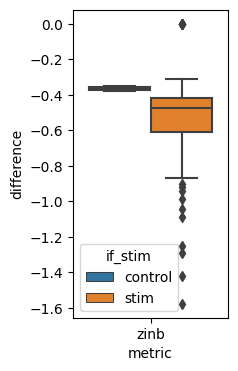

In [ ]:
import pandas as pd
import seaborn as sns
df=pd.DataFrame({'difference':differece0, 'if_stim':if_stim0, 'metric':metric0})
plt.figure(figsize=(2, 4))
# df.to_csv('nb_res.csv', index=False)

# print(df['difference'])
box_plot=sns.boxplot(data=df,x="metric", y="difference", hue="if_stim")
# plt.savefig('box-output.png')
# strip_plot=sns.stripplot(data=df,x="metric", y="difference",c='r', hue="if_stim")
# plt.savefig('strip-output.png')
# violin_plot=sns.violinplot(data=df,x="metric", y="difference", hue="if_stim")
# plt.savefig('violin-output2.png')


In [ ]:
def nb_fit_ctrl(adata,ctrl,conditions,sample_ctrl=False,ctrl1=None,ctrl2=None):
    
    if sample_ctrl:
        x,y=ctrl1,ctrl2
    else:
        x,y=data_prep(adata,ctrl,conditions)
        
    x,y=dist_based(x,y)
    alpha_x, const_x =process_per_batch(x,0,99,True)# fit x and plug in y 

    out=0
    count=0
    for i in range(x.shape[0]):
        if all(elem == 0 for elem in x[i]):
            continue
        if all(elem == 0 for elem in y[i]):
            continue 
        else:
          NoneType = type(None)
          if isinstance(const_x[i], NoneType) or isinstance(alpha_x[i], NoneType):
              continue 
          else:
              count+=1
              output,nan=compute_log_zinb(y[i],const_x[i],alpha_x[i],True)
              out+=output
              count-=nan
    
    if count==0:
      count=1# to avoid divison by zero     
            
    return out/count 
differece1,if_stim1,metric1=test_get_data(nb_fit_ctrl,train,'nb')

Streaming output truncated to the last 5000 lines.
gene 0
gene Optimization terminated successfully.
1
         Current function value: 0.227149
gene         Iterations: 7 2

         Function evaluations: 14gene
          Gradient evaluations: 143

gene 4
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.440640         Current function value: 0.559096

         Iterations: 8         Iterations: 9

         Function evaluations: 13
         Function evaluations: 13         Gradient evaluations: 13

         Gradient evaluations: 13gene
 gene6 
5
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.223620
         Current function value: 0.640815

         Iterations: 7
         Iterations: 9
         Function evaluations: 14         Function evaluations: 13

         Gradient evaluations: 13         Gradient evaluations: 14

gene gene 8
7
Optimization terminated success

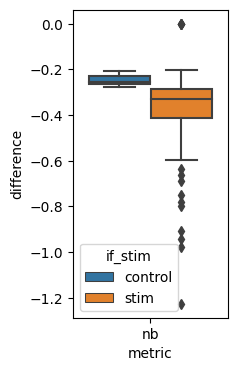

In [ ]:
import pandas as pd
import seaborn as sns

df=pd.DataFrame({'difference':differece1, 'if_stim':if_stim1, 'metric':metric1})
plt.figure(figsize=(2, 4))
# df.to_csv('zinb_res.csv', index=False)

box_plot=sns.boxplot(data=df,x="metric", y="difference", hue="if_stim")
# plt.savefig('box-output.png')
# strip_plot=sns.stripplot(data=df,x="metric", y="difference",c='r', hue="if_stim")
# plt.savefig('strip-output.png')
# violin_plot=sns.violinplot(data=df,x="metric", y="difference", hue="if_stim")
# plt.savefig('violin-output1.png')
